In [2]:
# Load modules

import pickle
import torch
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
import sys
import os
sys.path.append('..')
from types import SimpleNamespace
from field_of_junctions import FieldOfJunctions
import nbimporter

from torchsummary import summary

from Dataset_Maker_Lines import make_random_line_set, make_grey_transform

# %load_ext autoreload
# %reload_ext autoreload

In [3]:
dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
class LineDataset(torch.utils.data.Dataset):
    """ Dataset with support of transforms.
    """

    def __init__(self, images, params, boundaries, wedges, transform=None):
        self.images = images
        self.params = params
        self.boundaries = boundaries
        self.wedges = wedges
        self.transform = transform

    def __getitem__(self, index):
        
        image = self.images[index]
        wedge = self.wedges[index]

        if self.transform:
            image = self.transform(image)
            
        param = self.params[index].squeeze()
        boundary = self.boundaries[index]
        
        return image, param, boundary, wedge

    def __len__(self):
        return len(self.images)

In [12]:
def weights_init_uniform(m):
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('LazyLinear') != -1:
        # apply a uniform distribution to the weights and a bias=0
        m.weight.data.uniform_(0.0, 1.0)
        m.bias.data.fill_(0) 
    if classname.find('Linear') != -1:
        # apply a uniform distribution to the weights and a bias=0
        m.weight.data.uniform_(0.0, 1.0)
        m.bias.data.fill_(0)
    if classname.find('Conv2d') != -1:
        # apply a uniform distribution to the weights and a bias=0
        m.weight.data.uniform_(0.0, 1.0)
        m.bias.data.fill_(0)
        

#  -------- 32x32  --------

## 1) noiseless, multicolor images - 88 parameters

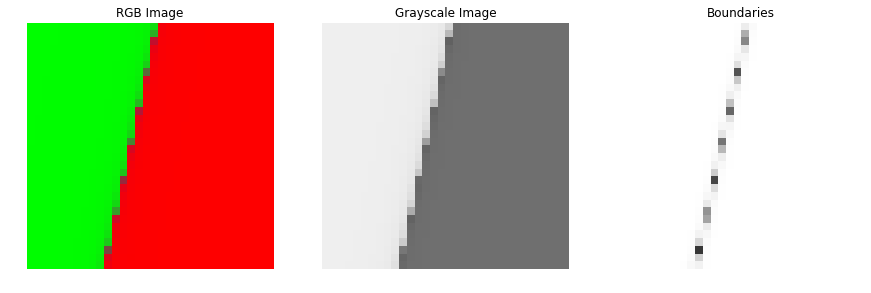

In [183]:
# What about if the centers are allowed to move within 25% of the center?

data_folder = 'foj_data/grayscale_lines/'

with open(data_folder + 'line_data_32_20000_grey_multicolor_uncentered.pkl','rb') as f:
    data = pickle.load(f)

# wedges = data['wedges']
wedges_grey = data['wedges_grey']
params = data['params']
boundaries = data['boundaries']
wedges = data['wedges']

img_show = 0
plt.figure(figsize=[15, 15])
plt.subplot(131)
plt.imshow(wedges[img_show,:,:].squeeze().permute(1,2,0).cpu())
plt.title('RGB Image')
plt.axis('off');
plt.subplot(132)
plt.imshow(wedges_grey[img_show,:,:].squeeze().cpu(),cmap='gray', vmin=0, vmax=1)
plt.title('Grayscale Image')
plt.axis('off');
plt.subplot(133)
plt.imshow(boundaries[img_show,:,:].squeeze().cpu(),cmap='gray', vmin=0, vmax=1)
plt.title('Boundaries')
plt.axis('off');

In [184]:
line_data = LineDataset(wedges_grey, params, boundaries, wedges)#, transform=trainTransform)
data_size = len(line_data)

print(data_size)

train_proportion = .85
# Split dataset into training and testing
train_dataset, test_dataset = torch.utils.data.random_split(line_data, [int(data_size*train_proportion), int(data_size*(1-train_proportion))], generator=torch.Generator().manual_seed(42))

# Create loaders for the training and testing data
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False) #len(test_dataset)


20000


In [185]:
class offCenterLineNet(nn.Module):

    def __init__(self):
        super().__init__()
                
        self.conv1 = nn.Conv2d(1, 1, kernel_size=3)
        self.fc = nn.LazyLinear(3)
        self.maxpool = nn.MaxPool2d(2)
        self.avgpool = nn.AvgPool2d(3)
    
    def forward(self, x):

        x = self.conv1(x)
#         x = F.relu(x)
        x = self.maxpool(x)
        x = self.avgpool(x)
        x = x.view(x.shape[0],-1)
        
        x = self.fc(x)
         
        # We're defining
        # a = - sin(theta)
        # b = cos(theta)
        # c = -cy*cos(theta)+cx*sin(theta)
        # Hence, we want to normalize the vector by 1/sqrt(a^2 + b^2)
        norm_factor = (torch.norm(x[:,:2],p=2,dim=1)).unsqueeze(1)        
        out = x/(norm_factor)#+eps)
#         print('Output shape=',x.shape)

#         out = x
        
        return out
    
model = offCenterLineNet()
model = model.to(dev)
summary(model, input_size=(1, H, W))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 1, 30, 30]              10
         MaxPool2d-2            [-1, 1, 15, 15]               0
         AvgPool2d-3              [-1, 1, 5, 5]               0
            Linear-4                    [-1, 3]              78
Total params: 88
Trainable params: 88
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.00
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


In [186]:
# Now let's train the initial network 

model = offCenterLineNet()
model = model.to(dev)
model.apply(weights_init_uniform)

model.train();

optimizer = torch.optim.Adam(model.parameters(),lr=.01) 
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.1)

n_epochs = 1400

mse_loss = nn.MSELoss()
ce_loss = nn.CrossEntropyLoss()

for epoch in range(0,n_epochs):  # loop over the dataset multiple times
    
    if epoch == 0:
        train_loss_over_time = [] # to track the loss as the network trains
        test_loss_over_time = []
        
    if epoch == 10:
        optimizer = torch.optim.Adam(model.parameters(),lr=.002) 
        
    running_loss = 0
    num_batches = 0
    
    for batch_i, data in enumerate(train_loader):
        
        # get the input images and their corresponding labels
        num_batches += 1

        inputs, output_gt, _, _ = data
        inputs, output_gt = inputs.to(dev), output_gt.to(dev)
        
        # zero the parameter (weight) gradients
        optimizer.zero_grad()
        
        # forward pass to get outputs
        output_line_params = model(inputs)
        

        # make the ground truth
        c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
        gt_line_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0]),c),dim=1)
        
        # calculate the loss
#         print(output_line_params[:,:,0,50])
        
        loss = mse_loss(output_line_params,gt_line_params)
        
        # backward pass to calculate the parameter gradients
        loss.backward()

        # update the parameters
        optimizer.step()

        # to convert loss into a scalar and add it to running_loss, we use .item()
        running_loss += loss.item()
      

#     scheduler.step()
    
    # Calculate test data loss after each epoch
    with torch.no_grad():
        test_loss = 0
        num_batches_test = 0
        for batch_i, data in enumerate(test_loader):
            num_batches_test += 1

            # Add code here
            inputs, output_gt, _, _ = data
            inputs, output_gt = inputs.to(dev), output_gt.to(dev)


            # zero the parameter (weight) gradients
            optimizer.zero_grad()

            # forward pass to get outputs
            output_line_params = model(inputs)

            # make the ground truth
            c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
            gt_line_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0]),c),dim=1)
    

            # calculate the loss
    #         print(output_line_params[:,:,0,50])

            loss = mse_loss(output_line_params,gt_line_params)
            
            test_loss += loss
                    
        test_loss_over_time.append(test_loss/num_batches_test)

    # Calculate model loss:
    avg_loss = running_loss/num_batches
    train_loss_over_time.append(avg_loss)
    
#     print('Epoch: {}, Avg. Train Loss: {},'.format(epoch + 1, train_loss_over_time[-1]))


    print('Epoch: {}, Avg. Train Loss: {}, Avg. Test Loss: {}'.format(epoch + 1, train_loss_over_time[-1], test_loss_over_time[-1]))
    
print('Finished Training')

plt.figure()
plt.semilogy(np.arange(0,n_epochs),train_loss_over_time[0:])
plt.semilogy(np.arange(0,n_epochs),test_loss_over_time[0:])
plt.legend(['Training loss', 'Testing loss'])

Epoch: 1, Avg. Train Loss: 0.01968317733843648, Avg. Test Loss: 0.0004927481641061604
Epoch: 2, Avg. Train Loss: 0.0003345760451885784, Avg. Test Loss: 0.00020098901586607099
Epoch: 3, Avg. Train Loss: 0.00022616768468911426, Avg. Test Loss: 0.00016619430971331894
Epoch: 4, Avg. Train Loss: 0.00014948587009794414, Avg. Test Loss: 0.00015737272042315453
Epoch: 5, Avg. Train Loss: 0.00011425629524904464, Avg. Test Loss: 9.761840919964015e-05
Epoch: 6, Avg. Train Loss: 0.00011361142927292766, Avg. Test Loss: 0.00011767601972678676
Epoch: 7, Avg. Train Loss: 0.0001109654560860875, Avg. Test Loss: 0.0001046477336785756
Epoch: 8, Avg. Train Loss: 0.00011424617141734019, Avg. Test Loss: 9.272374154534191e-05
Epoch: 9, Avg. Train Loss: 0.00011141200940942224, Avg. Test Loss: 8.591970254201442e-05
Epoch: 10, Avg. Train Loss: 0.0001273873459994272, Avg. Test Loss: 0.0001468933915020898
Epoch: 11, Avg. Train Loss: 9.52789573295062e-05, Avg. Test Loss: 9.649438288761303e-05
Epoch: 12, Avg. Train L

KeyboardInterrupt: 

[tensor(0.1974)]


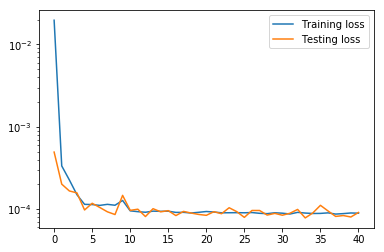

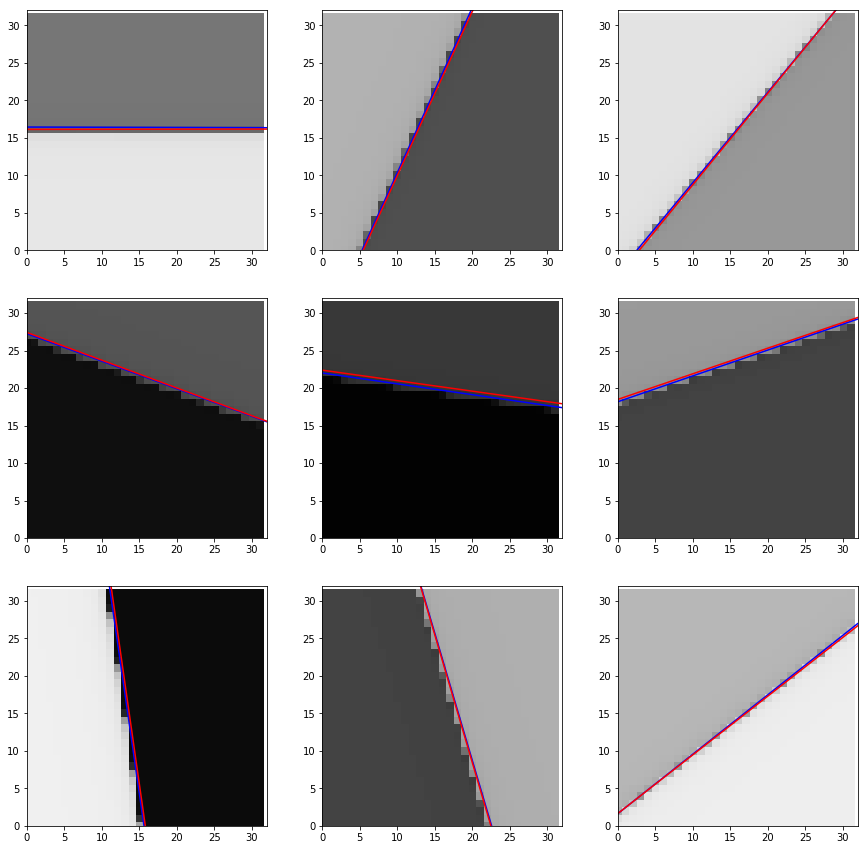

In [187]:
# Plot the Results

plt.figure()
plt.semilogy(np.arange(0,epoch),train_loss_over_time[:epoch])
plt.semilogy(np.arange(0,epoch),test_loss_over_time[:epoch])
plt.legend(['Training loss', 'Testing loss'])

model.eval();

ang_loss_all = []

for batch_i, data in enumerate(test_loader):
    # get the input images and their corresponding labels
    inputs, output_gt, _, _ = data
    inputs, output_gt = inputs.to(dev), output_gt.to(dev)
    

    # forward pass to get outputs
    outputs = model(inputs).squeeze().detach().cpu()
    
    gt = output_gt.cpu().squeeze()
    
    c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
    angle_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0]),c),axis=1).detach().cpu()
  
    # Calculate angular loss
    ang_loss = torch.mean(torch.abs(torch.rad2deg(torch.atan2(-angle_params[:,0]*outputs[:,1] + angle_params[:,1]*outputs[:,0]
                                         ,angle_params[:,1]*outputs[:,1]+angle_params[:,0]*outputs[:,0]).cpu())))

    ang_loss_all.append(ang_loss)

    
print(ang_loss_all)

plt.figure(figsize=[15, 15])

for ii in range(9):
    
    plt.subplot(3,3,ii+1)
    plt.imshow(inputs[ii].cpu().squeeze(),cmap='gray', vmin=0, vmax=1)
    
    # Plot the ground truth lines
    x_sample = torch.linspace(-1,1,inputs.shape[-1])
    y_sample = -angle_params[ii,0]/angle_params[ii,1]*x_sample - angle_params[ii,2]/angle_params[ii,1]
    
    plt.plot(x_sample*W/2+W/2,y_sample*W/2+W/2,'b')
    plt.xlim([0,W])
    plt.ylim(([0,W]))
    
    # Plot the estimated lines
    y_est = -outputs[ii,0]/outputs[ii,1]*x_sample - outputs[ii,2]/outputs[ii,1]
    plt.plot(x_sample*W/2+W/2,y_est*W/2+W/2,'r')

## 2) noisy (variable noise per image), multicolor images - 808 parameters

torch.Size([50000, 1, 32, 32])
50000


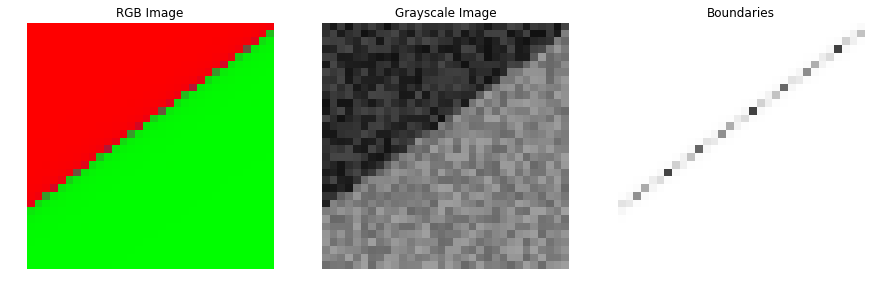

In [192]:
# Load dataset 

data_folder = 'foj_data/grayscale_lines/'

with open(data_folder + 'line_data_32_50000_grey_multicolor_noise_random_uncentered.pkl','rb') as f:
    data = pickle.load(f)

# wedges = data['wedges']
wedges_grey = data['wedges_grey']
params = data['params']
boundaries = data['boundaries']
wedges = data['wedges']


line_data = LineDataset(wedges_grey, params, boundaries, wedges)#, transform=trainTransform)
data_size = len(line_data)

print(wedges_grey.shape)
print(data_size)

train_proportion = .85
# Split dataset into training and testing
train_dataset, test_dataset = torch.utils.data.random_split(line_data, [int(data_size*train_proportion), int(data_size*(1-train_proportion))], generator=torch.Generator().manual_seed(42))

# Create loaders for the training and testing data
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1000, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=500, shuffle=False) #len(test_dataset)


W,H = 32,32

img_show = 0
plt.figure(figsize=[15, 15])
plt.subplot(131)
plt.imshow(wedges[img_show,:,:].squeeze().permute(1,2,0).cpu())
plt.title('RGB Image')
plt.axis('off');
plt.subplot(132)
plt.imshow(wedges_grey[img_show,:,:].squeeze().cpu(),cmap='gray', vmin=0, vmax=1)
plt.title('Grayscale Image')
plt.axis('off');
plt.subplot(133)
plt.imshow(boundaries[img_show,:,:].squeeze().cpu(),cmap='gray', vmin=0, vmax=1)
plt.title('Boundaries')
plt.axis('off');


In [213]:
class offCenterLineNet(nn.Module):

    def __init__(self):
        super().__init__()
                
        self.conv1 = nn.Conv2d(1, 4, kernel_size=3) #64 is good
        self.conv2 = nn.Conv2d(4, 4, kernel_size=3)
        self.conv3 = nn.Conv2d(4, 4, kernel_size=3)
        self.conv4 = nn.Conv2d(4, 1, kernel_size=3)
#         self.conv5 = nn.Conv2d(4, 1, kernel_size=3)
        self.fc = nn.LazyLinear(3)
        self.maxpool = nn.MaxPool2d(2)
        self.avgpool = nn.AvgPool2d(3)
        self.activate = nn.ReLU()
#         self.batchnorm = nn.BatchNorm2d(128)
    
    def forward(self, x):

        x = self.conv1(x)
#         x = F.relu(x)
        x = self.activate(x)
#         x = self.maxpool(x)
#         x = self.batchnorm(x)
        x = self.conv2(x)
        x = self.activate(x)
#         x = F.relu(x)
#         x = self.batchnorm(x)
        x = self.conv3(x)
        x = self.activate(x)
        x = self.conv4(x)
#         x = self.activate(x)
#         x = self.conv5(x)
        
        x = self.maxpool(x)
        x = self.avgpool(x)
        x = x.view(x.shape[0],-1)
        
        x = self.fc(x)
         
        # We're defining
        # a = - sin(theta)
        # b = cos(theta)
        # c = -cy*cos(theta)+cx*sin(theta)
        # Hence, we want to normalize the vector by 1/sqrt(a^2 + b^2)
        norm_factor = (torch.norm(x[:,:2],p=2,dim=1)).unsqueeze(1)       
        out = x/(norm_factor)#+eps)
#         print('Output shape=',x.shape)

#         out = x
        
        return out
    
model = offCenterLineNet()
model = model.to(dev)
summary(model, input_size=(1, H, W))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 30, 30]              40
              ReLU-2            [-1, 4, 30, 30]               0
            Conv2d-3            [-1, 4, 28, 28]             148
              ReLU-4            [-1, 4, 28, 28]               0
            Conv2d-5            [-1, 4, 26, 26]             148
              ReLU-6            [-1, 4, 26, 26]               0
            Conv2d-7            [-1, 1, 24, 24]              37
         MaxPool2d-8            [-1, 1, 12, 12]               0
         AvgPool2d-9              [-1, 1, 4, 4]               0
           Linear-10                    [-1, 3]              51
Total params: 424
Trainable params: 424
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.15
Params size (MB): 0.00
Estimated Total Siz

Epoch: 1, Avg. Train Loss: 0.6788065863210101, Avg. Test Loss: 0.5675531029701233
Epoch: 2, Avg. Train Loss: 0.4215945878694224, Avg. Test Loss: 0.44449251890182495
Epoch: 3, Avg. Train Loss: 0.4045008088267127, Avg. Test Loss: 0.3137219548225403
Epoch: 4, Avg. Train Loss: 0.192260776148286, Avg. Test Loss: 0.13447639346122742
Epoch: 5, Avg. Train Loss: 0.07950862540408622, Avg. Test Loss: 0.05487624555826187
Epoch: 6, Avg. Train Loss: 0.04511219566298086, Avg. Test Loss: 0.03786630183458328
Epoch: 7, Avg. Train Loss: 0.03278923381206601, Avg. Test Loss: 0.0285464096814394
Epoch: 8, Avg. Train Loss: 0.024978281193694402, Avg. Test Loss: 0.021947406232357025
Epoch: 9, Avg. Train Loss: 0.019289766849820002, Avg. Test Loss: 0.017035609111189842
Epoch: 10, Avg. Train Loss: 0.015105392610610918, Avg. Test Loss: 0.013446365483105183
Epoch: 11, Avg. Train Loss: 0.0086152711450014, Avg. Test Loss: 0.006125062704086304
Epoch: 12, Avg. Train Loss: 0.00497179162190404, Avg. Test Loss: 0.004004119

Epoch: 94, Avg. Train Loss: 0.0008520339859303, Avg. Test Loss: 0.0008466509752906859
Epoch: 95, Avg. Train Loss: 0.0008407411758441392, Avg. Test Loss: 0.000829652592074126
Epoch: 96, Avg. Train Loss: 0.000833242094729009, Avg. Test Loss: 0.0008239588350988925
Epoch: 97, Avg. Train Loss: 0.0008355383923667115, Avg. Test Loss: 0.0008177379495464265
Epoch: 98, Avg. Train Loss: 0.0008384599242099496, Avg. Test Loss: 0.0008168435888364911
Epoch: 99, Avg. Train Loss: 0.0008382649921682165, Avg. Test Loss: 0.0008265840588137507
Epoch: 100, Avg. Train Loss: 0.0008415478013650795, Avg. Test Loss: 0.0008177451090887189
Epoch: 101, Avg. Train Loss: 0.0008451139762846016, Avg. Test Loss: 0.0008165845065377653
Epoch: 102, Avg. Train Loss: 0.0008356644891115815, Avg. Test Loss: 0.000823759357444942
Epoch: 103, Avg. Train Loss: 0.0008346507823917755, Avg. Test Loss: 0.000818306056316942
Epoch: 104, Avg. Train Loss: 0.0008364685765077728, Avg. Test Loss: 0.0008202730678021908
Epoch: 105, Avg. Train 

Epoch: 186, Avg. Train Loss: 0.0008012973838810657, Avg. Test Loss: 0.0007913447334431112
Epoch: 187, Avg. Train Loss: 0.0007928887701614998, Avg. Test Loss: 0.0008143113227561116
Epoch: 188, Avg. Train Loss: 0.0007929448133096272, Avg. Test Loss: 0.0008504340657964349
Epoch: 189, Avg. Train Loss: 0.0007926897784738346, Avg. Test Loss: 0.0007810751558281481
Epoch: 190, Avg. Train Loss: 0.0007823665875421707, Avg. Test Loss: 0.0007907641702331603
Epoch: 191, Avg. Train Loss: 0.0007785455835441691, Avg. Test Loss: 0.0007754757534712553
Epoch: 192, Avg. Train Loss: 0.000775143104811134, Avg. Test Loss: 0.0007880437769927084
Epoch: 193, Avg. Train Loss: 0.0007767108929625084, Avg. Test Loss: 0.0007906421087682247
Epoch: 194, Avg. Train Loss: 0.0007718279957771301, Avg. Test Loss: 0.0007639590185135603
Epoch: 195, Avg. Train Loss: 0.000769539141951692, Avg. Test Loss: 0.0007723097805865109
Epoch: 196, Avg. Train Loss: 0.0007706122800469571, Avg. Test Loss: 0.000788825040217489
Epoch: 197, A

Epoch: 278, Avg. Train Loss: 0.0005903077490497814, Avg. Test Loss: 0.0005990809295326471
Epoch: 279, Avg. Train Loss: 0.000592771947362222, Avg. Test Loss: 0.0006009694770909846
Epoch: 280, Avg. Train Loss: 0.0005902781240577095, Avg. Test Loss: 0.0006172434659674764
Epoch: 281, Avg. Train Loss: 0.0005915091660003676, Avg. Test Loss: 0.0005993511294946074
Epoch: 282, Avg. Train Loss: 0.0005980074787404129, Avg. Test Loss: 0.000608747941441834
Epoch: 283, Avg. Train Loss: 0.0005954324584562591, Avg. Test Loss: 0.0006022357847541571
Epoch: 284, Avg. Train Loss: 0.0005937919188507421, Avg. Test Loss: 0.0005993524682708085
Epoch: 285, Avg. Train Loss: 0.0005884017188881719, Avg. Test Loss: 0.000597361708059907
Epoch: 286, Avg. Train Loss: 0.0005903832308493208, Avg. Test Loss: 0.0006098818266764283
Epoch: 287, Avg. Train Loss: 0.0005888245596420453, Avg. Test Loss: 0.000602894346229732
Epoch: 288, Avg. Train Loss: 0.0005907490362174982, Avg. Test Loss: 0.0006016740808263421
Epoch: 289, Av

Epoch: 370, Avg. Train Loss: 0.0005736174813179343, Avg. Test Loss: 0.0005897050141356885
Epoch: 371, Avg. Train Loss: 0.000582831674851044, Avg. Test Loss: 0.000620310369413346
Epoch: 372, Avg. Train Loss: 0.0005766612621089227, Avg. Test Loss: 0.000587271701078862
Epoch: 373, Avg. Train Loss: 0.0005754232325396219, Avg. Test Loss: 0.0005895608919672668
Epoch: 374, Avg. Train Loss: 0.0005769692909589774, Avg. Test Loss: 0.0005973984370939434
Epoch: 375, Avg. Train Loss: 0.0005767616892753299, Avg. Test Loss: 0.0005987865151837468
Epoch: 376, Avg. Train Loss: 0.0005781645101473428, Avg. Test Loss: 0.0006034462130628526
Epoch: 377, Avg. Train Loss: 0.0005783190393040693, Avg. Test Loss: 0.0005881533725187182
Epoch: 378, Avg. Train Loss: 0.0005740685981351796, Avg. Test Loss: 0.0005918879178352654
Epoch: 379, Avg. Train Loss: 0.0005751090749643396, Avg. Test Loss: 0.0005868768785148859
Epoch: 380, Avg. Train Loss: 0.0005736165642088582, Avg. Test Loss: 0.0005890020402148366
Epoch: 381, A

Epoch: 462, Avg. Train Loss: 0.000566131820452811, Avg. Test Loss: 0.0005954605294391513
Epoch: 463, Avg. Train Loss: 0.0005695743927580499, Avg. Test Loss: 0.0005843349499627948
Epoch: 464, Avg. Train Loss: 0.0005706378724426031, Avg. Test Loss: 0.0005884633865207434
Epoch: 465, Avg. Train Loss: 0.0005661494641424005, Avg. Test Loss: 0.00058410142082721
Epoch: 466, Avg. Train Loss: 0.0005662010963681306, Avg. Test Loss: 0.0005943627329543233
Epoch: 467, Avg. Train Loss: 0.0005714178192266805, Avg. Test Loss: 0.0005949115147814155
Epoch: 468, Avg. Train Loss: 0.0005698442536265437, Avg. Test Loss: 0.000593754171859473
Epoch: 469, Avg. Train Loss: 0.0005740177503592053, Avg. Test Loss: 0.0005855548079125583
Epoch: 470, Avg. Train Loss: 0.0005673907513102127, Avg. Test Loss: 0.0005850275629200041
Epoch: 471, Avg. Train Loss: 0.0005701626772819043, Avg. Test Loss: 0.0005970792262814939
Epoch: 472, Avg. Train Loss: 0.0005644781435135925, Avg. Test Loss: 0.0005861329264007509
Epoch: 473, Av

Epoch: 554, Avg. Train Loss: 0.0005608096564470162, Avg. Test Loss: 0.0005752056022174656
Epoch: 555, Avg. Train Loss: 0.0005597398307737569, Avg. Test Loss: 0.0005750433774664998
Epoch: 556, Avg. Train Loss: 0.0005582369211519701, Avg. Test Loss: 0.0005921024712733924
Epoch: 557, Avg. Train Loss: 0.0005589160150415156, Avg. Test Loss: 0.0005778162740170956
Epoch: 558, Avg. Train Loss: 0.000557016467588932, Avg. Test Loss: 0.000577435246668756
Epoch: 559, Avg. Train Loss: 0.0005571326527874483, Avg. Test Loss: 0.0005821554223075509
Epoch: 560, Avg. Train Loss: 0.0005611239669866167, Avg. Test Loss: 0.0005812288145534694
Epoch: 561, Avg. Train Loss: 0.000556859444978452, Avg. Test Loss: 0.0005766699905507267
Epoch: 562, Avg. Train Loss: 0.0005573992479354316, Avg. Test Loss: 0.0005745679372921586
Epoch: 563, Avg. Train Loss: 0.0005614249953501966, Avg. Test Loss: 0.0005745143280364573
Epoch: 564, Avg. Train Loss: 0.0005599308933597058, Avg. Test Loss: 0.0005814969190396369
Epoch: 565, A

Epoch: 646, Avg. Train Loss: 0.000551786890312986, Avg. Test Loss: 0.0005728839314542711
Epoch: 647, Avg. Train Loss: 0.0005498788851519051, Avg. Test Loss: 0.0005636228015646338
Epoch: 648, Avg. Train Loss: 0.0005501788515640899, Avg. Test Loss: 0.0005691830301657319
Epoch: 649, Avg. Train Loss: 0.0005485432541950844, Avg. Test Loss: 0.0005688410601578653
Epoch: 650, Avg. Train Loss: 0.0005519301853911562, Avg. Test Loss: 0.0005615429836325347
Epoch: 651, Avg. Train Loss: 0.0005516812088899314, Avg. Test Loss: 0.0005801201332360506
Epoch: 652, Avg. Train Loss: 0.000550031736438964, Avg. Test Loss: 0.0005610113148577511
Epoch: 653, Avg. Train Loss: 0.0005475794497151795, Avg. Test Loss: 0.0005673788255080581
Epoch: 654, Avg. Train Loss: 0.0005483002778207667, Avg. Test Loss: 0.0005770951975136995
Epoch: 655, Avg. Train Loss: 0.0005547844955080384, Avg. Test Loss: 0.0005601375596597791
Epoch: 656, Avg. Train Loss: 0.0005516886323971977, Avg. Test Loss: 0.0005668012308888137
Epoch: 657, 

Epoch: 738, Avg. Train Loss: 0.0005433453269963434, Avg. Test Loss: 0.0005504879518412054
Epoch: 739, Avg. Train Loss: 0.0005433686249510407, Avg. Test Loss: 0.0005565080791711807
Epoch: 740, Avg. Train Loss: 0.0005417996286522856, Avg. Test Loss: 0.0005683492636308074
Epoch: 741, Avg. Train Loss: 0.0005446988818517258, Avg. Test Loss: 0.0005710279219783843
Epoch: 742, Avg. Train Loss: 0.0005443422678793066, Avg. Test Loss: 0.0005600865697488189
Epoch: 743, Avg. Train Loss: 0.0005461913452288786, Avg. Test Loss: 0.0005614029360003769
Epoch: 744, Avg. Train Loss: 0.000541077341294176, Avg. Test Loss: 0.0005510629271157086
Epoch: 745, Avg. Train Loss: 0.0005427275582617365, Avg. Test Loss: 0.0005546253523789346
Epoch: 746, Avg. Train Loss: 0.0005400090987339269, Avg. Test Loss: 0.0005573623348027468
Epoch: 747, Avg. Train Loss: 0.0005414823143266488, Avg. Test Loss: 0.0005545180756598711
Epoch: 748, Avg. Train Loss: 0.0005424515436251843, Avg. Test Loss: 0.000552909797988832
Epoch: 749, 

Epoch: 830, Avg. Train Loss: 0.0005385266843002809, Avg. Test Loss: 0.0005590587970800698
Epoch: 831, Avg. Train Loss: 0.0005424250774139669, Avg. Test Loss: 0.0005653216503560543
Epoch: 832, Avg. Train Loss: 0.0005379101541705516, Avg. Test Loss: 0.0005589451757259667
Epoch: 833, Avg. Train Loss: 0.0005437279773908559, Avg. Test Loss: 0.0005618294235318899
Epoch: 834, Avg. Train Loss: 0.0005389897174440151, Avg. Test Loss: 0.0005567825282923877
Epoch: 835, Avg. Train Loss: 0.0005389619848777562, Avg. Test Loss: 0.0005523959407582879
Epoch: 836, Avg. Train Loss: 0.0005405744311648832, Avg. Test Loss: 0.000555375765543431
Epoch: 837, Avg. Train Loss: 0.0005402302282840706, Avg. Test Loss: 0.000558136438485235
Epoch: 838, Avg. Train Loss: 0.0005440733586383853, Avg. Test Loss: 0.0005632195970974863
Epoch: 839, Avg. Train Loss: 0.0005384138291214354, Avg. Test Loss: 0.0005522125866264105
Epoch: 840, Avg. Train Loss: 0.0005424893704827788, Avg. Test Loss: 0.0005561885191127658
Epoch: 841, 

Epoch: 922, Avg. Train Loss: 0.0005384312528402133, Avg. Test Loss: 0.0005505910376086831
Epoch: 923, Avg. Train Loss: 0.0005353015893528802, Avg. Test Loss: 0.0005550830392166972
Epoch: 924, Avg. Train Loss: 0.0005383238360166636, Avg. Test Loss: 0.0005494935903698206
Epoch: 925, Avg. Train Loss: 0.0005363530004234595, Avg. Test Loss: 0.0005558508564718068
Epoch: 926, Avg. Train Loss: 0.0005379916279749989, Avg. Test Loss: 0.0005542868748307228
Epoch: 927, Avg. Train Loss: 0.0005351898644855896, Avg. Test Loss: 0.0005539450794458389
Epoch: 928, Avg. Train Loss: 0.0005370770150600651, Avg. Test Loss: 0.0005547364708036184
Epoch: 929, Avg. Train Loss: 0.0005384950958149032, Avg. Test Loss: 0.0005505788722075522
Epoch: 930, Avg. Train Loss: 0.0005406462154242882, Avg. Test Loss: 0.0005529562477022409
Epoch: 931, Avg. Train Loss: 0.000537201086719802, Avg. Test Loss: 0.0005636292044073343
Epoch: 932, Avg. Train Loss: 0.0005383878204495062, Avg. Test Loss: 0.0005628929939121008
Epoch: 933,

Epoch: 1014, Avg. Train Loss: 0.0005389678009060147, Avg. Test Loss: 0.0005551836220547557
Epoch: 1015, Avg. Train Loss: 0.0005344508234736358, Avg. Test Loss: 0.000558628118596971
Epoch: 1016, Avg. Train Loss: 0.0005343201208783877, Avg. Test Loss: 0.0005513778887689114
Epoch: 1017, Avg. Train Loss: 0.0005338120891517678, Avg. Test Loss: 0.0005525244050659239
Epoch: 1018, Avg. Train Loss: 0.0005353082460080555, Avg. Test Loss: 0.0005456125363707542
Epoch: 1019, Avg. Train Loss: 0.0005376465052777771, Avg. Test Loss: 0.0005470642354339361
Epoch: 1020, Avg. Train Loss: 0.0005373003612391564, Avg. Test Loss: 0.0005637889262288809
Epoch: 1021, Avg. Train Loss: 0.0005354104133127907, Avg. Test Loss: 0.0005490774055942893
Epoch: 1022, Avg. Train Loss: 0.0005364136101656355, Avg. Test Loss: 0.0005457789520733058
Epoch: 1023, Avg. Train Loss: 0.0005343767034626285, Avg. Test Loss: 0.0005552173824980855
Epoch: 1024, Avg. Train Loss: 0.0005313114014042672, Avg. Test Loss: 0.0005462646950036287


Epoch: 1105, Avg. Train Loss: 0.0005367705503716892, Avg. Test Loss: 0.0005490915500558913
Epoch: 1106, Avg. Train Loss: 0.0005335624405551095, Avg. Test Loss: 0.0005465499125421047
Epoch: 1107, Avg. Train Loss: 0.0005332699186320222, Avg. Test Loss: 0.0005477716913446784
Epoch: 1108, Avg. Train Loss: 0.0005326084115780717, Avg. Test Loss: 0.0005430901073850691
Epoch: 1109, Avg. Train Loss: 0.00053454126464203, Avg. Test Loss: 0.0005518415127880871
Epoch: 1110, Avg. Train Loss: 0.0005332476988727183, Avg. Test Loss: 0.000545801711268723
Epoch: 1111, Avg. Train Loss: 0.0005321668394635496, Avg. Test Loss: 0.0005465874564833939
Epoch: 1112, Avg. Train Loss: 0.0005326399459167882, Avg. Test Loss: 0.0005487229791469872
Epoch: 1113, Avg. Train Loss: 0.0005309067640810946, Avg. Test Loss: 0.0005462754634208977
Epoch: 1114, Avg. Train Loss: 0.0005308017121129778, Avg. Test Loss: 0.0005479187238961458
Epoch: 1115, Avg. Train Loss: 0.0005327244844222658, Avg. Test Loss: 0.0005577951669692993
Ep

Epoch: 1196, Avg. Train Loss: 0.0005314000103850091, Avg. Test Loss: 0.0005431346362456679
Epoch: 1197, Avg. Train Loss: 0.000531598818650859, Avg. Test Loss: 0.0005447135772556067
Epoch: 1198, Avg. Train Loss: 0.0005326527861206857, Avg. Test Loss: 0.0005428387667052448
Epoch: 1199, Avg. Train Loss: 0.0005348894209059519, Avg. Test Loss: 0.0005501598352566361
Epoch: 1200, Avg. Train Loss: 0.0005342275673133689, Avg. Test Loss: 0.0005436953506432474
Epoch: 1201, Avg. Train Loss: 0.0005324764311216165, Avg. Test Loss: 0.0005479598767124116
Epoch: 1202, Avg. Train Loss: 0.0005341115804269996, Avg. Test Loss: 0.0005462240660563111
Epoch: 1203, Avg. Train Loss: 0.0005304735901137424, Avg. Test Loss: 0.0005411380552686751
Epoch: 1204, Avg. Train Loss: 0.0005345692584659298, Avg. Test Loss: 0.0005489968461915851
Epoch: 1205, Avg. Train Loss: 0.0005323452364685837, Avg. Test Loss: 0.0005413292674347758
Epoch: 1206, Avg. Train Loss: 0.0005299544718582183, Avg. Test Loss: 0.0005448543233796954


Epoch: 1287, Avg. Train Loss: 0.0005344178928278906, Avg. Test Loss: 0.0005393851897679269
Epoch: 1288, Avg. Train Loss: 0.0005296635973473015, Avg. Test Loss: 0.0005451672477647662
Epoch: 1289, Avg. Train Loss: 0.0005284250161588885, Avg. Test Loss: 0.0005416475469246507
Epoch: 1290, Avg. Train Loss: 0.0005300628958096684, Avg. Test Loss: 0.0005452833720482886
Epoch: 1291, Avg. Train Loss: 0.0005323121278156894, Avg. Test Loss: 0.0005500229308381677
Epoch: 1292, Avg. Train Loss: 0.0005308036972649482, Avg. Test Loss: 0.0005422073299996555
Epoch: 1293, Avg. Train Loss: 0.0005305660144036072, Avg. Test Loss: 0.000546927098184824
Epoch: 1294, Avg. Train Loss: 0.0005317739946063781, Avg. Test Loss: 0.0005483657587319613
Epoch: 1295, Avg. Train Loss: 0.0005310735933287719, Avg. Test Loss: 0.000544749025721103
Epoch: 1296, Avg. Train Loss: 0.0005306283994794412, Avg. Test Loss: 0.0005434132181107998
Epoch: 1297, Avg. Train Loss: 0.0005287621197355694, Avg. Test Loss: 0.0005402066744863987
E

Epoch: 1378, Avg. Train Loss: 0.0005302802438923525, Avg. Test Loss: 0.0005420970264822245
Epoch: 1379, Avg. Train Loss: 0.0005286593514028937, Avg. Test Loss: 0.000540867738891393
Epoch: 1380, Avg. Train Loss: 0.0005303556539475658, Avg. Test Loss: 0.0005427008145488799
Epoch: 1381, Avg. Train Loss: 0.0005305907702571604, Avg. Test Loss: 0.0005390167352743447
Epoch: 1382, Avg. Train Loss: 0.0005323847966961736, Avg. Test Loss: 0.0005462597473524511
Epoch: 1383, Avg. Train Loss: 0.0005312384929248067, Avg. Test Loss: 0.0005528818583115935
Epoch: 1384, Avg. Train Loss: 0.0005287537987473919, Avg. Test Loss: 0.0005420860834419727
Epoch: 1385, Avg. Train Loss: 0.0005320347243172745, Avg. Test Loss: 0.0005419536028057337
Epoch: 1386, Avg. Train Loss: 0.0005295800456647263, Avg. Test Loss: 0.000546202645637095
Epoch: 1387, Avg. Train Loss: 0.0005264300406304036, Avg. Test Loss: 0.0005391394370235503
Epoch: 1388, Avg. Train Loss: 0.0005292716181598777, Avg. Test Loss: 0.0005449939053505659
E

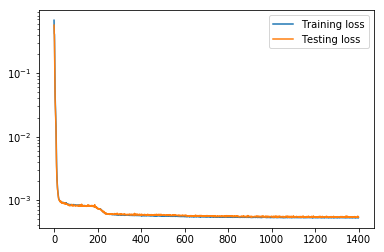

In [219]:
# Now let's train the initial network 

model = offCenterLineNet()
model = model.to(dev)
model.apply(weights_init_uniform)

model.train();

optimizer = torch.optim.Adam(model.parameters(),lr=.01) 
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.1)

n_epochs = 1400

mse_loss = nn.MSELoss()
ce_loss = nn.CrossEntropyLoss()

for epoch in range(0,n_epochs):  # loop over the dataset multiple times
    
    if epoch == 0:
        train_loss_over_time = [] # to track the loss as the network trains
        test_loss_over_time = []
        
    if epoch == 10:
        optimizer = torch.optim.Adam(model.parameters(),lr=.002) 
        
    running_loss = 0
    num_batches = 0
    
    for batch_i, data in enumerate(train_loader):
        
        # get the input images and their corresponding labels
        num_batches += 1

        inputs, output_gt, _, _ = data
        inputs, output_gt = inputs.to(dev), output_gt.to(dev)
        
        # zero the parameter (weight) gradients
        optimizer.zero_grad()
        
        # forward pass to get outputs
        output_line_params = model(inputs)
        

        # make the ground truth
        c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
        gt_line_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0]),c),dim=1)
        
        # calculate the loss
#         print(output_line_params[:,:,0,50])
        
        loss = mse_loss(output_line_params,gt_line_params)
        
        # backward pass to calculate the parameter gradients
        loss.backward()

        # update the parameters
        optimizer.step()

        # to convert loss into a scalar and add it to running_loss, we use .item()
        running_loss += loss.item()
      

#     scheduler.step()
    
    # Calculate test data loss after each epoch
    with torch.no_grad():
        test_loss = 0
        num_batches_test = 0
        for batch_i, data in enumerate(test_loader):
            num_batches_test += 1

            # Add code here
            inputs, output_gt, _, _ = data
            inputs, output_gt = inputs.to(dev), output_gt.to(dev)


            # zero the parameter (weight) gradients
            optimizer.zero_grad()

            # forward pass to get outputs
            output_line_params = model(inputs)

            # make the ground truth
            c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
            gt_line_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0]),c),dim=1)
    

            # calculate the loss
    #         print(output_line_params[:,:,0,50])

            loss = mse_loss(output_line_params,gt_line_params)
            
            test_loss += loss
                    
        test_loss_over_time.append(test_loss/num_batches_test)

    # Calculate model loss:
    avg_loss = running_loss/num_batches
    train_loss_over_time.append(avg_loss)
    
#     print('Epoch: {}, Avg. Train Loss: {},'.format(epoch + 1, train_loss_over_time[-1]))


    print('Epoch: {}, Avg. Train Loss: {}, Avg. Test Loss: {}'.format(epoch + 1, train_loss_over_time[-1], test_loss_over_time[-1]))
    
print('Finished Training')

plt.figure()
plt.semilogy(np.arange(0,n_epochs),train_loss_over_time[0:])
plt.semilogy(np.arange(0,n_epochs),test_loss_over_time[0:])
plt.legend(['Training loss', 'Testing loss'])

[tensor(1.0105), tensor(1.1114), tensor(1.0789), tensor(1.1080), tensor(1.1280), tensor(1.0390), tensor(1.0820), tensor(1.1257), tensor(1.1319), tensor(1.0466), tensor(1.0259), tensor(1.0624), tensor(1.1279), tensor(1.1362), tensor(1.0710)]


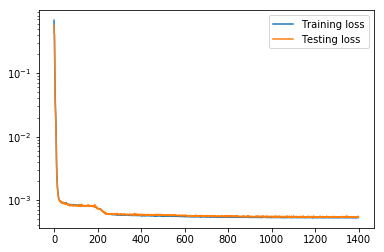

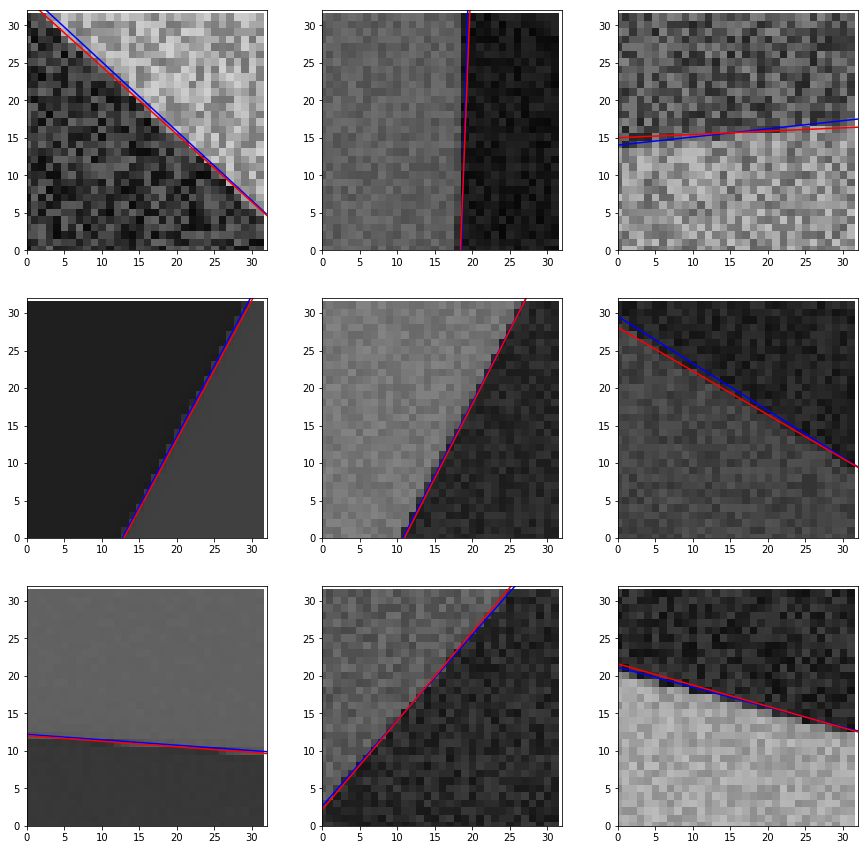

In [220]:
# Plot the Results

plt.figure()
plt.semilogy(np.arange(0,epoch),train_loss_over_time[:epoch])
plt.semilogy(np.arange(0,epoch),test_loss_over_time[:epoch])
plt.legend(['Training loss', 'Testing loss'])

model.eval();

ang_loss_all = []

for batch_i, data in enumerate(test_loader):
    # get the input images and their corresponding labels
    inputs, output_gt, _, _ = data
    inputs, output_gt = inputs.to(dev), output_gt.to(dev)
    

    # forward pass to get outputs
    outputs = model(inputs).squeeze().detach().cpu()
    
    gt = output_gt.cpu().squeeze()
    
    c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
    angle_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0]),c),axis=1).detach().cpu()
  
    # Calculate angular loss
    ang_loss = torch.mean(torch.abs(torch.rad2deg(torch.atan2(-angle_params[:,0]*outputs[:,1] + angle_params[:,1]*outputs[:,0]
                                         ,angle_params[:,1]*outputs[:,1]+angle_params[:,0]*outputs[:,0]).cpu())))

    ang_loss_all.append(ang_loss)

    
print(ang_loss_all)

plt.figure(figsize=[15, 15])

for ii in range(9):
    
    plt.subplot(3,3,ii+1)
    plt.imshow(inputs[ii].cpu().squeeze(),cmap='gray', vmin=0, vmax=1)
    
    # Plot the ground truth lines
    x_sample = torch.linspace(-1,1,inputs.shape[-1])
    y_sample = -angle_params[ii,0]/angle_params[ii,1]*x_sample - angle_params[ii,2]/angle_params[ii,1]
    
    plt.plot(x_sample*W/2+W/2,y_sample*W/2+W/2,'b')
    plt.xlim([0,W])
    plt.ylim(([0,W]))
    
    # Plot the estimated lines
    y_est = -outputs[ii,0]/outputs[ii,1]*x_sample - outputs[ii,2]/outputs[ii,1]
    plt.plot(x_sample*W/2+W/2,y_est*W/2+W/2,'r')

## test trained model on noiseless, multicolor data

10000
[tensor(0.2804), tensor(0.2585), tensor(0.2758)]


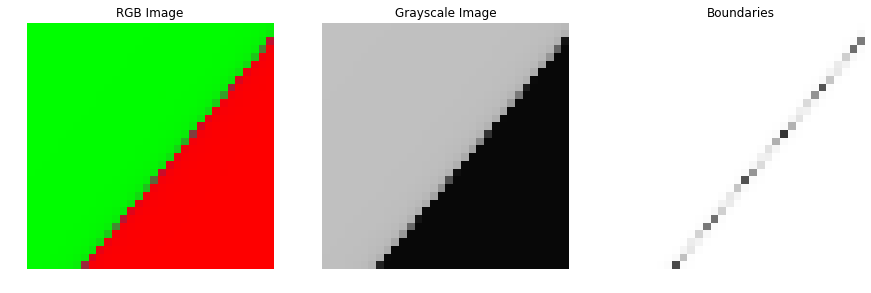

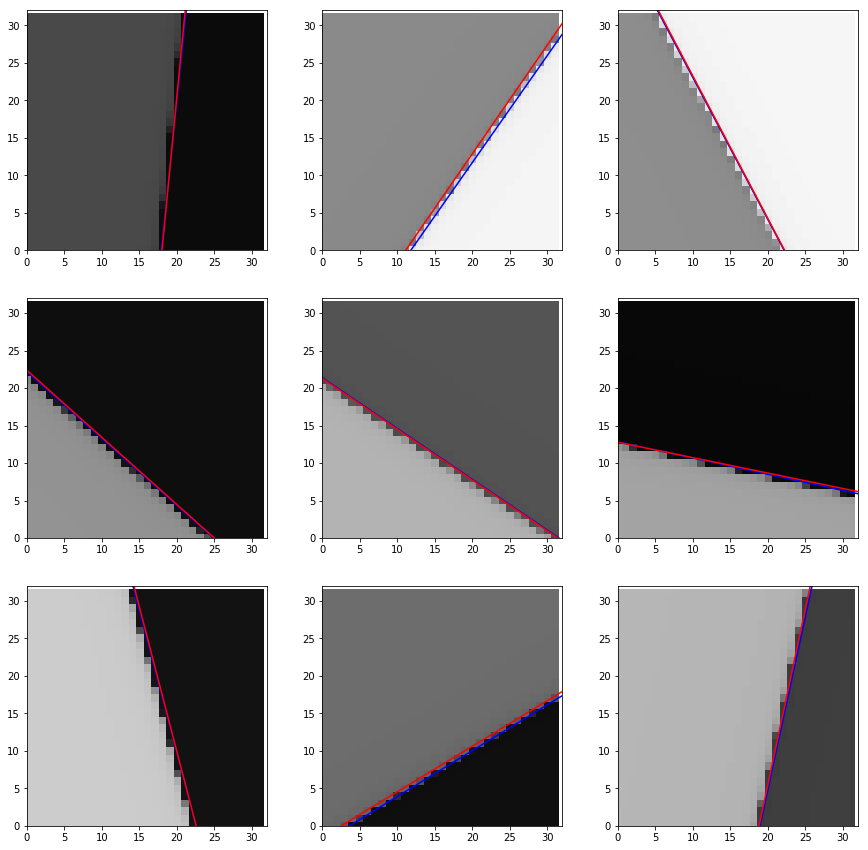

In [221]:
# Plot the Results

# line_data_32_10000_grey_multicolor_centered.pkl

# Load dataset 

data_folder = 'foj_data/grayscale_lines/'

with open(data_folder + 'line_data_32_10000_grey_multicolor_uncentered.pkl','rb') as f:
    data = pickle.load(f)

# wedges = data['wedges']
wedges_grey = data['wedges_grey']
params = data['params']
boundaries = data['boundaries']
wedges = data['wedges']


line_data = LineDataset(wedges_grey, params, boundaries, wedges)#, transform=trainTransform)
data_size = len(line_data)

print(data_size)

train_proportion = .85
# Split dataset into training and testing
train_dataset_TEST, test_dataset_TEST = torch.utils.data.random_split(line_data, [int(data_size*train_proportion), int(data_size*(1-train_proportion))], generator=torch.Generator().manual_seed(42))

# Create loaders for the training and testing data
train_loader_TEST = torch.utils.data.DataLoader(train_dataset_TEST, batch_size=500, shuffle=True)
test_loader_TEST = torch.utils.data.DataLoader(test_dataset_TEST, batch_size=500, shuffle=False) #len(test_dataset)


W,H = 32,32

img_show = 0
plt.figure(figsize=[15, 15])
plt.subplot(131)
plt.imshow(wedges[img_show,:,:].squeeze().permute(1,2,0).cpu())
plt.title('RGB Image')
plt.axis('off');
plt.subplot(132)
plt.imshow(wedges_grey[img_show,:,:].squeeze().cpu(),cmap='gray', vmin=0, vmax=1)
plt.title('Grayscale Image')
plt.axis('off');
plt.subplot(133)
plt.imshow(boundaries[img_show,:,:].squeeze().cpu(),cmap='gray', vmin=0, vmax=1)
plt.title('Boundaries')
plt.axis('off');



W,H = 32,32

model.eval();

ang_loss_all = []

for batch_i, data in enumerate(test_loader_TEST):
    # get the input images and their corresponding labels
    
    inputs, output_gt, _, _ = data
    inputs, output_gt = inputs.to(dev), output_gt.to(dev)
    

    # forward pass to get outputs
    outputs = model(inputs).squeeze().detach().cpu()
    
    gt = output_gt.cpu().squeeze()
    
    c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
    angle_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0]),c),axis=1).detach().cpu()
  
    # Calculate angular loss
    ang_loss = torch.mean(torch.abs(torch.rad2deg(torch.atan2(-angle_params[:,0]*outputs[:,1] + angle_params[:,1]*outputs[:,0]
                                         ,angle_params[:,1]*outputs[:,1]+angle_params[:,0]*outputs[:,0]).cpu())))

    ang_loss_all.append(ang_loss)

    
print(ang_loss_all)

plt.figure(figsize=[15, 15])

for ii in range(9):
    
    plt.subplot(3,3,ii+1)
    plt.imshow(inputs[ii].cpu().squeeze(),cmap='gray', vmin=0, vmax=1)
    
    # Plot the ground truth lines
    x_sample = torch.linspace(-1,1,inputs.shape[-1])
    y_sample = -angle_params[ii,0]/angle_params[ii,1]*x_sample - angle_params[ii,2]/angle_params[ii,1]
    
    plt.plot(x_sample*W/2+W/2,y_sample*W/2+W/2,'b')
    plt.xlim([0,W])
    plt.ylim(([0,W]))
    
    # Plot the estimated lines
    y_est = -outputs[ii,0]/outputs[ii,1]*x_sample - outputs[ii,2]/outputs[ii,1]
    plt.plot(x_sample*W/2+W/2,y_est*W/2+W/2,'r')





# 16x16

# train on noiseless, multicolor data

50000


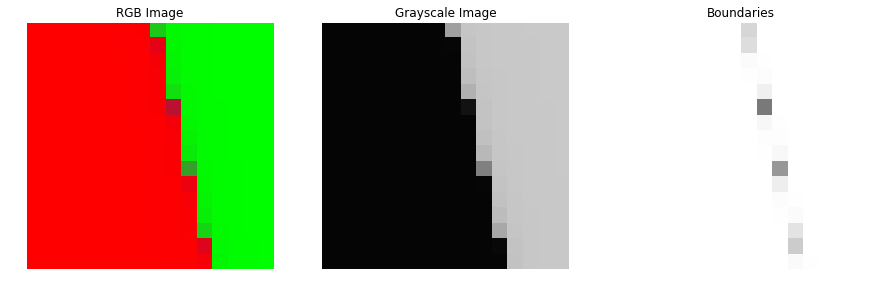

In [36]:
# Load dataset 

data_folder = 'foj_data/grayscale_lines/'

with open(data_folder + 'line_data_16_50000_grey_multicolor_noiseless_uncentered.pkl','rb') as f:
    data = pickle.load(f)

# wedges = data['wedges']
wedges_grey = data['wedges_grey']
params = data['params']
boundaries = data['boundaries']
wedges = data['wedges']


line_data = LineDataset(wedges_grey, params, boundaries, wedges)#, transform=trainTransform)
data_size = len(line_data)

print(data_size)

train_proportion = .85
# Split dataset into training and testing
train_dataset, test_dataset = torch.utils.data.random_split(line_data, [int(data_size*train_proportion), int(data_size*(1-train_proportion))], generator=torch.Generator().manual_seed(42))

# Create loaders for the training and testing data
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1000, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=500, shuffle=False) #len(test_dataset)


W,H = 16,16

img_show = 0
plt.figure(figsize=[15, 15])
plt.subplot(131)
plt.imshow(wedges[img_show,:,:].squeeze().permute(1,2,0).cpu())
plt.title('RGB Image')
plt.axis('off');
plt.subplot(132)
plt.imshow(wedges_grey[img_show,:,:].squeeze().cpu(),cmap='gray', vmin=0, vmax=1)
plt.title('Grayscale Image')
plt.axis('off');
plt.subplot(133)
plt.imshow(boundaries[img_show,:,:].squeeze().cpu(),cmap='gray', vmin=0, vmax=1)
plt.title('Boundaries')
plt.axis('off');



In [61]:
class offCenterLineNet(nn.Module):

    def __init__(self):
        super().__init__()
                
        self.conv1 = nn.Conv2d(1, 2, kernel_size=3) #64 is good
        self.conv2 = nn.Conv2d(2, 2, kernel_size=3)
#         self.conv3 = nn.Conv2d(1, 1, kernel_size=3)
#         self.conv3 = nn.Conv2d(4, 1, kernel_size=3)
#         self.conv3 = nn.Conv2d(128, 1, kernel_size=3)
        self.fc = nn.LazyLinear(3)
        self.maxpool = nn.MaxPool2d(2)
        self.avgpool = nn.AvgPool2d(2)#,stride=1)
        self.activate = nn.ReLU()
#         self.batchnorm = nn.BatchNorm2d(16)
    
    def forward(self, x):

        x = self.conv1(x)
        x = self.activate(x)
        x = self.conv2(x)
#         x = self.activate(x)
#         x = self.conv3(x)
        x = self.maxpool(x)
        x = self.avgpool(x)
        x = x.view(x.shape[0],-1)
        
        x = self.fc(x)
         
        # We're defining
        # a = - sin(theta)
        # b = cos(theta)
        # c = -cy*cos(theta)+cx*sin(theta)
        # Hence, we want to normalize the vector by 1/sqrt(a^2 + b^2)
        norm_factor = (torch.norm(x[:,:2],p=2,dim=1)).unsqueeze(1)       
        out = x/(norm_factor)#+eps)
#         print('Output shape=',x.shape)

#         out = x
        
        return out
    
model = offCenterLineNet()
model = model.to(dev)
summary(model, input_size=(1, H, W))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 2, 14, 14]              20
              ReLU-2            [-1, 2, 14, 14]               0
            Conv2d-3            [-1, 2, 12, 12]              38
         MaxPool2d-4              [-1, 2, 6, 6]               0
         AvgPool2d-5              [-1, 2, 3, 3]               0
            Linear-6                    [-1, 3]              57
Total params: 115
Trainable params: 115
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.00
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


Epoch: 1, Avg. Train Loss: 0.6603625804878944, Avg. Test Loss: 0.6266629695892334
Epoch: 2, Avg. Train Loss: 0.5894265521404355, Avg. Test Loss: 0.5715212821960449
Epoch: 3, Avg. Train Loss: 0.5286536438520565, Avg. Test Loss: 0.49993446469306946
Epoch: 4, Avg. Train Loss: 0.4427446508130362, Avg. Test Loss: 0.3917577266693115
Epoch: 5, Avg. Train Loss: 0.3566987743211347, Avg. Test Loss: 0.3351559638977051
Epoch: 6, Avg. Train Loss: 0.3053384028201879, Avg. Test Loss: 0.27737799286842346
Epoch: 7, Avg. Train Loss: 0.2557509520719218, Avg. Test Loss: 0.3898288905620575
Epoch: 8, Avg. Train Loss: 0.5054217667080635, Avg. Test Loss: 0.529272735118866
Epoch: 9, Avg. Train Loss: 0.5073338816332262, Avg. Test Loss: 0.5047097206115723
Epoch: 10, Avg. Train Loss: 0.48274005152458366, Avg. Test Loss: 0.4785251319408417
Epoch: 11, Avg. Train Loss: 0.38404107925503755, Avg. Test Loss: 0.2602853775024414
Epoch: 12, Avg. Train Loss: 0.1635086401257404, Avg. Test Loss: 0.11181928217411041
Epoch: 13

Epoch: 96, Avg. Train Loss: 0.0007672843125345575, Avg. Test Loss: 0.0007822668994776905
Epoch: 97, Avg. Train Loss: 0.0007606591977893786, Avg. Test Loss: 0.0007644547149538994
Epoch: 98, Avg. Train Loss: 0.0007482694264306406, Avg. Test Loss: 0.0007511418662033975
Epoch: 99, Avg. Train Loss: 0.0007340044682022444, Avg. Test Loss: 0.0007406917284242809
Epoch: 100, Avg. Train Loss: 0.000725801782357658, Avg. Test Loss: 0.000736924062948674
Epoch: 101, Avg. Train Loss: 0.0007159413490985888, Avg. Test Loss: 0.000727673526853323
Epoch: 102, Avg. Train Loss: 0.0007057063265292104, Avg. Test Loss: 0.0007204331923276186
Epoch: 103, Avg. Train Loss: 0.0006951638876438834, Avg. Test Loss: 0.0006996665615588427
Epoch: 104, Avg. Train Loss: 0.0006816309557274677, Avg. Test Loss: 0.0006846036412753165
Epoch: 105, Avg. Train Loss: 0.0006657987386313115, Avg. Test Loss: 0.0006738916854374111
Epoch: 106, Avg. Train Loss: 0.000643436695438225, Avg. Test Loss: 0.0006559969042427838
Epoch: 107, Avg. T

Epoch: 187, Avg. Train Loss: 0.00035816753082800395, Avg. Test Loss: 0.00037736320518888533
Epoch: 188, Avg. Train Loss: 0.0003598135047278172, Avg. Test Loss: 0.00036342773819342256
Epoch: 189, Avg. Train Loss: 0.0003549871386873514, Avg. Test Loss: 0.00036466625169850886
Epoch: 190, Avg. Train Loss: 0.0003570846706996997, Avg. Test Loss: 0.0003648290876299143
Epoch: 191, Avg. Train Loss: 0.000361161385689927, Avg. Test Loss: 0.00036418551462702453
Epoch: 192, Avg. Train Loss: 0.0003546036090864258, Avg. Test Loss: 0.00036787064163945615
Epoch: 193, Avg. Train Loss: 0.00035468355730869047, Avg. Test Loss: 0.0003629263665061444
Epoch: 194, Avg. Train Loss: 0.0003538310553521178, Avg. Test Loss: 0.00036169920349493623
Epoch: 195, Avg. Train Loss: 0.0003521746162563389, Avg. Test Loss: 0.00036071843351237476
Epoch: 196, Avg. Train Loss: 0.00035154161606590416, Avg. Test Loss: 0.0003611047868616879
Epoch: 197, Avg. Train Loss: 0.0003512677612043051, Avg. Test Loss: 0.0003622269141487777
E

Epoch: 338, Avg. Train Loss: 0.00026654930166672744, Avg. Test Loss: 0.0002693083952181041
Epoch: 339, Avg. Train Loss: 0.0002670641846380868, Avg. Test Loss: 0.00027037758263759315
Epoch: 340, Avg. Train Loss: 0.00026731640384749096, Avg. Test Loss: 0.00027674721786752343
Epoch: 341, Avg. Train Loss: 0.00026937138978229446, Avg. Test Loss: 0.0002747678372543305
Epoch: 342, Avg. Train Loss: 0.00027055949240728, Avg. Test Loss: 0.00026930065359920263
Epoch: 343, Avg. Train Loss: 0.00026860079480345945, Avg. Test Loss: 0.00026946570142172277
Epoch: 344, Avg. Train Loss: 0.00026594228713589093, Avg. Test Loss: 0.0002877934603020549
Epoch: 345, Avg. Train Loss: 0.0002667776831469044, Avg. Test Loss: 0.00027741966187022626
Epoch: 346, Avg. Train Loss: 0.0002679253717191344, Avg. Test Loss: 0.0002687986707314849
Epoch: 347, Avg. Train Loss: 0.0002656001499502075, Avg. Test Loss: 0.0002727799292188138
Epoch: 348, Avg. Train Loss: 0.0002653292846611463, Avg. Test Loss: 0.0002665119245648384
Ep

Epoch: 429, Avg. Train Loss: 0.00024325378390765466, Avg. Test Loss: 0.00024942305753938854
Epoch: 430, Avg. Train Loss: 0.00024368379164898637, Avg. Test Loss: 0.0002522219147067517
Epoch: 431, Avg. Train Loss: 0.0002433232720102032, Avg. Test Loss: 0.0002484485739842057
Epoch: 432, Avg. Train Loss: 0.00024646006864333136, Avg. Test Loss: 0.0002524235169403255
Epoch: 433, Avg. Train Loss: 0.00024443779169137827, Avg. Test Loss: 0.00026392508880235255
Epoch: 434, Avg. Train Loss: 0.00024394067931584582, Avg. Test Loss: 0.0002516502281650901
Epoch: 435, Avg. Train Loss: 0.00024302166901518006, Avg. Test Loss: 0.0002479002869222313
Epoch: 436, Avg. Train Loss: 0.00024158026627806384, Avg. Test Loss: 0.0002570901997387409
Epoch: 437, Avg. Train Loss: 0.00024258639009636936, Avg. Test Loss: 0.00024985597701743245
Epoch: 438, Avg. Train Loss: 0.00024242673392764965, Avg. Test Loss: 0.00025244776043109596
Epoch: 439, Avg. Train Loss: 0.00024359107293665062, Avg. Test Loss: 0.0002587266499176

Epoch: 519, Avg. Train Loss: 0.0002296033266628551, Avg. Test Loss: 0.00023692796821705997
Epoch: 520, Avg. Train Loss: 0.0002288014369442799, Avg. Test Loss: 0.00023563497234135866
Epoch: 521, Avg. Train Loss: 0.00022690641716783218, Avg. Test Loss: 0.0002423696278128773
Epoch: 522, Avg. Train Loss: 0.00023065695673129847, Avg. Test Loss: 0.00023450535081792623
Epoch: 523, Avg. Train Loss: 0.00023044476950227088, Avg. Test Loss: 0.0002561045694164932
Epoch: 524, Avg. Train Loss: 0.00022965686925047966, Avg. Test Loss: 0.00023785329540260136
Epoch: 525, Avg. Train Loss: 0.00023011038645690438, Avg. Test Loss: 0.0002380034711677581
Epoch: 526, Avg. Train Loss: 0.00022935733398108548, Avg. Test Loss: 0.00023756548762321472
Epoch: 527, Avg. Train Loss: 0.0002275367722938617, Avg. Test Loss: 0.0002424259582767263
Epoch: 528, Avg. Train Loss: 0.00022848413615530834, Avg. Test Loss: 0.00023791755666024983
Epoch: 529, Avg. Train Loss: 0.0002296014653713724, Avg. Test Loss: 0.00023421646619681

Epoch: 609, Avg. Train Loss: 0.00021819355301992146, Avg. Test Loss: 0.0002327883121324703
Epoch: 610, Avg. Train Loss: 0.00021803544443046543, Avg. Test Loss: 0.0002274561848025769
Epoch: 611, Avg. Train Loss: 0.0002182124386985548, Avg. Test Loss: 0.00023014315229374915
Epoch: 612, Avg. Train Loss: 0.00022145283718452637, Avg. Test Loss: 0.00023466604761779308
Epoch: 613, Avg. Train Loss: 0.00021898806254855942, Avg. Test Loss: 0.0002388337888987735
Epoch: 614, Avg. Train Loss: 0.00022010323672750316, Avg. Test Loss: 0.00023749507090542465
Epoch: 615, Avg. Train Loss: 0.00022048195201340457, Avg. Test Loss: 0.0002274354628752917
Epoch: 616, Avg. Train Loss: 0.00022044391263016436, Avg. Test Loss: 0.00022550398716703057
Epoch: 617, Avg. Train Loss: 0.000218498750338006, Avg. Test Loss: 0.00023855007020756602
Epoch: 618, Avg. Train Loss: 0.00021829931363246815, Avg. Test Loss: 0.00022598124633077532
Epoch: 619, Avg. Train Loss: 0.00021949010734652105, Avg. Test Loss: 0.0002265210059704

Epoch: 699, Avg. Train Loss: 0.00020880619812551019, Avg. Test Loss: 0.00022571157023776323
Epoch: 700, Avg. Train Loss: 0.00021180454919082222, Avg. Test Loss: 0.00022357866691891104
Epoch: 701, Avg. Train Loss: 0.0002114507829943715, Avg. Test Loss: 0.00022710546909365803
Epoch: 702, Avg. Train Loss: 0.00021077730242152114, Avg. Test Loss: 0.00022186418937053531
Epoch: 703, Avg. Train Loss: 0.0002104488159475718, Avg. Test Loss: 0.00022648471349384636
Epoch: 704, Avg. Train Loss: 0.00020938403132848095, Avg. Test Loss: 0.00022852564870845526
Epoch: 705, Avg. Train Loss: 0.00020977426902391016, Avg. Test Loss: 0.00021940076840110123
Epoch: 706, Avg. Train Loss: 0.00020910283282594107, Avg. Test Loss: 0.00022100111527834088
Epoch: 707, Avg. Train Loss: 0.00021243830100459935, Avg. Test Loss: 0.00022829898807685822
Epoch: 708, Avg. Train Loss: 0.00020807140796488629, Avg. Test Loss: 0.00022646882280241698
Epoch: 709, Avg. Train Loss: 0.0002100718580592467, Avg. Test Loss: 0.000219941459

Epoch: 789, Avg. Train Loss: 0.0001977404334506583, Avg. Test Loss: 0.0002114221133524552
Epoch: 790, Avg. Train Loss: 0.00019884812456100832, Avg. Test Loss: 0.00020627016783691943
Epoch: 791, Avg. Train Loss: 0.00019621992954811039, Avg. Test Loss: 0.00020593139925040305
Epoch: 792, Avg. Train Loss: 0.00019819122268060265, Avg. Test Loss: 0.00021030993957538158
Epoch: 793, Avg. Train Loss: 0.00019542659906302253, Avg. Test Loss: 0.00020334777946118265
Epoch: 794, Avg. Train Loss: 0.00019516636140991088, Avg. Test Loss: 0.00020535367366392165
Epoch: 795, Avg. Train Loss: 0.00019787124535447897, Avg. Test Loss: 0.00021267362171784043
Epoch: 796, Avg. Train Loss: 0.00019486566909404776, Avg. Test Loss: 0.00020455583580769598
Epoch: 797, Avg. Train Loss: 0.00019493163698677753, Avg. Test Loss: 0.0002034475328400731
Epoch: 798, Avg. Train Loss: 0.0001959355932465473, Avg. Test Loss: 0.0002064513391815126
Epoch: 799, Avg. Train Loss: 0.0001947193289430119, Avg. Test Loss: 0.000204593467060

Epoch: 879, Avg. Train Loss: 0.0001790679305613171, Avg. Test Loss: 0.0001876262977020815
Epoch: 880, Avg. Train Loss: 0.00018141880634154172, Avg. Test Loss: 0.00019414951384533197
Epoch: 881, Avg. Train Loss: 0.0001826082193157311, Avg. Test Loss: 0.00018780403479468077
Epoch: 882, Avg. Train Loss: 0.00018187105110142553, Avg. Test Loss: 0.0001912807929329574
Epoch: 883, Avg. Train Loss: 0.00018160003217121282, Avg. Test Loss: 0.00018781273683998734
Epoch: 884, Avg. Train Loss: 0.0001785124010449752, Avg. Test Loss: 0.00018644875672180206
Epoch: 885, Avg. Train Loss: 0.0001803120360628507, Avg. Test Loss: 0.00019429167150519788
Epoch: 886, Avg. Train Loss: 0.0001797234838514394, Avg. Test Loss: 0.00018697898485697806
Epoch: 887, Avg. Train Loss: 0.00017694249948172635, Avg. Test Loss: 0.00018810280016623437
Epoch: 888, Avg. Train Loss: 0.00017891080608743048, Avg. Test Loss: 0.0001906733523355797
Epoch: 889, Avg. Train Loss: 0.00017927384929904757, Avg. Test Loss: 0.00018535865820012

Epoch: 969, Avg. Train Loss: 0.0001604869957677587, Avg. Test Loss: 0.00016874294669833034
Epoch: 970, Avg. Train Loss: 0.00016079552310551407, Avg. Test Loss: 0.00016864051576703787
Epoch: 971, Avg. Train Loss: 0.0001590968851476561, Avg. Test Loss: 0.00016805857012514025
Epoch: 972, Avg. Train Loss: 0.00015991469973774064, Avg. Test Loss: 0.00017007955466397107
Epoch: 973, Avg. Train Loss: 0.00015889893003013852, Avg. Test Loss: 0.00016869042883627117
Epoch: 974, Avg. Train Loss: 0.0001606205194040613, Avg. Test Loss: 0.00017128388572018594
Epoch: 975, Avg. Train Loss: 0.00015889958283582398, Avg. Test Loss: 0.00016501233039889485
Epoch: 976, Avg. Train Loss: 0.00015953644605212693, Avg. Test Loss: 0.0001753228425513953
Epoch: 977, Avg. Train Loss: 0.0001601169598532494, Avg. Test Loss: 0.0001716297265375033
Epoch: 978, Avg. Train Loss: 0.00015897458983682702, Avg. Test Loss: 0.00017449761799070984
Epoch: 979, Avg. Train Loss: 0.0001612539822100337, Avg. Test Loss: 0.0001737817656248

Epoch: 1058, Avg. Train Loss: 0.00015124460637601914, Avg. Test Loss: 0.0001600788236828521
Epoch: 1059, Avg. Train Loss: 0.00014886208525642232, Avg. Test Loss: 0.0001554488844703883
Epoch: 1060, Avg. Train Loss: 0.0001499608861618177, Avg. Test Loss: 0.00015435511886607856
Epoch: 1061, Avg. Train Loss: 0.00015244159852912607, Avg. Test Loss: 0.00015373664791695774
Epoch: 1062, Avg. Train Loss: 0.00014948022895665882, Avg. Test Loss: 0.00015398561663459986
Epoch: 1063, Avg. Train Loss: 0.00014774685050090126, Avg. Test Loss: 0.00015696266200393438
Epoch: 1064, Avg. Train Loss: 0.00014802423166381844, Avg. Test Loss: 0.00017086164734791964
Epoch: 1065, Avg. Train Loss: 0.0001502333700976356, Avg. Test Loss: 0.0001560643286211416
Epoch: 1066, Avg. Train Loss: 0.00014971841910453297, Avg. Test Loss: 0.0001590355677763
Epoch: 1067, Avg. Train Loss: 0.0001488496792410652, Avg. Test Loss: 0.00015616485325153917
Epoch: 1068, Avg. Train Loss: 0.00014881703117320877, Avg. Test Loss: 0.00015314

Epoch: 1147, Avg. Train Loss: 0.00014545310892402952, Avg. Test Loss: 0.00015416413953062147
Epoch: 1148, Avg. Train Loss: 0.00014447326078837695, Avg. Test Loss: 0.00015372417692560703
Epoch: 1149, Avg. Train Loss: 0.00014336076517708514, Avg. Test Loss: 0.0001530875888420269
Epoch: 1150, Avg. Train Loss: 0.00014635138951382752, Avg. Test Loss: 0.000149672050611116
Epoch: 1151, Avg. Train Loss: 0.00014554383842339523, Avg. Test Loss: 0.00015141020412556827
Epoch: 1152, Avg. Train Loss: 0.00014296270802692878, Avg. Test Loss: 0.00014964162255637348
Epoch: 1153, Avg. Train Loss: 0.0001446163247279866, Avg. Test Loss: 0.0001484412932768464
Epoch: 1154, Avg. Train Loss: 0.00014395530702448776, Avg. Test Loss: 0.00015067405183799565
Epoch: 1155, Avg. Train Loss: 0.00014639969713455282, Avg. Test Loss: 0.00015035696560516953
Epoch: 1156, Avg. Train Loss: 0.00014275055260906474, Avg. Test Loss: 0.00015658439951948822
Epoch: 1157, Avg. Train Loss: 0.00014385396071850474, Avg. Test Loss: 0.000

Epoch: 1236, Avg. Train Loss: 0.00014099459194978915, Avg. Test Loss: 0.0001456538011552766
Epoch: 1237, Avg. Train Loss: 0.0001403756876581695, Avg. Test Loss: 0.00014529351028613746
Epoch: 1238, Avg. Train Loss: 0.0001423923983333394, Avg. Test Loss: 0.00014442039537243545
Epoch: 1239, Avg. Train Loss: 0.00014087781418374804, Avg. Test Loss: 0.00014731545525137335
Epoch: 1240, Avg. Train Loss: 0.00014211511751095396, Avg. Test Loss: 0.00014668617222923785
Epoch: 1241, Avg. Train Loss: 0.00014054800805413749, Avg. Test Loss: 0.00014492298942059278
Epoch: 1242, Avg. Train Loss: 0.00014043608369024166, Avg. Test Loss: 0.000146413134643808
Epoch: 1243, Avg. Train Loss: 0.00013998082059240617, Avg. Test Loss: 0.00015177513705566525
Epoch: 1244, Avg. Train Loss: 0.0001406753760610902, Avg. Test Loss: 0.0001470906427130103
Epoch: 1245, Avg. Train Loss: 0.0001395312330799264, Avg. Test Loss: 0.0001498902274761349
Epoch: 1246, Avg. Train Loss: 0.0001398135300828577, Avg. Test Loss: 0.00014833

Epoch: 1325, Avg. Train Loss: 0.00013813871699439492, Avg. Test Loss: 0.00014941816334612668
Epoch: 1326, Avg. Train Loss: 0.0001393254202666021, Avg. Test Loss: 0.00014531260239891708
Epoch: 1327, Avg. Train Loss: 0.00013865171769244033, Avg. Test Loss: 0.00014429284783545882
Epoch: 1328, Avg. Train Loss: 0.00013815633327223707, Avg. Test Loss: 0.00014267161895986646
Epoch: 1329, Avg. Train Loss: 0.00013869657718608978, Avg. Test Loss: 0.00014598121924791485
Epoch: 1330, Avg. Train Loss: 0.00013950969776826326, Avg. Test Loss: 0.00014428999566007406
Epoch: 1331, Avg. Train Loss: 0.0001390529515595327, Avg. Test Loss: 0.00014440214727073908
Epoch: 1332, Avg. Train Loss: 0.00013925427764513378, Avg. Test Loss: 0.00014493260823655874
Epoch: 1333, Avg. Train Loss: 0.00013765901344730844, Avg. Test Loss: 0.00014335177547764033
Epoch: 1334, Avg. Train Loss: 0.00013775015886071637, Avg. Test Loss: 0.00014385963731911033
Epoch: 1335, Avg. Train Loss: 0.00014116005365585172, Avg. Test Loss: 0.

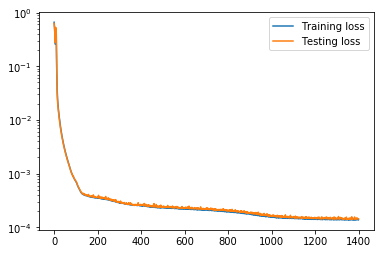

In [62]:
# Now let's train the initial network 

model = offCenterLineNet()
model = model.to(dev)
model.apply(weights_init_uniform)

model.train();

optimizer = torch.optim.Adam(model.parameters(),lr=.01) 
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.1)

n_epochs = 1400

mse_loss = nn.MSELoss()
ce_loss = nn.CrossEntropyLoss()

for epoch in range(0,n_epochs):  # loop over the dataset multiple times
    
    if epoch == 0:
        train_loss_over_time = [] # to track the loss as the network trains
        test_loss_over_time = []
        
    if epoch == 10:
        optimizer = torch.optim.Adam(model.parameters(),lr=.002) 
        
    running_loss = 0
    num_batches = 0
    
    for batch_i, data in enumerate(train_loader):
        
        # get the input images and their corresponding labels
        num_batches += 1

        inputs, output_gt, _, _ = data
        inputs, output_gt = inputs.to(dev), output_gt.to(dev)
        
        # zero the parameter (weight) gradients
        optimizer.zero_grad()
        
        # forward pass to get outputs
        output_line_params = model(inputs)
        

        # make the ground truth
        c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
        gt_line_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0]),c),dim=1)
        
        # calculate the loss
#         print(output_line_params[:,:,0,50])
        
        loss = mse_loss(output_line_params,gt_line_params)
        
        # backward pass to calculate the parameter gradients
        loss.backward()

        # update the parameters
        optimizer.step()

        # to convert loss into a scalar and add it to running_loss, we use .item()
        running_loss += loss.item()
      

#     scheduler.step()
    
    # Calculate test data loss after each epoch
    with torch.no_grad():
        test_loss = 0
        num_batches_test = 0
        for batch_i, data in enumerate(test_loader):
            num_batches_test += 1

            # Add code here
            inputs, output_gt, _, _ = data
            inputs, output_gt = inputs.to(dev), output_gt.to(dev)


            # zero the parameter (weight) gradients
            optimizer.zero_grad()

            # forward pass to get outputs
            output_line_params = model(inputs)

            # make the ground truth
            c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
            gt_line_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0]),c),dim=1)
    

            # calculate the loss
    #         print(output_line_params[:,:,0,50])

            loss = mse_loss(output_line_params,gt_line_params)
            
            test_loss += loss
                    
        test_loss_over_time.append(test_loss/num_batches_test)

    # Calculate model loss:
    avg_loss = running_loss/num_batches
    train_loss_over_time.append(avg_loss)
    
#     print('Epoch: {}, Avg. Train Loss: {},'.format(epoch + 1, train_loss_over_time[-1]))


    print('Epoch: {}, Avg. Train Loss: {}, Avg. Test Loss: {}'.format(epoch + 1, train_loss_over_time[-1], test_loss_over_time[-1]))
    
print('Finished Training')

plt.figure()
plt.semilogy(np.arange(0,n_epochs),train_loss_over_time[0:])
plt.semilogy(np.arange(0,n_epochs),test_loss_over_time[0:])
plt.legend(['Training loss', 'Testing loss'])

[tensor(0.5064), tensor(0.5348), tensor(0.5896), tensor(0.5276), tensor(0.5186), tensor(0.6113), tensor(0.5879), tensor(0.5649), tensor(0.5537), tensor(0.5687), tensor(0.5636), tensor(0.5550), tensor(0.5539), tensor(0.5169), tensor(0.5258)]


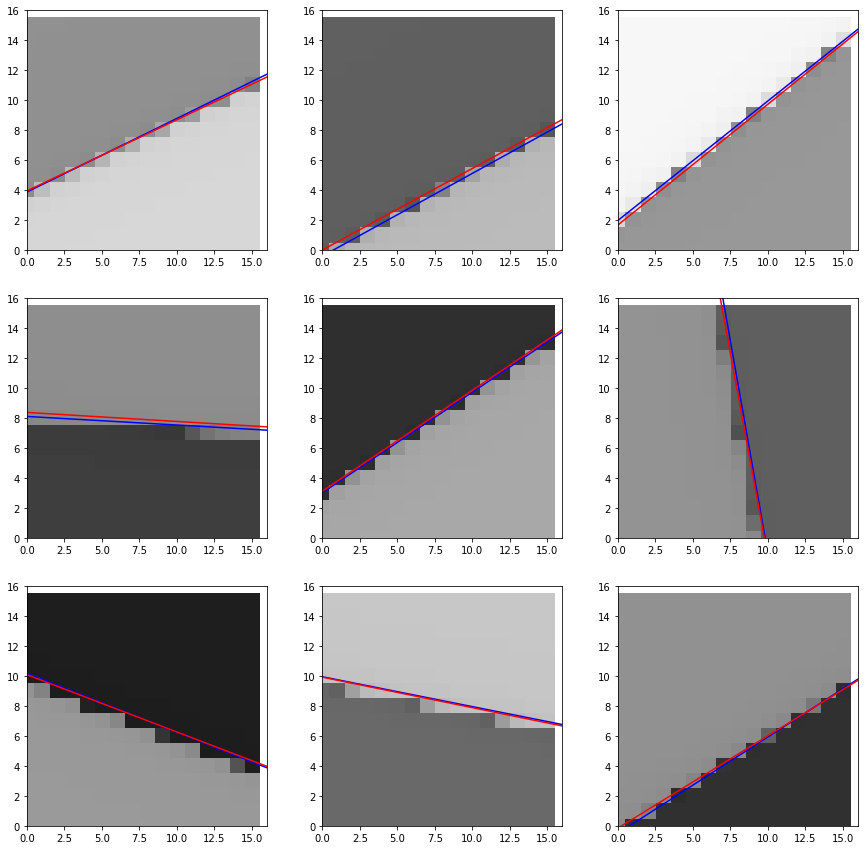

In [60]:
# Plot the Results

model.eval();

ang_loss_all = []

for batch_i, data in enumerate(test_loader):
    # get the input images and their corresponding labels
    inputs, output_gt, _, _ = data
    inputs, output_gt = inputs.to(dev), output_gt.to(dev)
    

    # forward pass to get outputs
    outputs = model(inputs).squeeze().detach().cpu()
    
    gt = output_gt.cpu().squeeze()
    
    c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
    angle_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0]),c),axis=1).detach().cpu()
  
    # Calculate angular loss
    ang_loss = torch.mean(torch.abs(torch.rad2deg(torch.atan2(-angle_params[:,0]*outputs[:,1] + angle_params[:,1]*outputs[:,0]
                                         ,angle_params[:,1]*outputs[:,1]+angle_params[:,0]*outputs[:,0]).cpu())))

    ang_loss_all.append(ang_loss)

    
print(ang_loss_all)

plt.figure(figsize=[15, 15])

for ii in range(9):
    
    plt.subplot(3,3,ii+1)
    plt.imshow(inputs[ii].cpu().squeeze(),cmap='gray', vmin=0, vmax=1)
    
    # Plot the ground truth lines
    x_sample = torch.linspace(-1,1,inputs.shape[-1])
    y_sample = -angle_params[ii,0]/angle_params[ii,1]*x_sample - angle_params[ii,2]/angle_params[ii,1]
    
    plt.plot(x_sample*W/2+W/2,y_sample*W/2+W/2,'b')
    plt.xlim([0,W])
    plt.ylim(([0,W]))
    
    # Plot the estimated lines
    y_est = -outputs[ii,0]/outputs[ii,1]*x_sample - outputs[ii,2]/outputs[ii,1]
    plt.plot(x_sample*W/2+W/2,y_est*W/2+W/2,'r')






## train on noisy, multicolor data

100000


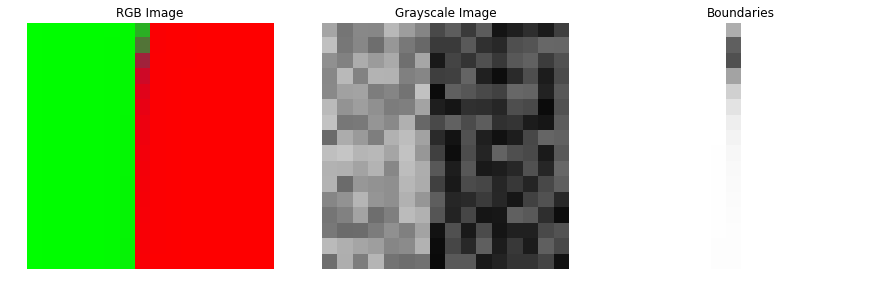

In [76]:
# Load dataset 

data_folder = 'foj_data/grayscale_lines/'

with open(data_folder + 'line_data_16_100000_grey_multicolor_noise_random_uncentered.pkl','rb') as f:
    data = pickle.load(f)

# wedges = data['wedges']
wedges_grey = data['wedges_grey']
params = data['params']
boundaries = data['boundaries']
wedges = data['wedges']


line_data = LineDataset(wedges_grey, params, boundaries, wedges)#, transform=trainTransform)
data_size = len(line_data)

print(data_size)

train_proportion = .85
# Split dataset into training and testing
train_dataset, test_dataset = torch.utils.data.random_split(line_data, [int(data_size*train_proportion), int(data_size*(1-train_proportion))], generator=torch.Generator().manual_seed(42))

# Create loaders for the training and testing data
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1000, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=500, shuffle=False) #len(test_dataset)


W,H = 16,16

img_show = 0
plt.figure(figsize=[15, 15])
plt.subplot(131)
plt.imshow(wedges[img_show,:,:].squeeze().permute(1,2,0).cpu())
plt.title('RGB Image')
plt.axis('off');
plt.subplot(132)
plt.imshow(wedges_grey[img_show,:,:].squeeze().cpu(),cmap='gray', vmin=0, vmax=1)
plt.title('Grayscale Image')
plt.axis('off');
plt.subplot(133)
plt.imshow(boundaries[img_show,:,:].squeeze().cpu(),cmap='gray', vmin=0, vmax=1)
plt.title('Boundaries')
plt.axis('off');


In [87]:
class offCenterLineNet(nn.Module):

    def __init__(self):
        super().__init__()
                
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3) #64 is good
        self.conv2 = nn.Conv2d(8, 8, kernel_size=3)
        self.conv3 = nn.Conv2d(8, 1, kernel_size=3)
#         self.conv3 = nn.Conv2d(4, 1, kernel_size=3)
#         self.conv3 = nn.Conv2d(128, 1, kernel_size=3)
        self.fc = nn.LazyLinear(3)
        self.maxpool = nn.MaxPool2d(2)
        self.avgpool = nn.AvgPool2d(2)#,stride=1)
        self.activate = nn.ReLU()
#         self.batchnorm = nn.BatchNorm2d(16)
    
    def forward(self, x):

        x = self.conv1(x)
        x = self.activate(x)
        x = self.conv2(x)
        x = self.activate(x)
        x = self.conv3(x)
        x = self.maxpool(x)
#         x = self.avgpool(x)
        x = x.view(x.shape[0],-1)
        
        x = self.fc(x)
         
        # We're defining
        # a = - sin(theta)
        # b = cos(theta)
        # c = -cy*cos(theta)+cx*sin(theta)
        # Hence, we want to normalize the vector by 1/sqrt(a^2 + b^2)
        norm_factor = (torch.norm(x[:,:2],p=2,dim=1)).unsqueeze(1)       
        out = x/(norm_factor)#+eps)
#         print('Output shape=',x.shape)

#         out = x
        
        return out
    
model = offCenterLineNet()
model = model.to(dev)
summary(model, input_size=(1, H, W))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 14, 14]              80
              ReLU-2            [-1, 8, 14, 14]               0
            Conv2d-3            [-1, 8, 12, 12]             584
              ReLU-4            [-1, 8, 12, 12]               0
            Conv2d-5            [-1, 1, 10, 10]              73
         MaxPool2d-6              [-1, 1, 5, 5]               0
            Linear-7                    [-1, 3]              78
Total params: 815
Trainable params: 815
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.00
Estimated Total Size (MB): 0.05
----------------------------------------------------------------


Epoch: 1, Avg. Train Loss: 0.7034099436858121, Avg. Test Loss: 0.6913908123970032
Epoch: 2, Avg. Train Loss: 0.6755715559510623, Avg. Test Loss: 0.6603599786758423
Epoch: 3, Avg. Train Loss: 0.6443942701115327, Avg. Test Loss: 0.6302202939987183
Epoch: 4, Avg. Train Loss: 0.6165621953852036, Avg. Test Loss: 0.6051456928253174
Epoch: 5, Avg. Train Loss: 0.5942968333468718, Avg. Test Loss: 0.585791826248169
Epoch: 6, Avg. Train Loss: 0.5773453502094045, Avg. Test Loss: 0.5711895823478699
Epoch: 7, Avg. Train Loss: 0.5644639071296244, Avg. Test Loss: 0.5601245760917664
Epoch: 8, Avg. Train Loss: 0.5545233775587642, Avg. Test Loss: 0.54685378074646
Epoch: 9, Avg. Train Loss: 0.5407782919266645, Avg. Test Loss: 0.5422813296318054
Epoch: 10, Avg. Train Loss: 0.533346871768727, Avg. Test Loss: 0.5346519351005554
Epoch: 11, Avg. Train Loss: 0.2926804872120128, Avg. Test Loss: 0.19699250161647797
Epoch: 12, Avg. Train Loss: 0.17118162915987126, Avg. Test Loss: 0.4785272777080536
Epoch: 13, Avg.

Epoch: 97, Avg. Train Loss: 0.006877151449375293, Avg. Test Loss: 0.006966766901314259
Epoch: 98, Avg. Train Loss: 0.006752995861803784, Avg. Test Loss: 0.006846577860414982
Epoch: 99, Avg. Train Loss: 0.006637983818483704, Avg. Test Loss: 0.006733075249940157
Epoch: 100, Avg. Train Loss: 0.00653133905657074, Avg. Test Loss: 0.00662595359608531
Epoch: 101, Avg. Train Loss: 0.006431362361592405, Avg. Test Loss: 0.006530491169542074
Epoch: 102, Avg. Train Loss: 0.006335897639612941, Avg. Test Loss: 0.006430727895349264
Epoch: 103, Avg. Train Loss: 0.006244544553406098, Avg. Test Loss: 0.006343131419271231
Epoch: 104, Avg. Train Loss: 0.006158507456455161, Avg. Test Loss: 0.006259688641875982
Epoch: 105, Avg. Train Loss: 0.00607558194657459, Avg. Test Loss: 0.0061773802153766155
Epoch: 106, Avg. Train Loss: 0.005997593361226951, Avg. Test Loss: 0.0060964119620621204
Epoch: 107, Avg. Train Loss: 0.00592134928002077, Avg. Test Loss: 0.006020873785018921
Epoch: 108, Avg. Train Loss: 0.005847

Epoch: 190, Avg. Train Loss: 0.002201377195032204, Avg. Test Loss: 0.0022268323227763176
Epoch: 191, Avg. Train Loss: 0.002192118952927344, Avg. Test Loss: 0.0022246178705245256
Epoch: 192, Avg. Train Loss: 0.0021669688114129447, Avg. Test Loss: 0.0021835584193468094
Epoch: 193, Avg. Train Loss: 0.0021487529512823505, Avg. Test Loss: 0.002170127583667636
Epoch: 194, Avg. Train Loss: 0.0021305139108067925, Avg. Test Loss: 0.0021480268333107233
Epoch: 195, Avg. Train Loss: 0.0021070612471222002, Avg. Test Loss: 0.002130481880158186
Epoch: 196, Avg. Train Loss: 0.002092783713220235, Avg. Test Loss: 0.0021172817796468735
Epoch: 197, Avg. Train Loss: 0.0020795603460796617, Avg. Test Loss: 0.0021209511905908585
Epoch: 198, Avg. Train Loss: 0.0020656171569819835, Avg. Test Loss: 0.0020891346503049135
Epoch: 199, Avg. Train Loss: 0.0020404668442685816, Avg. Test Loss: 0.00206012767739594
Epoch: 200, Avg. Train Loss: 0.002025669116033789, Avg. Test Loss: 0.002044901717454195
Epoch: 201, Avg. Tr

Epoch: 299, Avg. Train Loss: 0.0016880836269325193, Avg. Test Loss: 0.0017308839596807957
Epoch: 300, Avg. Train Loss: 0.0016947507570662043, Avg. Test Loss: 0.0017089340835809708
Epoch: 301, Avg. Train Loss: 0.0016808323219747229, Avg. Test Loss: 0.0017279472667723894
Epoch: 302, Avg. Train Loss: 0.0016926321050371317, Avg. Test Loss: 0.0017267323564738035
Epoch: 303, Avg. Train Loss: 0.0016788518248016344, Avg. Test Loss: 0.0017162656877189875
Epoch: 304, Avg. Train Loss: 0.001686593802536235, Avg. Test Loss: 0.0017234233673661947
Epoch: 305, Avg. Train Loss: 0.0016893355203244616, Avg. Test Loss: 0.0017159685958176851
Epoch: 306, Avg. Train Loss: 0.0016767046633450423, Avg. Test Loss: 0.001701900502666831
Epoch: 307, Avg. Train Loss: 0.0016747999703511595, Avg. Test Loss: 0.001706756534986198
Epoch: 308, Avg. Train Loss: 0.0016752038342768656, Avg. Test Loss: 0.0017285107169300318
Epoch: 309, Avg. Train Loss: 0.0016780923161765233, Avg. Test Loss: 0.0017074095085263252
Epoch: 310, A

Epoch: 391, Avg. Train Loss: 0.0005474746857276734, Avg. Test Loss: 0.0005516225355677307
Epoch: 392, Avg. Train Loss: 0.0005471891045625158, Avg. Test Loss: 0.0005495095974765718
Epoch: 393, Avg. Train Loss: 0.0005514152539784418, Avg. Test Loss: 0.000543903443031013
Epoch: 394, Avg. Train Loss: 0.0005403366035727017, Avg. Test Loss: 0.0005426252027973533
Epoch: 395, Avg. Train Loss: 0.0005351089875843814, Avg. Test Loss: 0.00053162791300565
Epoch: 396, Avg. Train Loss: 0.0005449213666211375, Avg. Test Loss: 0.0005354539025574923
Epoch: 397, Avg. Train Loss: 0.0005372596825883888, Avg. Test Loss: 0.000526112737134099
Epoch: 398, Avg. Train Loss: 0.0005308291220845764, Avg. Test Loss: 0.0005262745544314384
Epoch: 399, Avg. Train Loss: 0.0005289983761031181, Avg. Test Loss: 0.0005256362492218614
Epoch: 400, Avg. Train Loss: 0.0005270533027428695, Avg. Test Loss: 0.0005238255253061652
Epoch: 401, Avg. Train Loss: 0.0005340933080707841, Avg. Test Loss: 0.0005181888118386269
Epoch: 402, Av

Epoch: 483, Avg. Train Loss: 0.0004739085277405513, Avg. Test Loss: 0.0004644349683076143
Epoch: 484, Avg. Train Loss: 0.0004749506342169993, Avg. Test Loss: 0.0004689241177402437
Epoch: 485, Avg. Train Loss: 0.00047935826929888743, Avg. Test Loss: 0.00047007648390717804
Epoch: 486, Avg. Train Loss: 0.0004718729298260501, Avg. Test Loss: 0.0004673282674048096
Epoch: 487, Avg. Train Loss: 0.00047280254828579283, Avg. Test Loss: 0.00047014662413857877
Epoch: 488, Avg. Train Loss: 0.00047492072917521, Avg. Test Loss: 0.0004624943539965898
Epoch: 489, Avg. Train Loss: 0.00046912390800357305, Avg. Test Loss: 0.00046601981739513576
Epoch: 490, Avg. Train Loss: 0.0004751401991062962, Avg. Test Loss: 0.00046270430902950466
Epoch: 491, Avg. Train Loss: 0.0004674616523141808, Avg. Test Loss: 0.00047454607556574047
Epoch: 492, Avg. Train Loss: 0.00047484620111337044, Avg. Test Loss: 0.00046640000073239207
Epoch: 493, Avg. Train Loss: 0.00047265041126486133, Avg. Test Loss: 0.0004696320102084428
E

Epoch: 574, Avg. Train Loss: 0.00047331978669664, Avg. Test Loss: 0.00045899118413217366
Epoch: 575, Avg. Train Loss: 0.00045259342124849994, Avg. Test Loss: 0.0004617566883098334
Epoch: 576, Avg. Train Loss: 0.0004541151941178695, Avg. Test Loss: 0.0004515773616731167
Epoch: 577, Avg. Train Loss: 0.0004627011380815769, Avg. Test Loss: 0.00045600271550938487
Epoch: 578, Avg. Train Loss: 0.0004548502048504922, Avg. Test Loss: 0.00045986147597432137
Epoch: 579, Avg. Train Loss: 0.00045493996448760086, Avg. Test Loss: 0.00047577431541867554
Epoch: 580, Avg. Train Loss: 0.0004650957618757863, Avg. Test Loss: 0.0004519739013630897
Epoch: 581, Avg. Train Loss: 0.00045920072349391, Avg. Test Loss: 0.00046302491682581604
Epoch: 582, Avg. Train Loss: 0.000472668612800429, Avg. Test Loss: 0.00045841632527299225
Epoch: 583, Avg. Train Loss: 0.00045842177522204377, Avg. Test Loss: 0.0004612787743099034
Epoch: 584, Avg. Train Loss: 0.000452690281535444, Avg. Test Loss: 0.0004625042784027755
Epoch: 

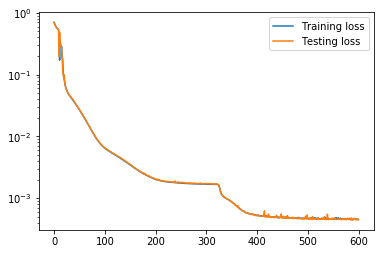

In [91]:
# Now let's train the initial network 

model = offCenterLineNet()
model = model.to(dev)
model.apply(weights_init_uniform)

model.train();

optimizer = torch.optim.Adam(model.parameters(),lr=.01) 
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.1)

n_epochs = 600

mse_loss = nn.MSELoss()
ce_loss = nn.CrossEntropyLoss()

for epoch in range(0,n_epochs):  # loop over the dataset multiple times
    
    if epoch == 0:
        train_loss_over_time = [] # to track the loss as the network trains
        test_loss_over_time = []
        
    if epoch == 10:
        optimizer = torch.optim.Adam(model.parameters(),lr=.002) 
        
    running_loss = 0
    num_batches = 0
    
    for batch_i, data in enumerate(train_loader):
        
        # get the input images and their corresponding labels
        num_batches += 1

        inputs, output_gt, _, _ = data
        inputs, output_gt = inputs.to(dev), output_gt.to(dev)
        
        # zero the parameter (weight) gradients
        optimizer.zero_grad()
        
        # forward pass to get outputs
        output_line_params = model(inputs)
        

        # make the ground truth
        c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
        gt_line_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0]),c),dim=1)
        
        # calculate the loss
#         print(output_line_params[:,:,0,50])
        
        loss = mse_loss(output_line_params,gt_line_params)
        
        # backward pass to calculate the parameter gradients
        loss.backward()

        # update the parameters
        optimizer.step()

        # to convert loss into a scalar and add it to running_loss, we use .item()
        running_loss += loss.item()
      

#     scheduler.step()
    
    # Calculate test data loss after each epoch
    with torch.no_grad():
        test_loss = 0
        num_batches_test = 0
        for batch_i, data in enumerate(test_loader):
            num_batches_test += 1

            # Add code here
            inputs, output_gt, _, _ = data
            inputs, output_gt = inputs.to(dev), output_gt.to(dev)


            # zero the parameter (weight) gradients
            optimizer.zero_grad()

            # forward pass to get outputs
            output_line_params = model(inputs)

            # make the ground truth
            c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
            gt_line_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0]),c),dim=1)
    

            # calculate the loss
    #         print(output_line_params[:,:,0,50])

            loss = mse_loss(output_line_params,gt_line_params)
            
            test_loss += loss
                    
        test_loss_over_time.append(test_loss/num_batches_test)

    # Calculate model loss:
    avg_loss = running_loss/num_batches
    train_loss_over_time.append(avg_loss)
    
#     print('Epoch: {}, Avg. Train Loss: {},'.format(epoch + 1, train_loss_over_time[-1]))


    print('Epoch: {}, Avg. Train Loss: {}, Avg. Test Loss: {}'.format(epoch + 1, train_loss_over_time[-1], test_loss_over_time[-1]))
    
print('Finished Training')

plt.figure()
plt.semilogy(np.arange(0,n_epochs),train_loss_over_time[0:])
plt.semilogy(np.arange(0,n_epochs),test_loss_over_time[0:])
plt.legend(['Training loss', 'Testing loss'])

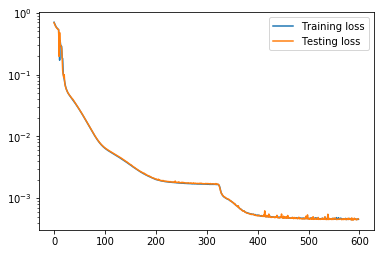

In [92]:
plt.figure()
plt.semilogy(np.arange(0,epoch),train_loss_over_time[:epoch])
plt.semilogy(np.arange(0,epoch),test_loss_over_time[:epoch])
plt.legend(['Training loss', 'Testing loss'])

[tensor(1.1464), tensor(1.1157), tensor(1.1484), tensor(1.1136), tensor(1.1034), tensor(1.1614), tensor(1.1369), tensor(1.1525), tensor(1.2298), tensor(1.2178), tensor(1.0511), tensor(1.1598), tensor(1.0701), tensor(1.1556), tensor(1.1116), tensor(1.1793), tensor(1.1710), tensor(1.1910), tensor(1.1800), tensor(1.0953), tensor(1.1461), tensor(1.1578), tensor(1.1888), tensor(1.1427), tensor(1.2122), tensor(1.0976), tensor(1.1272), tensor(1.2407), tensor(1.1588), tensor(1.1522)]


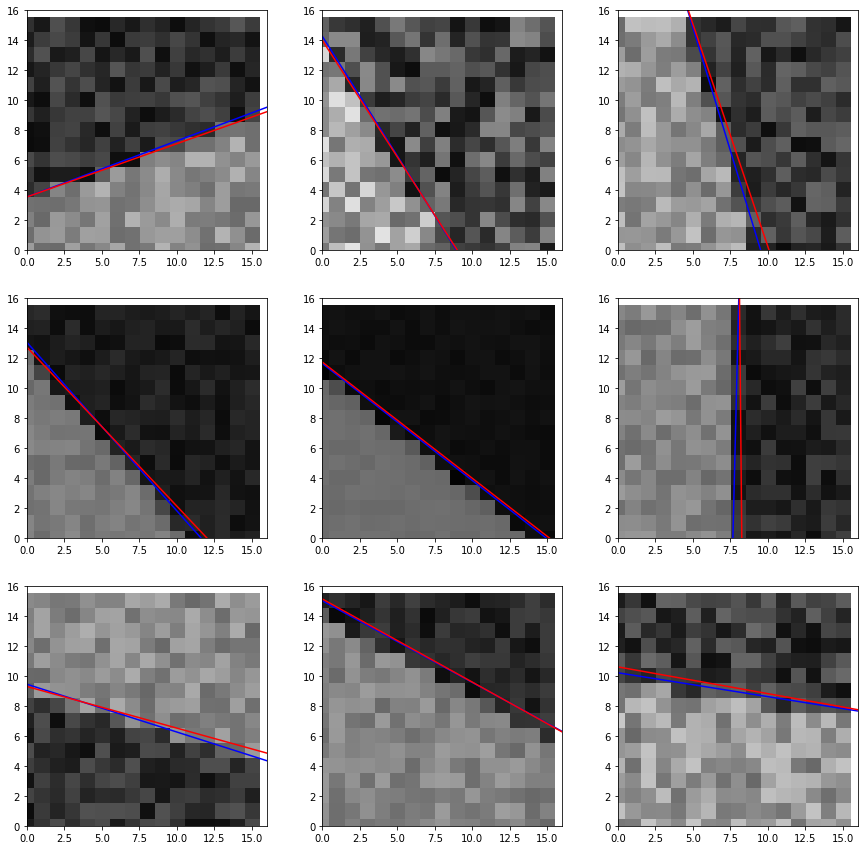

In [93]:
# Plot the Results

model.eval();

ang_loss_all = []

for batch_i, data in enumerate(test_loader):
    # get the input images and their corresponding labels
    inputs, output_gt, _, _ = data
    inputs, output_gt = inputs.to(dev), output_gt.to(dev)
    

    # forward pass to get outputs
    outputs = model(inputs).squeeze().detach().cpu()
    
    gt = output_gt.cpu().squeeze()
    
    c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
    angle_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0]),c),axis=1).detach().cpu()
  
    # Calculate angular loss
    ang_loss = torch.mean(torch.abs(torch.rad2deg(torch.atan2(-angle_params[:,0]*outputs[:,1] + angle_params[:,1]*outputs[:,0]
                                         ,angle_params[:,1]*outputs[:,1]+angle_params[:,0]*outputs[:,0]).cpu())))

    ang_loss_all.append(ang_loss)

    
print(ang_loss_all)

plt.figure(figsize=[15, 15])

for ii in range(9):
    
    plt.subplot(3,3,ii+1)
    plt.imshow(inputs[ii].cpu().squeeze(),cmap='gray', vmin=0, vmax=1)
    
    # Plot the ground truth lines
    x_sample = torch.linspace(-1,1,inputs.shape[-1])
    y_sample = -angle_params[ii,0]/angle_params[ii,1]*x_sample - angle_params[ii,2]/angle_params[ii,1]
    
    plt.plot(x_sample*W/2+W/2,y_sample*W/2+W/2,'b')
    plt.xlim([0,W])
    plt.ylim(([0,W]))
    
    # Plot the estimated lines
    y_est = -outputs[ii,0]/outputs[ii,1]*x_sample - outputs[ii,2]/outputs[ii,1]
    plt.plot(x_sample*W/2+W/2,y_est*W/2+W/2,'r')







# 8x8

50000


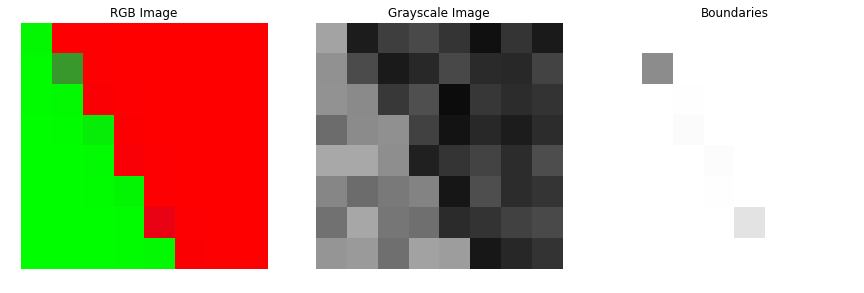

In [211]:
# Load dataset 

data_folder = 'foj_data/grayscale_lines/'

with open(data_folder + 'line_data_8_50000_grey_bicolor_noise_random_uncentered.pkl','rb') as f:
    data = pickle.load(f)

# wedges = data['wedges']
wedges_grey = data['wedges_grey']
params = data['params']
boundaries = data['boundaries']
wedges = data['wedges']


line_data = LineDataset(wedges_grey, params, boundaries, wedges)#, transform=trainTransform)
data_size = len(line_data)

print(data_size)

train_proportion = .85
# Split dataset into training and testing
train_dataset, test_dataset = torch.utils.data.random_split(line_data, [int(data_size*train_proportion), int(data_size*(1-train_proportion))], generator=torch.Generator().manual_seed(42))

# Create loaders for the training and testing data
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1000, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=500, shuffle=False) #len(test_dataset)


W,H = 8,8

img_show = 0
plt.figure(figsize=[15, 15])
plt.subplot(131)
plt.imshow(wedges[img_show,:,:].squeeze().permute(1,2,0).cpu())
plt.title('RGB Image')
plt.axis('off');
plt.subplot(132)
plt.imshow(wedges_grey[img_show,:,:].squeeze().cpu(),cmap='gray', vmin=0, vmax=1)
plt.title('Grayscale Image')
plt.axis('off');
plt.subplot(133)
plt.imshow(boundaries[img_show,:,:].squeeze().cpu(),cmap='gray', vmin=0, vmax=1)
plt.title('Boundaries')
plt.axis('off');






In [247]:
class offCenterLineNet(nn.Module):

    def __init__(self):
        super().__init__()
                
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3) #64 is good
        self.conv2 = nn.Conv2d(8, 8, kernel_size=3)
#         self.conv3 = nn.Conv2d(16, 16, kernel_size=3)
#         self.conv3 = nn.Conv2d(128, 1, kernel_size=3)
        self.fc = nn.LazyLinear(3)
        self.maxpool = nn.MaxPool2d(2)
#         self.avgpool = nn.AvgPool2d(2)#,stride=1)
        self.activate = nn.ReLU()
        self.norm = nn.LazyInstanceNorm2d()
    
    def forward(self, x):

        x = self.conv1(x)
        x = self.activate(x)
#         x = self.norm(x)
        x = self.conv2(x)
#         x = self.activate(x)
        x = self.maxpool(x)
#         x = self.conv3(x)

#         x = self.avgpool(x)
        x = x.view(x.shape[0],-1)
        
        x = self.fc(x)
         
        # We're defining
        # a = - sin(theta)
        # b = cos(theta)
        # c = -cy*cos(theta)+cx*sin(theta)
        # Hence, we want to normalize the vector by 1/sqrt(a^2 + b^2)
        norm_factor = (torch.norm(x[:,:2],p=2,dim=1)).unsqueeze(1)       
        out = x/(norm_factor)#+eps)
#         print('Output shape=',x.shape)

#         out = x
        
        return out
    
model = offCenterLineNet()
model = model.to(dev)
summary(model, input_size=(1, H, W))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1              [-1, 8, 6, 6]              80
              ReLU-2              [-1, 8, 6, 6]               0
            Conv2d-3              [-1, 8, 4, 4]             584
         MaxPool2d-4              [-1, 8, 2, 2]               0
            Linear-5                    [-1, 3]              99
Total params: 763
Trainable params: 763
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.00
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


Epoch: 1, Avg. Train Loss: 0.4774912013563999, Avg. Test Loss: 0.29443514347076416
Epoch: 2, Avg. Train Loss: 0.584262041504993, Avg. Test Loss: 0.6460795402526855
Epoch: 3, Avg. Train Loss: 0.6508678558260895, Avg. Test Loss: 0.6343761682510376
Epoch: 4, Avg. Train Loss: 0.6354743685833243, Avg. Test Loss: 0.6169326901435852
Epoch: 5, Avg. Train Loss: 0.6173038302465926, Avg. Test Loss: 0.5998091697692871
Epoch: 6, Avg. Train Loss: 0.6011011240094207, Avg. Test Loss: 0.5837528705596924
Epoch: 7, Avg. Train Loss: 0.585664011711298, Avg. Test Loss: 0.5691300630569458
Epoch: 8, Avg. Train Loss: 0.5718394628790922, Avg. Test Loss: 0.5561233758926392
Epoch: 9, Avg. Train Loss: 0.5599697398584943, Avg. Test Loss: 0.5448012351989746
Epoch: 10, Avg. Train Loss: 0.5494337941324988, Avg. Test Loss: 0.5350387692451477
Epoch: 11, Avg. Train Loss: 0.331086308110592, Avg. Test Loss: 0.10388834774494171
Epoch: 12, Avg. Train Loss: 0.057909576438887174, Avg. Test Loss: 0.03874005377292633
Epoch: 13, 

Epoch: 97, Avg. Train Loss: 0.008815567106614972, Avg. Test Loss: 0.00907719973474741
Epoch: 98, Avg. Train Loss: 0.008721326434508313, Avg. Test Loss: 0.008997729979455471
Epoch: 99, Avg. Train Loss: 0.008662198821819105, Avg. Test Loss: 0.008960898034274578
Epoch: 100, Avg. Train Loss: 0.008613471569883268, Avg. Test Loss: 0.008891853503882885
Epoch: 101, Avg. Train Loss: 0.008566463420297517, Avg. Test Loss: 0.008836626075208187
Epoch: 102, Avg. Train Loss: 0.008491974724673255, Avg. Test Loss: 0.008749911561608315
Epoch: 103, Avg. Train Loss: 0.00841999038794013, Avg. Test Loss: 0.00870814174413681
Epoch: 104, Avg. Train Loss: 0.008380833710002344, Avg. Test Loss: 0.008677489124238491
Epoch: 105, Avg. Train Loss: 0.00832023998982338, Avg. Test Loss: 0.008552368730306625
Epoch: 106, Avg. Train Loss: 0.008243389525125886, Avg. Test Loss: 0.008495117537677288
Epoch: 107, Avg. Train Loss: 0.008192830480808435, Avg. Test Loss: 0.008431952446699142
Epoch: 108, Avg. Train Loss: 0.00813518

Epoch: 191, Avg. Train Loss: 0.005791373832454515, Avg. Test Loss: 0.0059390589594841
Epoch: 192, Avg. Train Loss: 0.005766691131040801, Avg. Test Loss: 0.005928416736423969
Epoch: 193, Avg. Train Loss: 0.0057919131873478726, Avg. Test Loss: 0.00597142381593585
Epoch: 194, Avg. Train Loss: 0.005735276082833839, Avg. Test Loss: 0.005946088116616011
Epoch: 195, Avg. Train Loss: 0.005700469038687473, Avg. Test Loss: 0.005836394615471363
Epoch: 196, Avg. Train Loss: 0.005662900309056737, Avg. Test Loss: 0.005803679581731558
Epoch: 197, Avg. Train Loss: 0.005625106036922959, Avg. Test Loss: 0.005914045963436365
Epoch: 198, Avg. Train Loss: 0.005660309748680785, Avg. Test Loss: 0.005881282966583967
Epoch: 199, Avg. Train Loss: 0.005621694244964178, Avg. Test Loss: 0.005774805322289467
Epoch: 200, Avg. Train Loss: 0.005587871034824571, Avg. Test Loss: 0.005873503629118204
Epoch: 201, Avg. Train Loss: 0.0055999740590016505, Avg. Test Loss: 0.005731028504669666
Epoch: 202, Avg. Train Loss: 0.00

Epoch: 285, Avg. Train Loss: 0.00432214519918658, Avg. Test Loss: 0.004548077471554279
Epoch: 286, Avg. Train Loss: 0.004341838415712118, Avg. Test Loss: 0.004537908360362053
Epoch: 287, Avg. Train Loss: 0.004305737520849636, Avg. Test Loss: 0.0044991085305809975
Epoch: 288, Avg. Train Loss: 0.004277084250176369, Avg. Test Loss: 0.004544470924884081
Epoch: 289, Avg. Train Loss: 0.004250634082614682, Avg. Test Loss: 0.004480340983718634
Epoch: 290, Avg. Train Loss: 0.004226532835123497, Avg. Test Loss: 0.004466659855097532
Epoch: 291, Avg. Train Loss: 0.004227303948556614, Avg. Test Loss: 0.0045334333553910255
Epoch: 292, Avg. Train Loss: 0.00421999664002553, Avg. Test Loss: 0.0044519128277897835
Epoch: 293, Avg. Train Loss: 0.0041945254495150824, Avg. Test Loss: 0.004476997070014477
Epoch: 294, Avg. Train Loss: 0.004209779208352746, Avg. Test Loss: 0.004542933776974678
Epoch: 295, Avg. Train Loss: 0.004204412147965889, Avg. Test Loss: 0.004425159655511379
Epoch: 296, Avg. Train Loss: 0

Epoch: 378, Avg. Train Loss: 0.0036088003787796857, Avg. Test Loss: 0.0038052177987992764
Epoch: 379, Avg. Train Loss: 0.003596587247366822, Avg. Test Loss: 0.003935076761990786
Epoch: 380, Avg. Train Loss: 0.003596373768739922, Avg. Test Loss: 0.0038416185416281223
Epoch: 381, Avg. Train Loss: 0.003592604024032521, Avg. Test Loss: 0.0038471315056085587
Epoch: 382, Avg. Train Loss: 0.003577280545953748, Avg. Test Loss: 0.003818928962573409
Epoch: 383, Avg. Train Loss: 0.0035914465037802626, Avg. Test Loss: 0.003826068714261055
Epoch: 384, Avg. Train Loss: 0.003577916790882862, Avg. Test Loss: 0.003826127154752612
Epoch: 385, Avg. Train Loss: 0.0035794764583887057, Avg. Test Loss: 0.003806040622293949
Epoch: 386, Avg. Train Loss: 0.0035607733893706357, Avg. Test Loss: 0.0037790199276059866
Epoch: 387, Avg. Train Loss: 0.0035691931248144353, Avg. Test Loss: 0.0038079393561929464
Epoch: 388, Avg. Train Loss: 0.003554790123734017, Avg. Test Loss: 0.003785223001614213
Epoch: 389, Avg. Train

Epoch: 471, Avg. Train Loss: 0.0033106522547990775, Avg. Test Loss: 0.0035600161645561457
Epoch: 472, Avg. Train Loss: 0.00332518570060127, Avg. Test Loss: 0.0035311169922351837
Epoch: 473, Avg. Train Loss: 0.003303807120510312, Avg. Test Loss: 0.0035054998006671667
Epoch: 474, Avg. Train Loss: 0.003321341856187859, Avg. Test Loss: 0.003494028002023697
Epoch: 475, Avg. Train Loss: 0.003294838744020739, Avg. Test Loss: 0.0035081924870610237
Epoch: 476, Avg. Train Loss: 0.003290459492005581, Avg. Test Loss: 0.0034985512029379606
Epoch: 477, Avg. Train Loss: 0.0032836523361850617, Avg. Test Loss: 0.0034947937820106745
Epoch: 478, Avg. Train Loss: 0.0033091905061155558, Avg. Test Loss: 0.0035890615545213223
Epoch: 479, Avg. Train Loss: 0.003316303574328506, Avg. Test Loss: 0.0035256724804639816
Epoch: 480, Avg. Train Loss: 0.0032933625381786464, Avg. Test Loss: 0.003699267515912652
Epoch: 481, Avg. Train Loss: 0.0032916201906668585, Avg. Test Loss: 0.00354763213545084
Epoch: 482, Avg. Trai

Epoch: 564, Avg. Train Loss: 0.0031763147237862267, Avg. Test Loss: 0.0033639399334788322
Epoch: 565, Avg. Train Loss: 0.003123631386822739, Avg. Test Loss: 0.0033770340960472822
Epoch: 566, Avg. Train Loss: 0.003122076435491096, Avg. Test Loss: 0.003331830259412527
Epoch: 567, Avg. Train Loss: 0.003128718996290551, Avg. Test Loss: 0.0033196010626852512
Epoch: 568, Avg. Train Loss: 0.0031147073185461205, Avg. Test Loss: 0.003304810030385852
Epoch: 569, Avg. Train Loss: 0.0031111751206565736, Avg. Test Loss: 0.003429518546909094
Epoch: 570, Avg. Train Loss: 0.0031090485755094262, Avg. Test Loss: 0.003308061044663191
Epoch: 571, Avg. Train Loss: 0.0031007915561975436, Avg. Test Loss: 0.0033630600664764643
Epoch: 572, Avg. Train Loss: 0.0031306206703532575, Avg. Test Loss: 0.0033182899933308363
Epoch: 573, Avg. Train Loss: 0.0031084283742360596, Avg. Test Loss: 0.00329866586253047
Epoch: 574, Avg. Train Loss: 0.0031024435221022645, Avg. Test Loss: 0.003520980942994356
Epoch: 575, Avg. Tra

Epoch: 656, Avg. Train Loss: 0.0030219683499443668, Avg. Test Loss: 0.003191576572135091
Epoch: 657, Avg. Train Loss: 0.0030031612922632417, Avg. Test Loss: 0.0032003470696508884
Epoch: 658, Avg. Train Loss: 0.0030280953370641138, Avg. Test Loss: 0.0032112428452819586
Epoch: 659, Avg. Train Loss: 0.003016875482835742, Avg. Test Loss: 0.00357709638774395
Epoch: 660, Avg. Train Loss: 0.003065376650801925, Avg. Test Loss: 0.0032291861716657877
Epoch: 661, Avg. Train Loss: 0.0030048263020986733, Avg. Test Loss: 0.0032125485595315695
Epoch: 662, Avg. Train Loss: 0.0030307976128316895, Avg. Test Loss: 0.003275137161836028
Epoch: 663, Avg. Train Loss: 0.003033767838767448, Avg. Test Loss: 0.003223783103749156
Epoch: 664, Avg. Train Loss: 0.0030027914380784644, Avg. Test Loss: 0.003182138316333294
Epoch: 665, Avg. Train Loss: 0.002995222476635908, Avg. Test Loss: 0.003196414327248931
Epoch: 666, Avg. Train Loss: 0.002994950590005448, Avg. Test Loss: 0.0031819024588912725
Epoch: 667, Avg. Train

Epoch: 749, Avg. Train Loss: 0.0029375732139965824, Avg. Test Loss: 0.0031137950718402863
Epoch: 750, Avg. Train Loss: 0.00293447699419461, Avg. Test Loss: 0.0031520065385848284
Epoch: 751, Avg. Train Loss: 0.0029598383265439163, Avg. Test Loss: 0.0031887332443147898
Epoch: 752, Avg. Train Loss: 0.0029505938833016294, Avg. Test Loss: 0.003155527636408806
Epoch: 753, Avg. Train Loss: 0.0029225435086287733, Avg. Test Loss: 0.003113283310085535
Epoch: 754, Avg. Train Loss: 0.002952955868961506, Avg. Test Loss: 0.0031468619126826525
Epoch: 755, Avg. Train Loss: 0.002924419067756728, Avg. Test Loss: 0.003179240506142378
Epoch: 756, Avg. Train Loss: 0.0029366352097239604, Avg. Test Loss: 0.003128417767584324
Epoch: 757, Avg. Train Loss: 0.0029522685799747705, Avg. Test Loss: 0.003178318263962865
Epoch: 758, Avg. Train Loss: 0.0029429161520458237, Avg. Test Loss: 0.0031130698043853045
Epoch: 759, Avg. Train Loss: 0.002946799550595325, Avg. Test Loss: 0.003118244232609868
Epoch: 760, Avg. Trai

Epoch: 842, Avg. Train Loss: 0.0029012142399022747, Avg. Test Loss: 0.0031155776232481003
Epoch: 843, Avg. Train Loss: 0.0028674506993834363, Avg. Test Loss: 0.0030852905474603176
Epoch: 844, Avg. Train Loss: 0.002881282030843025, Avg. Test Loss: 0.003058139467611909
Epoch: 845, Avg. Train Loss: 0.002895679633501311, Avg. Test Loss: 0.0032988106831908226
Epoch: 846, Avg. Train Loss: 0.0029342693363338017, Avg. Test Loss: 0.0030800439417362213
Epoch: 847, Avg. Train Loss: 0.002852555537639662, Avg. Test Loss: 0.0031802509911358356
Epoch: 848, Avg. Train Loss: 0.0028765109790012586, Avg. Test Loss: 0.0030701702926307917
Epoch: 849, Avg. Train Loss: 0.0028510948718893665, Avg. Test Loss: 0.0030450501944869757
Epoch: 850, Avg. Train Loss: 0.002870733541068296, Avg. Test Loss: 0.0030520863365381956
Epoch: 851, Avg. Train Loss: 0.00285153828431354, Avg. Test Loss: 0.0030541662126779556
Epoch: 852, Avg. Train Loss: 0.0028633331544264114, Avg. Test Loss: 0.0030745072290301323
Epoch: 853, Avg. 

Epoch: 934, Avg. Train Loss: 0.002806122290230421, Avg. Test Loss: 0.003171725897118449
Epoch: 935, Avg. Train Loss: 0.0028357400699670233, Avg. Test Loss: 0.0030320400837808847
Epoch: 936, Avg. Train Loss: 0.002841835798219193, Avg. Test Loss: 0.0030738667119294405
Epoch: 937, Avg. Train Loss: 0.002803165221933362, Avg. Test Loss: 0.003030167892575264
Epoch: 938, Avg. Train Loss: 0.002825538140483374, Avg. Test Loss: 0.002972112037241459
Epoch: 939, Avg. Train Loss: 0.002814293302985471, Avg. Test Loss: 0.0031862184405326843
Epoch: 940, Avg. Train Loss: 0.0028645318911172625, Avg. Test Loss: 0.0030536483973264694
Epoch: 941, Avg. Train Loss: 0.0028175643515274966, Avg. Test Loss: 0.0029938826337456703
Epoch: 942, Avg. Train Loss: 0.0028447664537748626, Avg. Test Loss: 0.00300456746481359
Epoch: 943, Avg. Train Loss: 0.002797542973746394, Avg. Test Loss: 0.0029987015295773745
Epoch: 944, Avg. Train Loss: 0.002854840191037849, Avg. Test Loss: 0.0029957450460642576
Epoch: 945, Avg. Train

Epoch: 1026, Avg. Train Loss: 0.002779560412691776, Avg. Test Loss: 0.0029450200963765383
Epoch: 1027, Avg. Train Loss: 0.0027675487826643295, Avg. Test Loss: 0.0029358190950006247
Epoch: 1028, Avg. Train Loss: 0.0027528805549927923, Avg. Test Loss: 0.0029669967480003834
Epoch: 1029, Avg. Train Loss: 0.002766199897281652, Avg. Test Loss: 0.0029488864820450544
Epoch: 1030, Avg. Train Loss: 0.0027498896666910758, Avg. Test Loss: 0.0029969012830406427
Epoch: 1031, Avg. Train Loss: 0.0027658416792143915, Avg. Test Loss: 0.002940249862149358
Epoch: 1032, Avg. Train Loss: 0.002761460515822089, Avg. Test Loss: 0.002985343337059021
Epoch: 1033, Avg. Train Loss: 0.0027807795789179415, Avg. Test Loss: 0.0029909019358456135
Epoch: 1034, Avg. Train Loss: 0.0027939159975408816, Avg. Test Loss: 0.002955252770334482
Epoch: 1035, Avg. Train Loss: 0.0027893094703295204, Avg. Test Loss: 0.0030385900754481554
Epoch: 1036, Avg. Train Loss: 0.0027838187660415505, Avg. Test Loss: 0.002937247743830085
Epoch:

Epoch: 1117, Avg. Train Loss: 0.0027417623502917067, Avg. Test Loss: 0.0029450152069330215
Epoch: 1118, Avg. Train Loss: 0.0027512181983437647, Avg. Test Loss: 0.002912609837949276
Epoch: 1119, Avg. Train Loss: 0.002724462286244298, Avg. Test Loss: 0.0029233067762106657
Epoch: 1120, Avg. Train Loss: 0.0027356123779142317, Avg. Test Loss: 0.002956551034003496
Epoch: 1121, Avg. Train Loss: 0.0027520301004568507, Avg. Test Loss: 0.0029300597961992025
Epoch: 1122, Avg. Train Loss: 0.0027617382123893085, Avg. Test Loss: 0.0029335932340472937
Epoch: 1123, Avg. Train Loss: 0.0027492683662404846, Avg. Test Loss: 0.0029217095579952
Epoch: 1124, Avg. Train Loss: 0.002719376961765594, Avg. Test Loss: 0.0029208899941295385
Epoch: 1125, Avg. Train Loss: 0.002738627404797562, Avg. Test Loss: 0.0029209856875240803
Epoch: 1126, Avg. Train Loss: 0.0027206713106309953, Avg. Test Loss: 0.002981956349685788
Epoch: 1127, Avg. Train Loss: 0.0027644549886327845, Avg. Test Loss: 0.002934984862804413
Epoch: 11

Epoch: 1209, Avg. Train Loss: 0.0027668762648868006, Avg. Test Loss: 0.0029198424890637398
Epoch: 1210, Avg. Train Loss: 0.00272773886857511, Avg. Test Loss: 0.0029435649048537016
Epoch: 1211, Avg. Train Loss: 0.0027049856563640196, Avg. Test Loss: 0.0028855730779469013
Epoch: 1212, Avg. Train Loss: 0.0027052780699937844, Avg. Test Loss: 0.0030001180712133646
Epoch: 1213, Avg. Train Loss: 0.0027319778699081304, Avg. Test Loss: 0.002924088854342699
Epoch: 1214, Avg. Train Loss: 0.0027301627005515403, Avg. Test Loss: 0.0028929628897458315
Epoch: 1215, Avg. Train Loss: 0.002714604886551929, Avg. Test Loss: 0.002886260161176324
Epoch: 1216, Avg. Train Loss: 0.002695733681321144, Avg. Test Loss: 0.0028818799182772636
Epoch: 1217, Avg. Train Loss: 0.002705495945329583, Avg. Test Loss: 0.002924441359937191
Epoch: 1218, Avg. Train Loss: 0.002717085984037366, Avg. Test Loss: 0.002927902853116393
Epoch: 1219, Avg. Train Loss: 0.0027151848568559385, Avg. Test Loss: 0.0029613524675369263
Epoch: 12

Epoch: 1300, Avg. Train Loss: 0.0026899461287918478, Avg. Test Loss: 0.0029027839191257954
Epoch: 1301, Avg. Train Loss: 0.0026891714687524147, Avg. Test Loss: 0.002867778530344367
Epoch: 1302, Avg. Train Loss: 0.002735271611315913, Avg. Test Loss: 0.0029099425300955772
Epoch: 1303, Avg. Train Loss: 0.002681920591871752, Avg. Test Loss: 0.0029265922494232655
Epoch: 1304, Avg. Train Loss: 0.00267998319184191, Avg. Test Loss: 0.002916111145168543
Epoch: 1305, Avg. Train Loss: 0.002694219513254803, Avg. Test Loss: 0.0028891456313431263
Epoch: 1306, Avg. Train Loss: 0.0026866794498853906, Avg. Test Loss: 0.002879582578316331
Epoch: 1307, Avg. Train Loss: 0.0027005956291632598, Avg. Test Loss: 0.0028572347946465015
Epoch: 1308, Avg. Train Loss: 0.0027206446650589623, Avg. Test Loss: 0.002889249473810196
Epoch: 1309, Avg. Train Loss: 0.0026880093135459478, Avg. Test Loss: 0.002956402488052845
Epoch: 1310, Avg. Train Loss: 0.00267782449982194, Avg. Test Loss: 0.0028539111372083426
Epoch: 1311

Epoch: 1391, Avg. Train Loss: 0.002697114009670047, Avg. Test Loss: 0.002858181484043598
Epoch: 1392, Avg. Train Loss: 0.0026631633382897045, Avg. Test Loss: 0.002853811951354146
Epoch: 1393, Avg. Train Loss: 0.0026533828376857347, Avg. Test Loss: 0.002936952980235219
Epoch: 1394, Avg. Train Loss: 0.0026722384324340625, Avg. Test Loss: 0.0029022078961133957
Epoch: 1395, Avg. Train Loss: 0.0026788428793986176, Avg. Test Loss: 0.002852617297321558
Epoch: 1396, Avg. Train Loss: 0.002712883472139406, Avg. Test Loss: 0.0028592178132385015
Epoch: 1397, Avg. Train Loss: 0.0027325031304255474, Avg. Test Loss: 0.0028901733458042145
Epoch: 1398, Avg. Train Loss: 0.0027008640449927295, Avg. Test Loss: 0.002836892381310463
Epoch: 1399, Avg. Train Loss: 0.0026655846362023854, Avg. Test Loss: 0.002902824664488435
Epoch: 1400, Avg. Train Loss: 0.0026783465656863396, Avg. Test Loss: 0.003095625201240182
Epoch: 1401, Avg. Train Loss: 0.002691237028514923, Avg. Test Loss: 0.0029408596456050873
Epoch: 14

Epoch: 1483, Avg. Train Loss: 0.002656462845977309, Avg. Test Loss: 0.0028362437151372433
Epoch: 1484, Avg. Train Loss: 0.0026419523150421854, Avg. Test Loss: 0.002847280353307724
Epoch: 1485, Avg. Train Loss: 0.0026591242789182554, Avg. Test Loss: 0.002902386710047722
Epoch: 1486, Avg. Train Loss: 0.002653878869835374, Avg. Test Loss: 0.002871220698580146
Epoch: 1487, Avg. Train Loss: 0.002663523532710103, Avg. Test Loss: 0.002982845762744546
Epoch: 1488, Avg. Train Loss: 0.002683225304408129, Avg. Test Loss: 0.0028720952104777098
Epoch: 1489, Avg. Train Loss: 0.0026617706428433575, Avg. Test Loss: 0.0028328062035143375
Epoch: 1490, Avg. Train Loss: 0.0026479523986318084, Avg. Test Loss: 0.002836344763636589
Epoch: 1491, Avg. Train Loss: 0.0026757513432828493, Avg. Test Loss: 0.002853528130799532
Epoch: 1492, Avg. Train Loss: 0.0026537410557529954, Avg. Test Loss: 0.002838140819221735
Epoch: 1493, Avg. Train Loss: 0.00274597839344033, Avg. Test Loss: 0.0028858548030257225
Epoch: 1494,

Epoch: 1574, Avg. Train Loss: 0.0026503067441977736, Avg. Test Loss: 0.0028776938561350107
Epoch: 1575, Avg. Train Loss: 0.002635177203215832, Avg. Test Loss: 0.0028383887838572264
Epoch: 1576, Avg. Train Loss: 0.0026737358529380587, Avg. Test Loss: 0.003001396544277668
Epoch: 1577, Avg. Train Loss: 0.002674666417459416, Avg. Test Loss: 0.0028986549004912376
Epoch: 1578, Avg. Train Loss: 0.002644677646458149, Avg. Test Loss: 0.0028345556929707527
Epoch: 1579, Avg. Train Loss: 0.002687739625269937, Avg. Test Loss: 0.0028692714404314756
Epoch: 1580, Avg. Train Loss: 0.0026195177613475987, Avg. Test Loss: 0.0028600303921848536
Epoch: 1581, Avg. Train Loss: 0.0026897036437984814, Avg. Test Loss: 0.0028694814536720514
Epoch: 1582, Avg. Train Loss: 0.0026648978237062693, Avg. Test Loss: 0.0032024981919676065
Epoch: 1583, Avg. Train Loss: 0.0026672928117562173, Avg. Test Loss: 0.0028257088270038366
Epoch: 1584, Avg. Train Loss: 0.002735131431024435, Avg. Test Loss: 0.0029045387636870146
Epoch

Epoch: 1665, Avg. Train Loss: 0.002686144134332967, Avg. Test Loss: 0.0028348034247756004
Epoch: 1666, Avg. Train Loss: 0.002669975351065744, Avg. Test Loss: 0.0028733129147440195
Epoch: 1667, Avg. Train Loss: 0.0027017917234970386, Avg. Test Loss: 0.002822723938152194
Epoch: 1668, Avg. Train Loss: 0.002659630885910849, Avg. Test Loss: 0.002872936660423875
Epoch: 1669, Avg. Train Loss: 0.0026515525018493105, Avg. Test Loss: 0.0028520990163087845
Epoch: 1670, Avg. Train Loss: 0.0026095243723153376, Avg. Test Loss: 0.0028408048674464226
Epoch: 1671, Avg. Train Loss: 0.0026327178402002467, Avg. Test Loss: 0.002949261339381337
Epoch: 1672, Avg. Train Loss: 0.002651809573953235, Avg. Test Loss: 0.0028150391299277544
Epoch: 1673, Avg. Train Loss: 0.0026405977821627328, Avg. Test Loss: 0.002975685754790902
Epoch: 1674, Avg. Train Loss: 0.0026602999383020538, Avg. Test Loss: 0.0029095523059368134
Epoch: 1675, Avg. Train Loss: 0.002666246487087635, Avg. Test Loss: 0.002999489661306143
Epoch: 16

Epoch: 1756, Avg. Train Loss: 0.0026284391872671456, Avg. Test Loss: 0.0028143629897385836
Epoch: 1757, Avg. Train Loss: 0.0026155679789913256, Avg. Test Loss: 0.0030493331141769886
Epoch: 1758, Avg. Train Loss: 0.002646893576913795, Avg. Test Loss: 0.0028511660639196634
Epoch: 1759, Avg. Train Loss: 0.002662571055034912, Avg. Test Loss: 0.002984801772981882
Epoch: 1760, Avg. Train Loss: 0.0026233347869196602, Avg. Test Loss: 0.0028106102254241705
Epoch: 1761, Avg. Train Loss: 0.002623308780278231, Avg. Test Loss: 0.0029587559401988983
Epoch: 1762, Avg. Train Loss: 0.0026171392230533584, Avg. Test Loss: 0.0028363761957734823
Epoch: 1763, Avg. Train Loss: 0.002705530864511465, Avg. Test Loss: 0.002815415384247899
Epoch: 1764, Avg. Train Loss: 0.0026409771769892337, Avg. Test Loss: 0.0028181541711091995
Epoch: 1765, Avg. Train Loss: 0.00260335156087612, Avg. Test Loss: 0.00280141644179821
Epoch: 1766, Avg. Train Loss: 0.0026368857415522947, Avg. Test Loss: 0.0028542708605527878
Epoch: 17

Epoch: 1847, Avg. Train Loss: 0.00262735920503389, Avg. Test Loss: 0.002798214089125395
Epoch: 1848, Avg. Train Loss: 0.002603803696327431, Avg. Test Loss: 0.0028075375594198704
Epoch: 1849, Avg. Train Loss: 0.0026161282453252828, Avg. Test Loss: 0.002800727728754282
Epoch: 1850, Avg. Train Loss: 0.002638296570715516, Avg. Test Loss: 0.0028363557066768408
Epoch: 1851, Avg. Train Loss: 0.002617824622321614, Avg. Test Loss: 0.0029046207200735807
Epoch: 1852, Avg. Train Loss: 0.0026088487627634474, Avg. Test Loss: 0.0028400591108947992
Epoch: 1853, Avg. Train Loss: 0.0026321890276618477, Avg. Test Loss: 0.002810039324685931
Epoch: 1854, Avg. Train Loss: 0.0026048161306006963, Avg. Test Loss: 0.0028002343606203794
Epoch: 1855, Avg. Train Loss: 0.0026512280009080504, Avg. Test Loss: 0.003060021670535207
Epoch: 1856, Avg. Train Loss: 0.0026748388637463714, Avg. Test Loss: 0.002812630031257868
Epoch: 1857, Avg. Train Loss: 0.002625193538923943, Avg. Test Loss: 0.0030088964849710464
Epoch: 185

Epoch: 1939, Avg. Train Loss: 0.002600510090286302, Avg. Test Loss: 0.0027893015649169683
Epoch: 1940, Avg. Train Loss: 0.0026057384594148675, Avg. Test Loss: 0.002941710175946355
Epoch: 1941, Avg. Train Loss: 0.0026236528281642253, Avg. Test Loss: 0.002788853831589222
Epoch: 1942, Avg. Train Loss: 0.002600927317385064, Avg. Test Loss: 0.0028342651203274727
Epoch: 1943, Avg. Train Loss: 0.0026781306125570176, Avg. Test Loss: 0.0028659370727837086
Epoch: 1944, Avg. Train Loss: 0.002645236304636265, Avg. Test Loss: 0.0028591512236744165
Epoch: 1945, Avg. Train Loss: 0.002621324938656979, Avg. Test Loss: 0.00283053214661777
Epoch: 1946, Avg. Train Loss: 0.0026580646287563234, Avg. Test Loss: 0.002842225134372711
Epoch: 1947, Avg. Train Loss: 0.0026055446251966926, Avg. Test Loss: 0.002824191004037857
Epoch: 1948, Avg. Train Loss: 0.002595946360596044, Avg. Test Loss: 0.0027949230279773474
Epoch: 1949, Avg. Train Loss: 0.00262735401236907, Avg. Test Loss: 0.0028270466718822718
Epoch: 1950,

Epoch: 2031, Avg. Train Loss: 0.002607964287880202, Avg. Test Loss: 0.0027816062793135643
Epoch: 2032, Avg. Train Loss: 0.0025923444597093863, Avg. Test Loss: 0.002793374704197049
Epoch: 2033, Avg. Train Loss: 0.0026092854826602827, Avg. Test Loss: 0.0028584215324372053
Epoch: 2034, Avg. Train Loss: 0.002642208195919561, Avg. Test Loss: 0.002839089371263981
Epoch: 2035, Avg. Train Loss: 0.002611820759295031, Avg. Test Loss: 0.0028089003171771765
Epoch: 2036, Avg. Train Loss: 0.0026783437663039497, Avg. Test Loss: 0.002791961655020714
Epoch: 2037, Avg. Train Loss: 0.0025894747841236896, Avg. Test Loss: 0.0028212247416377068
Epoch: 2038, Avg. Train Loss: 0.0026455481731614402, Avg. Test Loss: 0.0028575158212333918
Epoch: 2039, Avg. Train Loss: 0.002668707723577702, Avg. Test Loss: 0.0027949498035013676
Epoch: 2040, Avg. Train Loss: 0.0026341551308368526, Avg. Test Loss: 0.002845936454832554
Epoch: 2041, Avg. Train Loss: 0.0026043111588372743, Avg. Test Loss: 0.002791964216157794
Epoch: 2

Epoch: 2123, Avg. Train Loss: 0.002613477544252609, Avg. Test Loss: 0.0028046173974871635
Epoch: 2124, Avg. Train Loss: 0.0025993374468715386, Avg. Test Loss: 0.002844924572855234
Epoch: 2125, Avg. Train Loss: 0.0026091646164828953, Avg. Test Loss: 0.0028151723090559244
Epoch: 2126, Avg. Train Loss: 0.002614317965412209, Avg. Test Loss: 0.002785895485430956
Epoch: 2127, Avg. Train Loss: 0.002605885370136347, Avg. Test Loss: 0.0028382577002048492
Epoch: 2128, Avg. Train Loss: 0.002618647619085603, Avg. Test Loss: 0.0029707138892263174
Epoch: 2129, Avg. Train Loss: 0.0026552356281426062, Avg. Test Loss: 0.002841927343979478
Epoch: 2130, Avg. Train Loss: 0.0025951463220164526, Avg. Test Loss: 0.0027858733665198088
Epoch: 2131, Avg. Train Loss: 0.0026182553102803785, Avg. Test Loss: 0.0029590697959065437
Epoch: 2132, Avg. Train Loss: 0.002621979717988261, Avg. Test Loss: 0.0028500172775238752
Epoch: 2133, Avg. Train Loss: 0.0025938044919437448, Avg. Test Loss: 0.0027885499875992537
Epoch: 

Epoch: 2214, Avg. Train Loss: 0.0025767496797840955, Avg. Test Loss: 0.0027859217952936888
Epoch: 2215, Avg. Train Loss: 0.002596701354568088, Avg. Test Loss: 0.0029113248456269503
Epoch: 2216, Avg. Train Loss: 0.0026126758921025104, Avg. Test Loss: 0.0027624936774373055
Epoch: 2217, Avg. Train Loss: 0.002585976866485421, Avg. Test Loss: 0.002794199390336871
Epoch: 2218, Avg. Train Loss: 0.002590054099253097, Avg. Test Loss: 0.0027687372639775276
Epoch: 2219, Avg. Train Loss: 0.0025725830562932546, Avg. Test Loss: 0.0028090428095310926
Epoch: 2220, Avg. Train Loss: 0.0025860900925688966, Avg. Test Loss: 0.0028102968353778124
Epoch: 2221, Avg. Train Loss: 0.002606794562970483, Avg. Test Loss: 0.0027899278793483973
Epoch: 2222, Avg. Train Loss: 0.0026002906392826593, Avg. Test Loss: 0.0027738786302506924
Epoch: 2223, Avg. Train Loss: 0.002602393565656141, Avg. Test Loss: 0.0027853616047650576
Epoch: 2224, Avg. Train Loss: 0.0025794518851610117, Avg. Test Loss: 0.0027649460826069117
Epoch

Epoch: 2305, Avg. Train Loss: 0.002605669671496333, Avg. Test Loss: 0.0027725996915251017
Epoch: 2306, Avg. Train Loss: 0.002573924242020693, Avg. Test Loss: 0.0027551506645977497
Epoch: 2307, Avg. Train Loss: 0.0025878441520035267, Avg. Test Loss: 0.002758210292086005
Epoch: 2308, Avg. Train Loss: 0.0025957084076782297, Avg. Test Loss: 0.0028306436724960804
Epoch: 2309, Avg. Train Loss: 0.0025688221753943103, Avg. Test Loss: 0.002797003136947751
Epoch: 2310, Avg. Train Loss: 0.0025892522521750176, Avg. Test Loss: 0.0027547006029635668
Epoch: 2311, Avg. Train Loss: 0.0025804461857174025, Avg. Test Loss: 0.0027963242027908564
Epoch: 2312, Avg. Train Loss: 0.002625933815833441, Avg. Test Loss: 0.002774997381493449
Epoch: 2313, Avg. Train Loss: 0.0026092337617693944, Avg. Test Loss: 0.0027658347971737385
Epoch: 2314, Avg. Train Loss: 0.002586826102721483, Avg. Test Loss: 0.0028722414281219244
Epoch: 2315, Avg. Train Loss: 0.0025763029860722464, Avg. Test Loss: 0.0029135586228221655
Epoch:

Epoch: 2397, Avg. Train Loss: 0.002588595761809238, Avg. Test Loss: 0.00291481357999146
Epoch: 2398, Avg. Train Loss: 0.0025979307707572397, Avg. Test Loss: 0.002751895459368825
Epoch: 2399, Avg. Train Loss: 0.0025614109973228255, Avg. Test Loss: 0.0027832097839564085
Epoch: 2400, Avg. Train Loss: 0.0025743536250449196, Avg. Test Loss: 0.002757501322776079
Finished Training


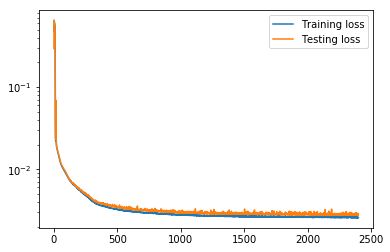

In [248]:
# Now let's train the initial network 

model = offCenterLineNet()
model = model.to(dev)
model.apply(weights_init_uniform)

model.train();

optimizer = torch.optim.Adam(model.parameters(),lr=.01) 
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.1)

n_epochs = 2400

mse_loss = nn.MSELoss()
ce_loss = nn.CrossEntropyLoss()

for epoch in range(0,n_epochs):  # loop over the dataset multiple times
    
    if epoch == 0:
        train_loss_over_time = [] # to track the loss as the network trains
        test_loss_over_time = []
        
    if epoch == 10:
        optimizer = torch.optim.Adam(model.parameters(),lr=.002) 
        
        
    running_loss = 0
    num_batches = 0
    
    for batch_i, data in enumerate(train_loader):
        
        # get the input images and their corresponding labels
        num_batches += 1

        inputs, output_gt, _, _ = data
        inputs, output_gt = inputs.to(dev), output_gt.to(dev)
        
        # zero the parameter (weight) gradients
        optimizer.zero_grad()
        
        # forward pass to get outputs
        output_line_params = model(inputs)
        

        # make the ground truth
        c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
        gt_line_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0]),c),dim=1)
        
        # calculate the loss
#         print(output_line_params[:,:,0,50])
        
        loss = mse_loss(output_line_params,gt_line_params)
        
        # backward pass to calculate the parameter gradients
        loss.backward()

        # update the parameters
        optimizer.step()

        # to convert loss into a scalar and add it to running_loss, we use .item()
        running_loss += loss.item()
      

#     scheduler.step()
    
    # Calculate test data loss after each epoch
    with torch.no_grad():
        test_loss = 0
        num_batches_test = 0
        for batch_i, data in enumerate(test_loader):
            num_batches_test += 1

            # Add code here
            inputs, output_gt, _, _ = data
            inputs, output_gt = inputs.to(dev), output_gt.to(dev)


            # zero the parameter (weight) gradients
            optimizer.zero_grad()

            # forward pass to get outputs
            output_line_params = model(inputs)

            # make the ground truth
            c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
            gt_line_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0]),c),dim=1)
    

            # calculate the loss
    #         print(output_line_params[:,:,0,50])

            loss = mse_loss(output_line_params,gt_line_params)
            
            test_loss += loss
                    
        test_loss_over_time.append(test_loss/num_batches_test)

    # Calculate model loss:
    avg_loss = running_loss/num_batches
    train_loss_over_time.append(avg_loss)
    
#     print('Epoch: {}, Avg. Train Loss: {},'.format(epoch + 1, train_loss_over_time[-1]))


    print('Epoch: {}, Avg. Train Loss: {}, Avg. Test Loss: {}'.format(epoch + 1, train_loss_over_time[-1], test_loss_over_time[-1]))
    
print('Finished Training')

plt.figure()
plt.semilogy(np.arange(0,n_epochs),train_loss_over_time[0:])
plt.semilogy(np.arange(0,n_epochs),test_loss_over_time[0:])
plt.legend(['Training loss', 'Testing loss'])

[tensor(3.3162), tensor(3.5948), tensor(3.1768), tensor(3.1478), tensor(3.4375), tensor(3.5968), tensor(3.6383), tensor(3.6072), tensor(3.2531), tensor(3.2379), tensor(3.4659), tensor(3.4950), tensor(3.5042), tensor(3.2282), tensor(3.3257)]


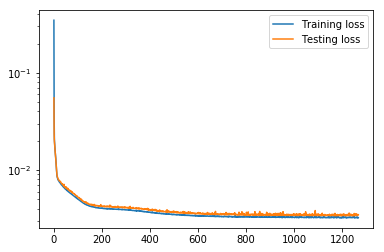

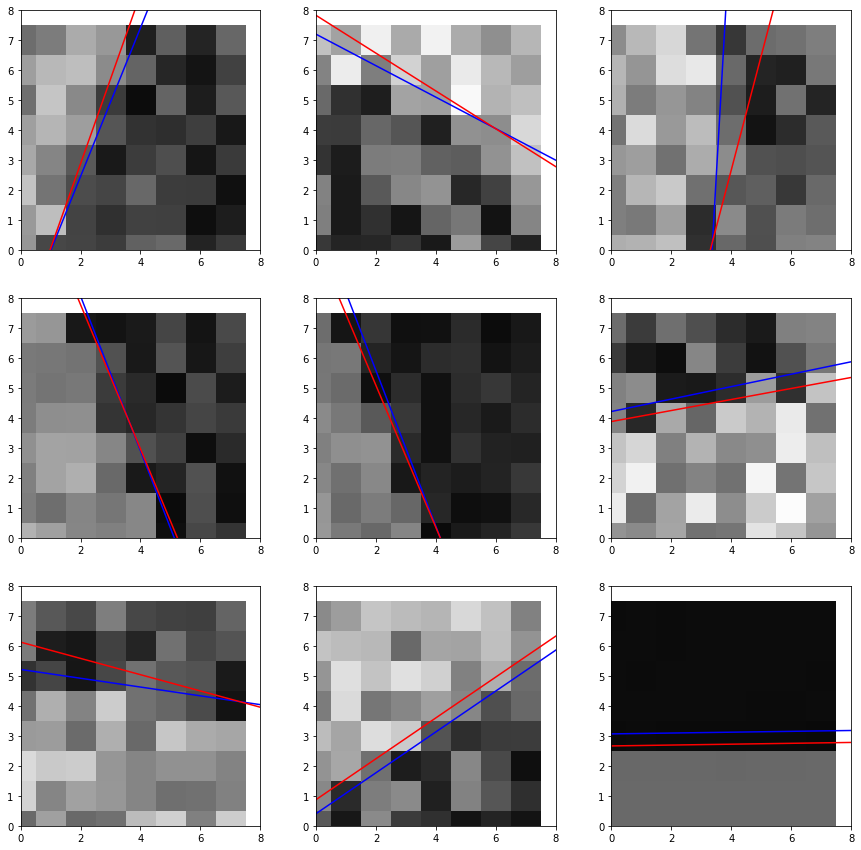

In [246]:
# Plot the Results

plt.figure()
plt.semilogy(np.arange(epoch),train_loss_over_time[:])
plt.semilogy(np.arange(epoch),test_loss_over_time[:])
plt.legend(['Training loss', 'Testing loss'])

model.eval();

ang_loss_all = []

for batch_i, data in enumerate(test_loader):
    # get the input images and their corresponding labels
    inputs, output_gt, _, _ = data
    inputs, output_gt = inputs.to(dev), output_gt.to(dev)
    

    # forward pass to get outputs
    outputs = model(inputs).squeeze().detach().cpu()
    
    gt = output_gt.cpu().squeeze()
    
    c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
    angle_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0]),c),axis=1).detach().cpu()
  
    # Calculate angular loss
    ang_loss = torch.mean(torch.abs(torch.rad2deg(torch.atan2(-angle_params[:,0]*outputs[:,1] + angle_params[:,1]*outputs[:,0]
                                         ,angle_params[:,1]*outputs[:,1]+angle_params[:,0]*outputs[:,0]).cpu())))

    ang_loss_all.append(ang_loss)

    
print(ang_loss_all)

plt.figure(figsize=[15, 15])

for ii in range(9):
    
    plt.subplot(3,3,ii+1)
    plt.imshow(inputs[ii].cpu().squeeze(),cmap='gray', vmin=0, vmax=1)
    
    # Plot the ground truth lines
    x_sample = torch.linspace(-1,1,inputs.shape[-1])
    y_sample = -angle_params[ii,0]/angle_params[ii,1]*x_sample - angle_params[ii,2]/angle_params[ii,1]
    
    plt.plot(x_sample*W/2+W/2,y_sample*W/2+W/2,'b')
    plt.xlim([0,W])
    plt.ylim(([0,W]))
    
    # Plot the estimated lines
    y_est = -outputs[ii,0]/outputs[ii,1]*x_sample - outputs[ii,2]/outputs[ii,1]
    plt.plot(x_sample*W/2+W/2,y_est*W/2+W/2,'r')




In [153]:
class offCenterLineNet(nn.Module):

    def __init__(self):
        super().__init__()
                
        self.conv1 = nn.Conv2d(1, 128, kernel_size=3) #64 is good
#         self.conv2 = nn.Conv2d(32, 32, kernel_size=3)
        self.conv3 = nn.Conv2d(128, 8, kernel_size=3)
        self.fc = nn.LazyLinear(3)
        self.maxpool = nn.MaxPool2d(2)
        self.avgpool = nn.AvgPool2d(2)
        self.activate = nn.ReLU()
#         self.batchnorm = nn.BatchNorm2d(128)
    
    def forward(self, x):

        x = self.conv1(x)
#         x = F.relu(x)
        x = self.activate(x)
#         x = self.maxpool(x)
#         x = self.batchnorm(x)
#         x = self.conv2(x)
#         x = self.activate(x)
#         x = F.relu(x)
#         x = self.batchnorm(x)
        x = self.conv3(x)
        x = self.maxpool(x)
        x = self.avgpool(x)
        x = x.view(x.shape[0],-1)
        
        x = self.fc(x)
         
        # We're defining
        # a = - sin(theta)
        # b = cos(theta)
        # c = -cy*cos(theta)+cx*sin(theta)
        # Hence, we want to normalize the vector by 1/sqrt(a^2 + b^2)
        norm_factor = (torch.norm(x[:,:2],p=2,dim=1)).unsqueeze(1)       
        out = x/(norm_factor)#+eps)
#         print('Output shape=',x.shape)

#         out = x
        
        return out
    
model = offCenterLineNet()
model = model.to(dev)
summary(model, input_size=(1, H, W))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 128, 6, 6]           1,280
              ReLU-2            [-1, 128, 6, 6]               0
            Conv2d-3              [-1, 8, 4, 4]           9,224
         MaxPool2d-4              [-1, 8, 2, 2]               0
         AvgPool2d-5              [-1, 8, 1, 1]               0
            Linear-6                    [-1, 3]              27
Total params: 10,531
Trainable params: 10,531
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.07
Params size (MB): 0.04
Estimated Total Size (MB): 0.11
----------------------------------------------------------------


In [155]:
# Now let's train the initial network 

model = offCenterLineNet()
model = model.to(dev)
model.apply(weights_init_uniform)

model.train();

optimizer = torch.optim.Adam(model.parameters(),lr=.01) 
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.1)

n_epochs = 2400

mse_loss = nn.MSELoss()
ce_loss = nn.CrossEntropyLoss()

for epoch in range(0,n_epochs):  # loop over the dataset multiple times
    
    if epoch == 0:
        train_loss_over_time = [] # to track the loss as the network trains
        test_loss_over_time = []
        
    if epoch == 10:
        optimizer = torch.optim.Adam(model.parameters(),lr=.005) 
        
        
    running_loss = 0
    num_batches = 0
    
    for batch_i, data in enumerate(train_loader):
        
        # get the input images and their corresponding labels
        num_batches += 1

        inputs, output_gt, _, _ = data
        inputs, output_gt = inputs.to(dev), output_gt.to(dev)
        
        # zero the parameter (weight) gradients
        optimizer.zero_grad()
        
        # forward pass to get outputs
        output_line_params = model(inputs)
        

        # make the ground truth
        c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
        gt_line_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0]),c),dim=1)
        
        # calculate the loss
#         print(output_line_params[:,:,0,50])
        
        loss = mse_loss(output_line_params,gt_line_params)
        
        # backward pass to calculate the parameter gradients
        loss.backward()

        # update the parameters
        optimizer.step()

        # to convert loss into a scalar and add it to running_loss, we use .item()
        running_loss += loss.item()
      

#     scheduler.step()
    
    # Calculate test data loss after each epoch
    with torch.no_grad():
        test_loss = 0
        num_batches_test = 0
        for batch_i, data in enumerate(test_loader):
            num_batches_test += 1

            # Add code here
            inputs, output_gt, _, _ = data
            inputs, output_gt = inputs.to(dev), output_gt.to(dev)


            # zero the parameter (weight) gradients
            optimizer.zero_grad()

            # forward pass to get outputs
            output_line_params = model(inputs)

            # make the ground truth
            c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
            gt_line_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0]),c),dim=1)
    

            # calculate the loss
    #         print(output_line_params[:,:,0,50])

            loss = mse_loss(output_line_params,gt_line_params)
            
            test_loss += loss
                    
        test_loss_over_time.append(test_loss/num_batches_test)

    # Calculate model loss:
    avg_loss = running_loss/num_batches
    train_loss_over_time.append(avg_loss)
    
#     print('Epoch: {}, Avg. Train Loss: {},'.format(epoch + 1, train_loss_over_time[-1]))


    print('Epoch: {}, Avg. Train Loss: {}, Avg. Test Loss: {}'.format(epoch + 1, train_loss_over_time[-1], test_loss_over_time[-1]))
    
print('Finished Training')

plt.figure()
plt.semilogy(np.arange(0,n_epochs),train_loss_over_time[0:])
plt.semilogy(np.arange(0,n_epochs),test_loss_over_time[0:])
plt.legend(['Training loss', 'Testing loss'])

Epoch: 1, Avg. Train Loss: 0.5021512931169465, Avg. Test Loss: 0.6537421941757202
Epoch: 2, Avg. Train Loss: 0.6153085107027099, Avg. Test Loss: 0.5366257429122925
Epoch: 3, Avg. Train Loss: 0.467539788678635, Avg. Test Loss: 0.5068877935409546
Epoch: 4, Avg. Train Loss: 0.4471310533063356, Avg. Test Loss: 0.6434330940246582
Epoch: 5, Avg. Train Loss: 0.528181602788526, Avg. Test Loss: 0.28025883436203003
Epoch: 6, Avg. Train Loss: 0.5823874944864318, Avg. Test Loss: 0.6178687810897827
Epoch: 7, Avg. Train Loss: 0.523882563030997, Avg. Test Loss: 0.6897341012954712
Epoch: 8, Avg. Train Loss: 0.6969623690427735, Avg. Test Loss: 0.6849868297576904
Epoch: 9, Avg. Train Loss: 0.6918647109076034, Avg. Test Loss: 0.6804423332214355
Epoch: 10, Avg. Train Loss: 0.6879779128141181, Avg. Test Loss: 0.6772291660308838
Epoch: 11, Avg. Train Loss: 0.6263589055039162, Avg. Test Loss: 0.3596056401729584
Epoch: 12, Avg. Train Loss: 0.10660029310992984, Avg. Test Loss: 0.03681341931223869
Epoch: 13, Av

Epoch: 96, Avg. Train Loss: 0.004473570755921131, Avg. Test Loss: 0.004658543039113283
Epoch: 97, Avg. Train Loss: 0.004385993323223882, Avg. Test Loss: 0.004578117746859789
Epoch: 98, Avg. Train Loss: 0.004313974153943533, Avg. Test Loss: 0.004637339152395725
Epoch: 99, Avg. Train Loss: 0.0043017661285608315, Avg. Test Loss: 0.004488243721425533
Epoch: 100, Avg. Train Loss: 0.004279314881450561, Avg. Test Loss: 0.004413763526827097
Epoch: 101, Avg. Train Loss: 0.004291390144634385, Avg. Test Loss: 0.0043818773701786995
Epoch: 102, Avg. Train Loss: 0.004170580837485748, Avg. Test Loss: 0.004385515581816435
Epoch: 103, Avg. Train Loss: 0.004169528356341775, Avg. Test Loss: 0.0044441865757107735
Epoch: 104, Avg. Train Loss: 0.004169502647506983, Avg. Test Loss: 0.004395027179270983
Epoch: 105, Avg. Train Loss: 0.004123431852433917, Avg. Test Loss: 0.0043186466209590435
Epoch: 106, Avg. Train Loss: 0.0041048831880352524, Avg. Test Loss: 0.00431891530752182
Epoch: 107, Avg. Train Loss: 0.0

Epoch: 189, Avg. Train Loss: 0.003120245904726691, Avg. Test Loss: 0.0033577277790755033
Epoch: 190, Avg. Train Loss: 0.003124436710116475, Avg. Test Loss: 0.0033319403883069754
Epoch: 191, Avg. Train Loss: 0.003106261446508904, Avg. Test Loss: 0.0032991061452776194
Epoch: 192, Avg. Train Loss: 0.003092867035288797, Avg. Test Loss: 0.00325771258212626
Epoch: 193, Avg. Train Loss: 0.0031437161649295756, Avg. Test Loss: 0.0033496315591037273
Epoch: 194, Avg. Train Loss: 0.0031083595105121996, Avg. Test Loss: 0.003392541781067848
Epoch: 195, Avg. Train Loss: 0.0031380081376017528, Avg. Test Loss: 0.003246001899242401
Epoch: 196, Avg. Train Loss: 0.0030863669668432583, Avg. Test Loss: 0.0032838331535458565
Epoch: 197, Avg. Train Loss: 0.003072610715144249, Avg. Test Loss: 0.00330486916936934
Epoch: 198, Avg. Train Loss: 0.003062153771129805, Avg. Test Loss: 0.003308178624138236
Epoch: 199, Avg. Train Loss: 0.0030568402942789848, Avg. Test Loss: 0.0033343657851219177
Epoch: 200, Avg. Train 

Epoch: 282, Avg. Train Loss: 0.002778278663754463, Avg. Test Loss: 0.00317639228887856
Epoch: 283, Avg. Train Loss: 0.00279319683241463, Avg. Test Loss: 0.003049410181120038
Epoch: 284, Avg. Train Loss: 0.002787594894640321, Avg. Test Loss: 0.003351095598191023
Epoch: 285, Avg. Train Loss: 0.0028401998922142177, Avg. Test Loss: 0.0031096197199076414
Epoch: 286, Avg. Train Loss: 0.0027924892384299013, Avg. Test Loss: 0.00305021065287292
Epoch: 287, Avg. Train Loss: 0.0027655261774482422, Avg. Test Loss: 0.003008282510563731
Epoch: 288, Avg. Train Loss: 0.0027851510879605317, Avg. Test Loss: 0.0030834379140287638
Epoch: 289, Avg. Train Loss: 0.002783424892397814, Avg. Test Loss: 0.0031101172789931297
Epoch: 290, Avg. Train Loss: 0.002751371487541947, Avg. Test Loss: 0.003041498363018036
Epoch: 291, Avg. Train Loss: 0.002754552982920824, Avg. Test Loss: 0.003118375316262245
Epoch: 292, Avg. Train Loss: 0.002784825650282031, Avg. Test Loss: 0.003035755129531026
Epoch: 293, Avg. Train Loss:

Epoch: 375, Avg. Train Loss: 0.0026060663012051305, Avg. Test Loss: 0.0029884984251111746
Epoch: 376, Avg. Train Loss: 0.002615292085507928, Avg. Test Loss: 0.0030441784765571356
Epoch: 377, Avg. Train Loss: 0.002595473378680127, Avg. Test Loss: 0.0031842042226344347
Epoch: 378, Avg. Train Loss: 0.0026011979694716457, Avg. Test Loss: 0.002863715635612607
Epoch: 379, Avg. Train Loss: 0.002624340875204219, Avg. Test Loss: 0.002970449859276414
Epoch: 380, Avg. Train Loss: 0.0026054865041704373, Avg. Test Loss: 0.003158376319333911
Epoch: 381, Avg. Train Loss: 0.0026567118502286977, Avg. Test Loss: 0.002969474531710148
Epoch: 382, Avg. Train Loss: 0.0025880694400172593, Avg. Test Loss: 0.002848069416359067
Epoch: 383, Avg. Train Loss: 0.0026174276623181824, Avg. Test Loss: 0.002842949703335762
Epoch: 384, Avg. Train Loss: 0.002556341949330513, Avg. Test Loss: 0.002826714888215065
Epoch: 385, Avg. Train Loss: 0.0025634167466832454, Avg. Test Loss: 0.002929632319137454
Epoch: 386, Avg. Train

Epoch: 467, Avg. Train Loss: 0.0024845258246154285, Avg. Test Loss: 0.002740598749369383
Epoch: 468, Avg. Train Loss: 0.00246106899278455, Avg. Test Loss: 0.002924642525613308
Epoch: 469, Avg. Train Loss: 0.0025330452941531357, Avg. Test Loss: 0.0028912958223372698
Epoch: 470, Avg. Train Loss: 0.0025029442662936312, Avg. Test Loss: 0.0028306825552135706
Epoch: 471, Avg. Train Loss: 0.002520266627936169, Avg. Test Loss: 0.0031936296727508307
Epoch: 472, Avg. Train Loss: 0.002519860825782945, Avg. Test Loss: 0.002867866074666381
Epoch: 473, Avg. Train Loss: 0.0024748343032199977, Avg. Test Loss: 0.0027367889415472746
Epoch: 474, Avg. Train Loss: 0.002490077054041416, Avg. Test Loss: 0.002749781357124448
Epoch: 475, Avg. Train Loss: 0.0024817884997139837, Avg. Test Loss: 0.0027534407563507557
Epoch: 476, Avg. Train Loss: 0.0024762273668636416, Avg. Test Loss: 0.0029040053486824036
Epoch: 477, Avg. Train Loss: 0.0024618819020255363, Avg. Test Loss: 0.0027647505048662424
Epoch: 478, Avg. Tr

Epoch: 560, Avg. Train Loss: 0.0023953492190082405, Avg. Test Loss: 0.002730222186073661
Epoch: 561, Avg. Train Loss: 0.0023874772474343, Avg. Test Loss: 0.002735669258981943
Epoch: 562, Avg. Train Loss: 0.002389219156358131, Avg. Test Loss: 0.00267826858907938
Epoch: 563, Avg. Train Loss: 0.0024232155383499556, Avg. Test Loss: 0.002823703456670046
Epoch: 564, Avg. Train Loss: 0.002417584984065142, Avg. Test Loss: 0.002828040160238743
Epoch: 565, Avg. Train Loss: 0.002415470724795447, Avg. Test Loss: 0.0028430575039237738
Epoch: 566, Avg. Train Loss: 0.0023942376638567725, Avg. Test Loss: 0.0026805640663951635
Epoch: 567, Avg. Train Loss: 0.002357856083531366, Avg. Test Loss: 0.002697467803955078
Epoch: 568, Avg. Train Loss: 0.0023922804299048904, Avg. Test Loss: 0.0027511902153491974
Epoch: 569, Avg. Train Loss: 0.0023782245305821645, Avg. Test Loss: 0.0027031011413782835
Epoch: 570, Avg. Train Loss: 0.0023884623755462643, Avg. Test Loss: 0.0027170763351023197
Epoch: 571, Avg. Train L

Epoch: 652, Avg. Train Loss: 0.0023676048162891423, Avg. Test Loss: 0.0026537366211414337
Epoch: 653, Avg. Train Loss: 0.0023509800694016523, Avg. Test Loss: 0.002802627393975854
Epoch: 654, Avg. Train Loss: 0.002329153517737638, Avg. Test Loss: 0.002753129694610834
Epoch: 655, Avg. Train Loss: 0.0024474148292007833, Avg. Test Loss: 0.0028548918198794127
Epoch: 656, Avg. Train Loss: 0.002316783886229576, Avg. Test Loss: 0.0026955129578709602
Epoch: 657, Avg. Train Loss: 0.0023018126375973225, Avg. Test Loss: 0.0028107124380767345
Epoch: 658, Avg. Train Loss: 0.002404724496828262, Avg. Test Loss: 0.0029464280232787132
Epoch: 659, Avg. Train Loss: 0.0023135138177421202, Avg. Test Loss: 0.0026872698217630386
Epoch: 660, Avg. Train Loss: 0.0023369341763819374, Avg. Test Loss: 0.002645554719492793
Epoch: 661, Avg. Train Loss: 0.00232880191639239, Avg. Test Loss: 0.002716179471462965
Epoch: 662, Avg. Train Loss: 0.0023618557836947054, Avg. Test Loss: 0.0027044874150305986
Epoch: 663, Avg. Tr

Epoch: 745, Avg. Train Loss: 0.0023456078867406345, Avg. Test Loss: 0.0025880206376314163
Epoch: 746, Avg. Train Loss: 0.0022610313296967813, Avg. Test Loss: 0.0026938177179545164
Epoch: 747, Avg. Train Loss: 0.002300818055478293, Avg. Test Loss: 0.0028377212584018707
Epoch: 748, Avg. Train Loss: 0.0022625207608609004, Avg. Test Loss: 0.0026994701474905014
Epoch: 749, Avg. Train Loss: 0.002255132865853781, Avg. Test Loss: 0.0026220607105642557
Epoch: 750, Avg. Train Loss: 0.0023251463236763728, Avg. Test Loss: 0.0026624384336173534
Epoch: 751, Avg. Train Loss: 0.00229516982230856, Avg. Test Loss: 0.0027510777581483126
Epoch: 752, Avg. Train Loss: 0.0022735992056685823, Avg. Test Loss: 0.0026033129543066025
Epoch: 753, Avg. Train Loss: 0.0022224854775379564, Avg. Test Loss: 0.0026667010970413685
Epoch: 754, Avg. Train Loss: 0.0022880678704051776, Avg. Test Loss: 0.002716405550017953
Epoch: 755, Avg. Train Loss: 0.002293687118867109, Avg. Test Loss: 0.0029075820930302143
Epoch: 756, Avg.

Epoch: 838, Avg. Train Loss: 0.0022582453702641434, Avg. Test Loss: 0.002600220264866948
Epoch: 839, Avg. Train Loss: 0.002284304834469113, Avg. Test Loss: 0.002850667806342244
Epoch: 840, Avg. Train Loss: 0.002219583942056742, Avg. Test Loss: 0.002679085126146674
Epoch: 841, Avg. Train Loss: 0.0021861501736566424, Avg. Test Loss: 0.00255255913361907
Epoch: 842, Avg. Train Loss: 0.0021735311913585595, Avg. Test Loss: 0.0026423046365380287
Epoch: 843, Avg. Train Loss: 0.002186108686484743, Avg. Test Loss: 0.0026918291114270687
Epoch: 844, Avg. Train Loss: 0.0021883353542233278, Avg. Test Loss: 0.0026198667474091053
Epoch: 845, Avg. Train Loss: 0.0022084449206717137, Avg. Test Loss: 0.0026221114676445723
Epoch: 846, Avg. Train Loss: 0.002234196571936441, Avg. Test Loss: 0.0028197825886309147
Epoch: 847, Avg. Train Loss: 0.00228228330135692, Avg. Test Loss: 0.0025444719940423965
Epoch: 848, Avg. Train Loss: 0.0021536472838285356, Avg. Test Loss: 0.0025833388790488243
Epoch: 849, Avg. Trai

Epoch: 931, Avg. Train Loss: 0.002170796866182151, Avg. Test Loss: 0.0025786336045712233
Epoch: 932, Avg. Train Loss: 0.002155030517145818, Avg. Test Loss: 0.00258832098916173
Epoch: 933, Avg. Train Loss: 0.0021366467374528565, Avg. Test Loss: 0.002636638004332781
Epoch: 934, Avg. Train Loss: 0.0021654289746440426, Avg. Test Loss: 0.002587339375168085
Epoch: 935, Avg. Train Loss: 0.002153046927306541, Avg. Test Loss: 0.0025659622624516487
Epoch: 936, Avg. Train Loss: 0.002161615392799641, Avg. Test Loss: 0.002627284498885274
Epoch: 937, Avg. Train Loss: 0.0021296484439178955, Avg. Test Loss: 0.0026309718377888203
Epoch: 938, Avg. Train Loss: 0.0021874523061046073, Avg. Test Loss: 0.0025902236811816692
Epoch: 939, Avg. Train Loss: 0.0021808304482811066, Avg. Test Loss: 0.0026008673012256622
Epoch: 940, Avg. Train Loss: 0.0022238878110900175, Avg. Test Loss: 0.002510880818590522
Epoch: 941, Avg. Train Loss: 0.002192911905842985, Avg. Test Loss: 0.0026957171503454447
Epoch: 942, Avg. Trai

Epoch: 1023, Avg. Train Loss: 0.002129837237081902, Avg. Test Loss: 0.0025877859443426132
Epoch: 1024, Avg. Train Loss: 0.002125507529261847, Avg. Test Loss: 0.0025054169818758965
Epoch: 1025, Avg. Train Loss: 0.002110693181410085, Avg. Test Loss: 0.002498846035450697
Epoch: 1026, Avg. Train Loss: 0.0021387351931311015, Avg. Test Loss: 0.0025948877446353436
Epoch: 1027, Avg. Train Loss: 0.002100621666867546, Avg. Test Loss: 0.0025757811963558197
Epoch: 1028, Avg. Train Loss: 0.0021337011347113306, Avg. Test Loss: 0.0027037805411964655
Epoch: 1029, Avg. Train Loss: 0.0022102681091488445, Avg. Test Loss: 0.0025311510544270277
Epoch: 1030, Avg. Train Loss: 0.002097434940921186, Avg. Test Loss: 0.0025027901865541935
Epoch: 1031, Avg. Train Loss: 0.002159072765755619, Avg. Test Loss: 0.002559244865551591
Epoch: 1032, Avg. Train Loss: 0.0021291906555551427, Avg. Test Loss: 0.0025573873426765203
Epoch: 1033, Avg. Train Loss: 0.0021170936172914714, Avg. Test Loss: 0.0025875091087073088
Epoch: 

Epoch: 1114, Avg. Train Loss: 0.002121161398759415, Avg. Test Loss: 0.002537979045882821
Epoch: 1115, Avg. Train Loss: 0.0020909682268190175, Avg. Test Loss: 0.002563444199040532
Epoch: 1116, Avg. Train Loss: 0.0021395595733422874, Avg. Test Loss: 0.0026207994669675827
Epoch: 1117, Avg. Train Loss: 0.002126246030160854, Avg. Test Loss: 0.002616701414808631
Epoch: 1118, Avg. Train Loss: 0.002108953156790068, Avg. Test Loss: 0.002552629681304097
Epoch: 1119, Avg. Train Loss: 0.002068400902803554, Avg. Test Loss: 0.0025887121446430683
Epoch: 1120, Avg. Train Loss: 0.002077106586765758, Avg. Test Loss: 0.0025770924985408783
Epoch: 1121, Avg. Train Loss: 0.0020716714559036284, Avg. Test Loss: 0.002811301499605179
Epoch: 1122, Avg. Train Loss: 0.002138982548616653, Avg. Test Loss: 0.0026633974630385637
Epoch: 1123, Avg. Train Loss: 0.0020672910586865836, Avg. Test Loss: 0.002533819992095232
Epoch: 1124, Avg. Train Loss: 0.0021434337480080337, Avg. Test Loss: 0.002548622665926814
Epoch: 1125,

Epoch: 1206, Avg. Train Loss: 0.0020808889990845737, Avg. Test Loss: 0.002574136247858405
Epoch: 1207, Avg. Train Loss: 0.0020905328199787195, Avg. Test Loss: 0.0025976209435611963
Epoch: 1208, Avg. Train Loss: 0.0020867445679424806, Avg. Test Loss: 0.002610632451251149
Epoch: 1209, Avg. Train Loss: 0.0020695934776043478, Avg. Test Loss: 0.002538612112402916
Epoch: 1210, Avg. Train Loss: 0.0020940783677276136, Avg. Test Loss: 0.002599954605102539
Epoch: 1211, Avg. Train Loss: 0.00204037933686185, Avg. Test Loss: 0.002591413911432028
Epoch: 1212, Avg. Train Loss: 0.0020904520656480348, Avg. Test Loss: 0.002546547446399927
Epoch: 1213, Avg. Train Loss: 0.002050689592156126, Avg. Test Loss: 0.0025117872282862663
Epoch: 1214, Avg. Train Loss: 0.002023071123741914, Avg. Test Loss: 0.0024794305209070444
Epoch: 1215, Avg. Train Loss: 0.002046267315203887, Avg. Test Loss: 0.002630633534863591
Epoch: 1216, Avg. Train Loss: 0.0020889306365144116, Avg. Test Loss: 0.0024575325660407543
Epoch: 1217

Epoch: 1297, Avg. Train Loss: 0.002019557300521884, Avg. Test Loss: 0.0025003012269735336
Epoch: 1298, Avg. Train Loss: 0.002117087149472777, Avg. Test Loss: 0.0025241889525204897
Epoch: 1299, Avg. Train Loss: 0.002046890954790247, Avg. Test Loss: 0.0024501595180481672
Epoch: 1300, Avg. Train Loss: 0.002059568859485173, Avg. Test Loss: 0.002622544299811125
Epoch: 1301, Avg. Train Loss: 0.00207764568987714, Avg. Test Loss: 0.00260182935744524
Epoch: 1302, Avg. Train Loss: 0.002068720757961273, Avg. Test Loss: 0.002964072860777378
Epoch: 1303, Avg. Train Loss: 0.002038472711086966, Avg. Test Loss: 0.002498095156624913
Epoch: 1304, Avg. Train Loss: 0.0020378261051942096, Avg. Test Loss: 0.002619905397295952
Epoch: 1305, Avg. Train Loss: 0.002033945478953768, Avg. Test Loss: 0.002563594840466976
Epoch: 1306, Avg. Train Loss: 0.0020567732836054855, Avg. Test Loss: 0.0025619883090257645
Epoch: 1307, Avg. Train Loss: 0.002083341729134148, Avg. Test Loss: 0.002663802821189165
Epoch: 1308, Avg.

Epoch: 1389, Avg. Train Loss: 0.002048858154435144, Avg. Test Loss: 0.002511922037228942
Epoch: 1390, Avg. Train Loss: 0.002039294086158449, Avg. Test Loss: 0.0026665974874049425
Epoch: 1391, Avg. Train Loss: 0.0020494917840805163, Avg. Test Loss: 0.002778721274808049
Epoch: 1392, Avg. Train Loss: 0.002118647767252527, Avg. Test Loss: 0.0025062905624508858
Epoch: 1393, Avg. Train Loss: 0.0021261297231323496, Avg. Test Loss: 0.0025679150130599737
Epoch: 1394, Avg. Train Loss: 0.00203813633578288, Avg. Test Loss: 0.0025190706364810467
Epoch: 1395, Avg. Train Loss: 0.002018719651671343, Avg. Test Loss: 0.00250721862539649
Epoch: 1396, Avg. Train Loss: 0.002029235488301966, Avg. Test Loss: 0.002426676219329238
Epoch: 1397, Avg. Train Loss: 0.002031365263297461, Avg. Test Loss: 0.0026820513885468245
Epoch: 1398, Avg. Train Loss: 0.0020389294896144853, Avg. Test Loss: 0.002498065587133169
Epoch: 1399, Avg. Train Loss: 0.0020399742088345594, Avg. Test Loss: 0.0025536445900797844
Epoch: 1400, 

Epoch: 1481, Avg. Train Loss: 0.0020077880228284834, Avg. Test Loss: 0.002467360580340028
Epoch: 1482, Avg. Train Loss: 0.001983952126465738, Avg. Test Loss: 0.0025507137179374695
Epoch: 1483, Avg. Train Loss: 0.0020322496921560446, Avg. Test Loss: 0.0025133800227195024
Epoch: 1484, Avg. Train Loss: 0.0020354609357106476, Avg. Test Loss: 0.0025802392046898603
Epoch: 1485, Avg. Train Loss: 0.0020092955037821518, Avg. Test Loss: 0.002551443176344037
Epoch: 1486, Avg. Train Loss: 0.001970856905330059, Avg. Test Loss: 0.0024739326909184456
Epoch: 1487, Avg. Train Loss: 0.0019697722529472654, Avg. Test Loss: 0.002486520679667592
Epoch: 1488, Avg. Train Loss: 0.0019954945025748984, Avg. Test Loss: 0.0030298030469566584
Epoch: 1489, Avg. Train Loss: 0.002048106912826729, Avg. Test Loss: 0.0027883267030119896
Epoch: 1490, Avg. Train Loss: 0.002045127685008527, Avg. Test Loss: 0.0024710323195904493
Epoch: 1491, Avg. Train Loss: 0.0019839645937345055, Avg. Test Loss: 0.002467530779540539
Epoch: 

Epoch: 1572, Avg. Train Loss: 0.001972415005290058, Avg. Test Loss: 0.002489234786480665
Epoch: 1573, Avg. Train Loss: 0.0019929560529457968, Avg. Test Loss: 0.002520419890061021
Epoch: 1574, Avg. Train Loss: 0.0020665052877522484, Avg. Test Loss: 0.002550660166889429
Epoch: 1575, Avg. Train Loss: 0.002017841227677499, Avg. Test Loss: 0.0025299442932009697
Epoch: 1576, Avg. Train Loss: 0.001975972592549095, Avg. Test Loss: 0.002492055529728532
Epoch: 1577, Avg. Train Loss: 0.0019696112478498457, Avg. Test Loss: 0.0025148249696940184
Epoch: 1578, Avg. Train Loss: 0.0019567002065826295, Avg. Test Loss: 0.0025779895950108767
Epoch: 1579, Avg. Train Loss: 0.001996282106373719, Avg. Test Loss: 0.00245621707290411
Epoch: 1580, Avg. Train Loss: 0.0020430387907423254, Avg. Test Loss: 0.002572915982455015
Epoch: 1581, Avg. Train Loss: 0.0020843996899202466, Avg. Test Loss: 0.0024570715613663197
Epoch: 1582, Avg. Train Loss: 0.002015952711253492, Avg. Test Loss: 0.0024964690674096346
Epoch: 1583

Epoch: 1663, Avg. Train Loss: 0.0019929555845771764, Avg. Test Loss: 0.0024524061009287834
Epoch: 1664, Avg. Train Loss: 0.0020005949908261035, Avg. Test Loss: 0.0024338376242667437
Epoch: 1665, Avg. Train Loss: 0.0019619525626821573, Avg. Test Loss: 0.002502832096070051
Epoch: 1666, Avg. Train Loss: 0.001982582624741765, Avg. Test Loss: 0.002552869962528348
Epoch: 1667, Avg. Train Loss: 0.0019716289257197535, Avg. Test Loss: 0.0024321950040757656
Epoch: 1668, Avg. Train Loss: 0.0019348388711033866, Avg. Test Loss: 0.0024998141452670097
Epoch: 1669, Avg. Train Loss: 0.0019312917449793151, Avg. Test Loss: 0.0025074253790080547
Epoch: 1670, Avg. Train Loss: 0.0019762378056035483, Avg. Test Loss: 0.0025302108842879534
Epoch: 1671, Avg. Train Loss: 0.0019479504012134532, Avg. Test Loss: 0.0025583042297512293
Epoch: 1672, Avg. Train Loss: 0.00199723040663399, Avg. Test Loss: 0.002449021441861987
Epoch: 1673, Avg. Train Loss: 0.0019395263205000826, Avg. Test Loss: 0.002421033103018999
Epoch:

Epoch: 1754, Avg. Train Loss: 0.0020733173655042817, Avg. Test Loss: 0.0026306449435651302
Epoch: 1755, Avg. Train Loss: 0.0021023149547968493, Avg. Test Loss: 0.002437436953186989
Epoch: 1756, Avg. Train Loss: 0.0019498316782288426, Avg. Test Loss: 0.0025382856838405132
Epoch: 1757, Avg. Train Loss: 0.0019506434206092774, Avg. Test Loss: 0.0024428588803857565
Epoch: 1758, Avg. Train Loss: 0.001975531576114685, Avg. Test Loss: 0.0024657053872942924
Epoch: 1759, Avg. Train Loss: 0.0019314945377626044, Avg. Test Loss: 0.002462065080180764
Epoch: 1760, Avg. Train Loss: 0.001981009528863915, Avg. Test Loss: 0.0024861637502908707
Epoch: 1761, Avg. Train Loss: 0.0019897330649803545, Avg. Test Loss: 0.002494944492354989
Epoch: 1762, Avg. Train Loss: 0.0020120773372391976, Avg. Test Loss: 0.002438418800011277
Epoch: 1763, Avg. Train Loss: 0.0019195415593986941, Avg. Test Loss: 0.002433956367895007
Epoch: 1764, Avg. Train Loss: 0.001934980061230098, Avg. Test Loss: 0.002595535945147276
Epoch: 1

KeyboardInterrupt: 

[tensor(2.8954), tensor(3.1278), tensor(2.9318), tensor(2.7288), tensor(2.9849), tensor(3.1614), tensor(3.1129), tensor(3.2746), tensor(2.9380), tensor(2.8767), tensor(3.2177), tensor(2.9134), tensor(2.7144), tensor(2.7509), tensor(2.6870)]


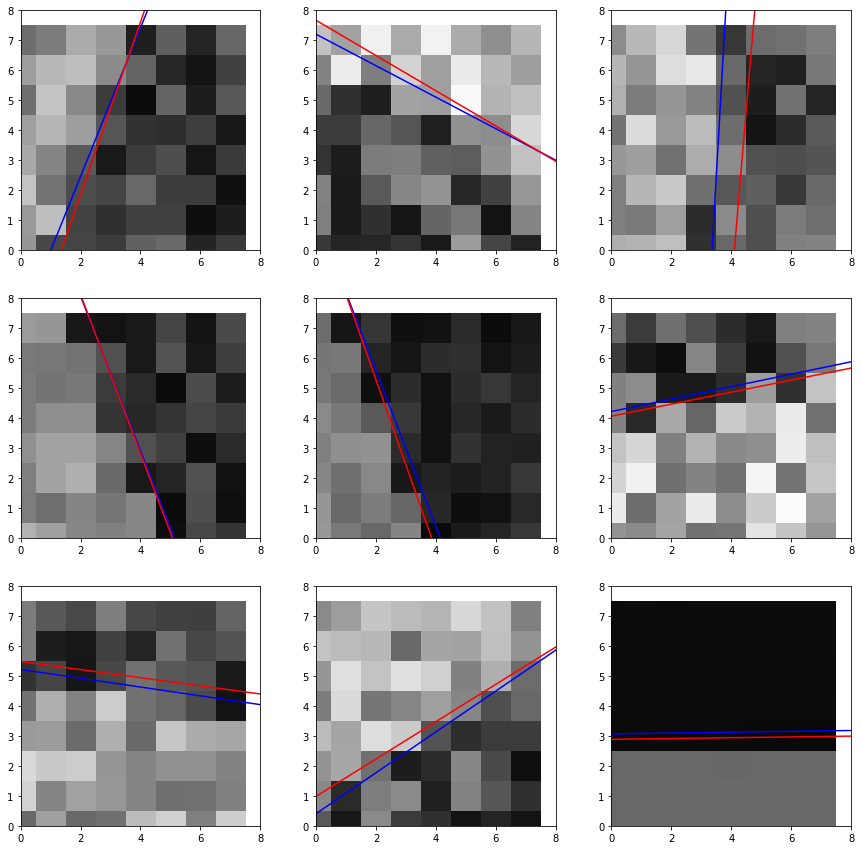

In [156]:
# Plot the Results

model.eval();

ang_loss_all = []

for batch_i, data in enumerate(test_loader):
    # get the input images and their corresponding labels
    inputs, output_gt, _, _ = data
    inputs, output_gt = inputs.to(dev), output_gt.to(dev)
    

    # forward pass to get outputs
    outputs = model(inputs).squeeze().detach().cpu()
    
    gt = output_gt.cpu().squeeze()
    
    c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
    angle_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0]),c),axis=1).detach().cpu()
  
    # Calculate angular loss
    ang_loss = torch.mean(torch.abs(torch.rad2deg(torch.atan2(-angle_params[:,0]*outputs[:,1] + angle_params[:,1]*outputs[:,0]
                                         ,angle_params[:,1]*outputs[:,1]+angle_params[:,0]*outputs[:,0]).cpu())))

    ang_loss_all.append(ang_loss)

    
print(ang_loss_all)

plt.figure(figsize=[15, 15])

for ii in range(9):
    
    plt.subplot(3,3,ii+1)
    plt.imshow(inputs[ii].cpu().squeeze(),cmap='gray', vmin=0, vmax=1)
    
    # Plot the ground truth lines
    x_sample = torch.linspace(-1,1,inputs.shape[-1])
    y_sample = -angle_params[ii,0]/angle_params[ii,1]*x_sample - angle_params[ii,2]/angle_params[ii,1]
    
    plt.plot(x_sample*W/2+W/2,y_sample*W/2+W/2,'b')
    plt.xlim([0,W])
    plt.ylim(([0,W]))
    
    # Plot the estimated lines
    y_est = -outputs[ii,0]/outputs[ii,1]*x_sample - outputs[ii,2]/outputs[ii,1]
    plt.plot(x_sample*W/2+W/2,y_est*W/2+W/2,'r')





# 5x5

100000


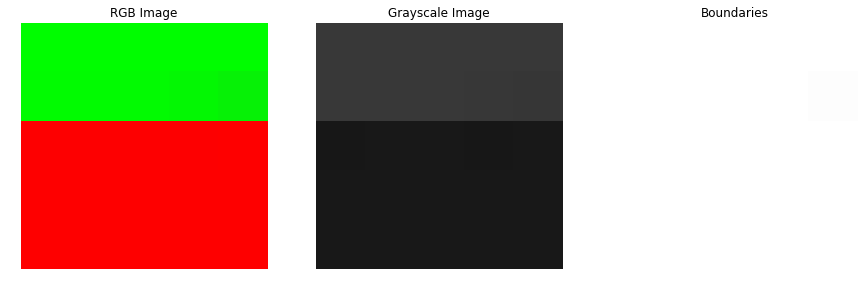

In [5]:
# Load dataset 

data_folder = 'foj_data/grayscale_lines/'

with open(data_folder + 'line_data_5_100000_grey_multicolor_noise_random_uncentered.pkl','rb') as f:
    data = pickle.load(f)

# wedges = data['wedges']
wedges_grey = data['wedges_grey']
params = data['params']
boundaries = data['boundaries']
wedges = data['wedges']


line_data = LineDataset(wedges_grey, params, boundaries, wedges)#, transform=trainTransform)
data_size = len(line_data)

print(data_size)

train_proportion = .85
# Split dataset into training and testing
train_dataset, test_dataset = torch.utils.data.random_split(line_data, [int(data_size*train_proportion), int(data_size*(1-train_proportion))], generator=torch.Generator().manual_seed(42))

# Create loaders for the training and testing data
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1000, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=500, shuffle=False) #len(test_dataset)


W,H = 5,5

img_show = 1
plt.figure(figsize=[15, 15])
plt.subplot(131)
plt.imshow(wedges[img_show,:,:].squeeze().permute(1,2,0).cpu())
plt.title('RGB Image')
plt.axis('off');
plt.subplot(132)
plt.imshow(wedges_grey[img_show,:,:].squeeze().cpu(),cmap='gray', vmin=0, vmax=1)
plt.title('Grayscale Image')
plt.axis('off');
plt.subplot(133)
plt.imshow(boundaries[img_show,:,:].squeeze().cpu(),cmap='gray', vmin=0, vmax=1)
plt.title('Boundaries')
plt.axis('off');




In [20]:
class offCenterLineNet(nn.Module):

    def __init__(self):
        super().__init__()
                
        self.conv1 = nn.Conv2d(1, 8, kernel_size=2) #64 is good
        self.conv2 = nn.Conv2d(8, 8, kernel_size=2)
        self.conv3 = nn.Conv2d(8, 8, kernel_size=2)
        self.fc = nn.LazyLinear(3)
        self.maxpool = nn.MaxPool2d(2)
#         self.avgpool = nn.AvgPool2d(2)
        self.activate = nn.ReLU()
#         self.batchnorm = nn.BatchNorm2d(128)
    
    def forward(self, x):

        x = self.conv1(x)
#         x = F.relu(x)
        x = self.activate(x)
#         x = self.maxpool(x)
#         x = self.batchnorm(x)
        x = self.conv2(x)
        x = self.activate(x)
#         x = F.relu(x)
#         x = self.batchnorm(x)
        x = self.conv3(x)
#         x = self.maxpool(x)
#         x = self.avgpool(x)
        x = x.view(x.shape[0],-1)
        
        x = self.fc(x)
         
        # We're defining
        # a = - sin(theta)
        # b = cos(theta)
        # c = -cy*cos(theta)+cx*sin(theta)
        # Hence, we want to normalize the vector by 1/sqrt(a^2 + b^2)
        norm_factor = (torch.norm(x[:,:2],p=2,dim=1)).unsqueeze(1)       
        out = x/(norm_factor)#+eps)
#         print('Output shape=',x.shape)

#         out = x
        
        return out
    
model = offCenterLineNet()
model = model.to(dev)
summary(model, input_size=(1, H, W))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1              [-1, 8, 4, 4]              40
              ReLU-2              [-1, 8, 4, 4]               0
            Conv2d-3              [-1, 8, 3, 3]             264
              ReLU-4              [-1, 8, 3, 3]               0
            Conv2d-5              [-1, 8, 2, 2]             264
            Linear-6                    [-1, 3]              99
Total params: 667
Trainable params: 667
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


In [21]:
# Now let's train the initial network 

model = offCenterLineNet()
model = model.to(dev)
model.apply(weights_init_uniform)

model.train();

optimizer = torch.optim.Adam(model.parameters(),lr=.01) 
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.1)

n_epochs = 2400

mse_loss = nn.MSELoss()
ce_loss = nn.CrossEntropyLoss()

for epoch in range(0,n_epochs):  # loop over the dataset multiple times
    
    if epoch == 0:
        train_loss_over_time = [] # to track the loss as the network trains
        test_loss_over_time = []
        
    if epoch == 5:
        optimizer = torch.optim.Adam(model.parameters(),lr=.001) 
        
        
    running_loss = 0
    num_batches = 0
    
    for batch_i, data in enumerate(train_loader):
        
        # get the input images and their corresponding labels
        num_batches += 1

        inputs, output_gt, _, _ = data
        inputs, output_gt = inputs.to(dev), output_gt.to(dev)
        
        # zero the parameter (weight) gradients
        optimizer.zero_grad()
        
        # forward pass to get outputs
        output_line_params = model(inputs)
        

        # make the ground truth
        c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
        gt_line_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0]),c),dim=1)
        
        # calculate the loss
#         print(output_line_params[:,:,0,50])
        
        loss = mse_loss(output_line_params,gt_line_params)
        
        # backward pass to calculate the parameter gradients
        loss.backward()

        # update the parameters
        optimizer.step()

        # to convert loss into a scalar and add it to running_loss, we use .item()
        running_loss += loss.item()
      

#     scheduler.step()
    
    # Calculate test data loss after each epoch
    with torch.no_grad():
        test_loss = 0
        num_batches_test = 0
        for batch_i, data in enumerate(test_loader):
            num_batches_test += 1

            # Add code here
            inputs, output_gt, _, _ = data
            inputs, output_gt = inputs.to(dev), output_gt.to(dev)


            # zero the parameter (weight) gradients
            optimizer.zero_grad()

            # forward pass to get outputs
            output_line_params = model(inputs)

            # make the ground truth
            c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
            gt_line_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0]),c),dim=1)
    

            # calculate the loss
    #         print(output_line_params[:,:,0,50])

            loss = mse_loss(output_line_params,gt_line_params)
            
            test_loss += loss
                    
        test_loss_over_time.append(test_loss/num_batches_test)

    # Calculate model loss:
    avg_loss = running_loss/num_batches
    train_loss_over_time.append(avg_loss)
    
#     print('Epoch: {}, Avg. Train Loss: {},'.format(epoch + 1, train_loss_over_time[-1]))


    print('Epoch: {}, Avg. Train Loss: {}, Avg. Test Loss: {}'.format(epoch + 1, train_loss_over_time[-1], test_loss_over_time[-1]))
    
print('Finished Training')

plt.figure()
plt.semilogy(np.arange(0,n_epochs),train_loss_over_time[0:])
plt.semilogy(np.arange(0,n_epochs),test_loss_over_time[0:])
plt.legend(['Training loss', 'Testing loss'])

Epoch: 1, Avg. Train Loss: 0.45436347056837645, Avg. Test Loss: 0.4076485335826874
Epoch: 2, Avg. Train Loss: 0.3535603561822106, Avg. Test Loss: 0.3371735215187073
Epoch: 3, Avg. Train Loss: 0.2630556955057032, Avg. Test Loss: 0.19916090369224548
Epoch: 4, Avg. Train Loss: 0.12294933471609565, Avg. Test Loss: 0.09420251846313477
Epoch: 5, Avg. Train Loss: 0.5615666286033743, Avg. Test Loss: 0.5973995327949524
Epoch: 6, Avg. Train Loss: 0.4758999035638921, Avg. Test Loss: 0.2890114486217499
Epoch: 7, Avg. Train Loss: 0.15846227784367167, Avg. Test Loss: 0.0925314724445343
Epoch: 8, Avg. Train Loss: 0.07170126319808119, Avg. Test Loss: 0.06511638313531876
Epoch: 9, Avg. Train Loss: 0.060380270156790226, Avg. Test Loss: 0.052725885063409805
Epoch: 10, Avg. Train Loss: 0.05414823736338054, Avg. Test Loss: 0.049271684139966965
Epoch: 11, Avg. Train Loss: 0.07586004173054414, Avg. Test Loss: 0.06790969520807266
Epoch: 12, Avg. Train Loss: 0.06967009866938871, Avg. Test Loss: 0.0678458139300

Epoch: 98, Avg. Train Loss: 0.052631315457470275, Avg. Test Loss: 0.04123595729470253
Epoch: 99, Avg. Train Loss: 0.042582061229383246, Avg. Test Loss: 0.03864563629031181
Epoch: 100, Avg. Train Loss: 0.04065762775785783, Avg. Test Loss: 0.034930575639009476
Epoch: 101, Avg. Train Loss: 0.0358407689806293, Avg. Test Loss: 0.033036381006240845
Epoch: 102, Avg. Train Loss: 0.03444768012884785, Avg. Test Loss: 0.03238586708903313
Epoch: 103, Avg. Train Loss: 0.03399077756878208, Avg. Test Loss: 0.0315127857029438
Epoch: 104, Avg. Train Loss: 0.03490361448596505, Avg. Test Loss: 0.03382709622383118
Epoch: 105, Avg. Train Loss: 0.034590672635856794, Avg. Test Loss: 0.03269147872924805
Epoch: 106, Avg. Train Loss: 0.033783271207528956, Avg. Test Loss: 0.03212857246398926
Epoch: 107, Avg. Train Loss: 0.033190773120697806, Avg. Test Loss: 0.03183003142476082
Epoch: 108, Avg. Train Loss: 0.03322260325007579, Avg. Test Loss: 0.03295598924160004
Epoch: 109, Avg. Train Loss: 0.03348575262900661, A

Epoch: 193, Avg. Train Loss: 0.09058993143193862, Avg. Test Loss: 0.08812899887561798
Epoch: 194, Avg. Train Loss: 0.08908701696816612, Avg. Test Loss: 0.08720187842845917
Epoch: 195, Avg. Train Loss: 0.08836050235173282, Avg. Test Loss: 0.08686558902263641
Epoch: 196, Avg. Train Loss: 0.0880903126562343, Avg. Test Loss: 0.08663744479417801
Epoch: 197, Avg. Train Loss: 0.08785776259268031, Avg. Test Loss: 0.08637429028749466
Epoch: 198, Avg. Train Loss: 0.08779830643359353, Avg. Test Loss: 0.085447758436203
Epoch: 199, Avg. Train Loss: 0.08852119498393114, Avg. Test Loss: 0.08804689347743988
Epoch: 200, Avg. Train Loss: 0.09495621682966457, Avg. Test Loss: 0.08940296620130539
Epoch: 201, Avg. Train Loss: 0.08864602525444591, Avg. Test Loss: 0.08409394323825836
Epoch: 202, Avg. Train Loss: 0.08584873807780882, Avg. Test Loss: 0.08444254845380783
Epoch: 203, Avg. Train Loss: 0.08542831242084503, Avg. Test Loss: 0.08414004743099213
Epoch: 204, Avg. Train Loss: 0.08521047173177494, Avg. Te

Epoch: 290, Avg. Train Loss: 0.4214914009851568, Avg. Test Loss: 0.411496102809906
Epoch: 291, Avg. Train Loss: 0.40322731803445255, Avg. Test Loss: 0.39640581607818604
Epoch: 292, Avg. Train Loss: 0.3764268920702093, Avg. Test Loss: 0.2817561626434326
Epoch: 293, Avg. Train Loss: 0.25506725907325745, Avg. Test Loss: 0.27032408118247986
Epoch: 294, Avg. Train Loss: 0.24897648271392372, Avg. Test Loss: 0.24654459953308105
Epoch: 295, Avg. Train Loss: 0.24622913406175725, Avg. Test Loss: 0.24329286813735962
Epoch: 296, Avg. Train Loss: 0.24358273797175464, Avg. Test Loss: 0.24071963131427765
Epoch: 297, Avg. Train Loss: 0.24131776287275203, Avg. Test Loss: 0.23810338973999023
Epoch: 298, Avg. Train Loss: 0.24273150177562938, Avg. Test Loss: 0.24088621139526367
Epoch: 299, Avg. Train Loss: 0.2417242162367877, Avg. Test Loss: 0.23851929605007172
Epoch: 300, Avg. Train Loss: 0.2378435822094188, Avg. Test Loss: 0.23279079794883728
Epoch: 301, Avg. Train Loss: 0.2321052272530163, Avg. Test Lo

Epoch: 387, Avg. Train Loss: 0.0859933986383326, Avg. Test Loss: 0.07479408383369446
Epoch: 388, Avg. Train Loss: 0.0734509535572108, Avg. Test Loss: 0.07121442258358002
Epoch: 389, Avg. Train Loss: 0.07046252844088217, Avg. Test Loss: 0.06881234794855118
Epoch: 390, Avg. Train Loss: 0.06857361911850816, Avg. Test Loss: 0.06633248925209045
Epoch: 391, Avg. Train Loss: 0.06595620425308452, Avg. Test Loss: 0.06390334665775299
Epoch: 392, Avg. Train Loss: 0.06412658989429473, Avg. Test Loss: 0.06216539815068245
Epoch: 393, Avg. Train Loss: 0.06163079466889886, Avg. Test Loss: 0.05954520404338837
Epoch: 394, Avg. Train Loss: 0.059144281595945356, Avg. Test Loss: 0.057160358875989914
Epoch: 395, Avg. Train Loss: 0.057084280559245276, Avg. Test Loss: 0.05493037775158882
Epoch: 396, Avg. Train Loss: 0.05513778723338071, Avg. Test Loss: 0.053148236125707626
Epoch: 397, Avg. Train Loss: 0.05359173013883479, Avg. Test Loss: 0.0516422763466835
Epoch: 398, Avg. Train Loss: 0.0526512110934538, Avg.

Epoch: 482, Avg. Train Loss: 0.028600155781297123, Avg. Test Loss: 0.02755940891802311
Epoch: 483, Avg. Train Loss: 0.02863665334880352, Avg. Test Loss: 0.028963221237063408
Epoch: 484, Avg. Train Loss: 0.028532092426629626, Avg. Test Loss: 0.02763436548411846
Epoch: 485, Avg. Train Loss: 0.028370866595822223, Avg. Test Loss: 0.02775365114212036
Epoch: 486, Avg. Train Loss: 0.028288344425313614, Avg. Test Loss: 0.029206160455942154
Epoch: 487, Avg. Train Loss: 0.028207897855078472, Avg. Test Loss: 0.028056984767317772
Epoch: 488, Avg. Train Loss: 0.028197589450899292, Avg. Test Loss: 0.027848439291119576
Epoch: 489, Avg. Train Loss: 0.03407403164926697, Avg. Test Loss: 0.06842879951000214
Epoch: 490, Avg. Train Loss: 0.10512291850412593, Avg. Test Loss: 0.07245979458093643
Epoch: 491, Avg. Train Loss: 0.0622984123580596, Avg. Test Loss: 0.05732150003314018
Epoch: 492, Avg. Train Loss: 0.057683749014840406, Avg. Test Loss: 0.060120776295661926
Epoch: 493, Avg. Train Loss: 0.055848977802

Epoch: 577, Avg. Train Loss: 0.02949592839269077, Avg. Test Loss: 0.02786242961883545
Epoch: 578, Avg. Train Loss: 0.029725593481870257, Avg. Test Loss: 0.027883654460310936
Epoch: 579, Avg. Train Loss: 0.029246123770580574, Avg. Test Loss: 0.028383372351527214
Epoch: 580, Avg. Train Loss: 0.02986104267046732, Avg. Test Loss: 0.028369959443807602
Epoch: 581, Avg. Train Loss: 0.02907161269994343, Avg. Test Loss: 0.027822408825159073
Epoch: 582, Avg. Train Loss: 0.02894322672749267, Avg. Test Loss: 0.027749983593821526
Epoch: 583, Avg. Train Loss: 0.02929568689535646, Avg. Test Loss: 0.027736227959394455
Epoch: 584, Avg. Train Loss: 0.02882581933894578, Avg. Test Loss: 0.02765486389398575
Epoch: 585, Avg. Train Loss: 0.02876128626658636, Avg. Test Loss: 0.027915891259908676
Epoch: 586, Avg. Train Loss: 0.028890380657771053, Avg. Test Loss: 0.028325213119387627
Epoch: 587, Avg. Train Loss: 0.029086520303698148, Avg. Test Loss: 0.027437398210167885
Epoch: 588, Avg. Train Loss: 0.0371848076

Epoch: 672, Avg. Train Loss: 0.05578129615853814, Avg. Test Loss: 0.04618532583117485
Epoch: 673, Avg. Train Loss: 0.046289975853527295, Avg. Test Loss: 0.045081887394189835
Epoch: 674, Avg. Train Loss: 0.04422688567463089, Avg. Test Loss: 0.04187173768877983
Epoch: 675, Avg. Train Loss: 0.04233854237724753, Avg. Test Loss: 0.03980514407157898
Epoch: 676, Avg. Train Loss: 0.04086233925293473, Avg. Test Loss: 0.03868468850851059
Epoch: 677, Avg. Train Loss: 0.03998872659662191, Avg. Test Loss: 0.03762603923678398
Epoch: 678, Avg. Train Loss: 0.03889838308095932, Avg. Test Loss: 0.03661583364009857
Epoch: 679, Avg. Train Loss: 0.038150214710656334, Avg. Test Loss: 0.035912446677684784
Epoch: 680, Avg. Train Loss: 0.038151538459693685, Avg. Test Loss: 0.03602173924446106
Epoch: 681, Avg. Train Loss: 0.03881009584840606, Avg. Test Loss: 0.036601435393095016
Epoch: 682, Avg. Train Loss: 0.0378646619617939, Avg. Test Loss: 0.03571966290473938
Epoch: 683, Avg. Train Loss: 0.03753520872663049,

Epoch: 767, Avg. Train Loss: 0.0359124028507401, Avg. Test Loss: 0.034530334174633026
Epoch: 768, Avg. Train Loss: 0.03510734964819515, Avg. Test Loss: 0.03396514058113098
Epoch: 769, Avg. Train Loss: 0.0346378286533496, Avg. Test Loss: 0.03348549082875252
Epoch: 770, Avg. Train Loss: 0.0342601525652058, Avg. Test Loss: 0.033169399946928024
Epoch: 771, Avg. Train Loss: 0.03403070437557557, Avg. Test Loss: 0.033170200884342194
Epoch: 772, Avg. Train Loss: 0.033912816556061015, Avg. Test Loss: 0.03327193856239319
Epoch: 773, Avg. Train Loss: 0.03316814965184997, Avg. Test Loss: 0.033617496490478516
Epoch: 774, Avg. Train Loss: 0.03277190204928903, Avg. Test Loss: 0.03753075748682022
Epoch: 775, Avg. Train Loss: 0.0325375487041824, Avg. Test Loss: 0.03393836319446564
Epoch: 776, Avg. Train Loss: 0.032763093008714564, Avg. Test Loss: 0.03660227730870247
Epoch: 777, Avg. Train Loss: 0.03245907748008475, Avg. Test Loss: 0.03326478973031044
Epoch: 778, Avg. Train Loss: 0.03227059459861587, Av

Epoch: 862, Avg. Train Loss: 0.027390614765531878, Avg. Test Loss: 0.02705024927854538
Epoch: 863, Avg. Train Loss: 0.027641519422040267, Avg. Test Loss: 0.028422055765986443
Epoch: 864, Avg. Train Loss: 0.027050053919939435, Avg. Test Loss: 0.028659163042902946
Epoch: 865, Avg. Train Loss: 0.02695158367209575, Avg. Test Loss: 0.036175381392240524
Epoch: 866, Avg. Train Loss: 0.02694701681680539, Avg. Test Loss: 0.03221527859568596
Epoch: 867, Avg. Train Loss: 0.026943664603373583, Avg. Test Loss: 0.029378728941082954
Epoch: 868, Avg. Train Loss: 0.02687951845719534, Avg. Test Loss: 0.031777430325746536
Epoch: 869, Avg. Train Loss: 0.026808822439873918, Avg. Test Loss: 0.026821346953511238
Epoch: 870, Avg. Train Loss: 0.032944046837442065, Avg. Test Loss: 0.06350713223218918
Epoch: 871, Avg. Train Loss: 0.2625447452068329, Avg. Test Loss: 0.3108349144458771
Epoch: 872, Avg. Train Loss: 0.26374478357679704, Avg. Test Loss: 0.18255464732646942
Epoch: 873, Avg. Train Loss: 0.1597137979724

Epoch: 957, Avg. Train Loss: 0.027174831576207106, Avg. Test Loss: 0.026273181661963463
Epoch: 958, Avg. Train Loss: 0.027068404283593684, Avg. Test Loss: 0.026181431487202644
Epoch: 959, Avg. Train Loss: 0.027030954970156444, Avg. Test Loss: 0.026151416823267937
Epoch: 960, Avg. Train Loss: 0.0513663327869247, Avg. Test Loss: 0.07219996303319931
Epoch: 961, Avg. Train Loss: 0.04720790692988564, Avg. Test Loss: 0.03150947391986847
Epoch: 962, Avg. Train Loss: 0.034815187511198664, Avg. Test Loss: 0.028654171153903008
Epoch: 963, Avg. Train Loss: 0.10171418742221945, Avg. Test Loss: 0.2154683917760849
Epoch: 964, Avg. Train Loss: 0.20270251982352314, Avg. Test Loss: 0.24059435725212097
Epoch: 965, Avg. Train Loss: 0.18259634813841652, Avg. Test Loss: 0.16912822425365448
Epoch: 966, Avg. Train Loss: 0.1659267476376365, Avg. Test Loss: 0.16663233935832977
Epoch: 967, Avg. Train Loss: 0.1630358298035229, Avg. Test Loss: 0.16201378405094147
Epoch: 968, Avg. Train Loss: 0.1592756352003883, A

Epoch: 1052, Avg. Train Loss: 0.043085678973618674, Avg. Test Loss: 0.04170209541916847
Epoch: 1053, Avg. Train Loss: 0.042988208023940815, Avg. Test Loss: 0.04181993752717972
Epoch: 1054, Avg. Train Loss: 0.04334792144158307, Avg. Test Loss: 0.041320230811834335
Epoch: 1055, Avg. Train Loss: 0.042562334590098436, Avg. Test Loss: 0.040647804737091064
Epoch: 1056, Avg. Train Loss: 0.04186460143503021, Avg. Test Loss: 0.04021194204688072
Epoch: 1057, Avg. Train Loss: 0.0415333108866916, Avg. Test Loss: 0.0408003032207489
Epoch: 1058, Avg. Train Loss: 0.04401165238198112, Avg. Test Loss: 0.041369907557964325
Epoch: 1059, Avg. Train Loss: 0.042695323991424894, Avg. Test Loss: 0.04034636169672012
Epoch: 1060, Avg. Train Loss: 0.0416789085330332, Avg. Test Loss: 0.03969147056341171
Epoch: 1061, Avg. Train Loss: 0.04104662305291961, Avg. Test Loss: 0.039222344756126404
Epoch: 1062, Avg. Train Loss: 0.040509801379898014, Avg. Test Loss: 0.03857220336794853
Epoch: 1063, Avg. Train Loss: 0.03996

KeyboardInterrupt: 

[tensor(8.8662), tensor(8.0923), tensor(8.9567), tensor(8.9602), tensor(8.8223), tensor(8.0413), tensor(8.4526), tensor(9.4679), tensor(8.9621), tensor(9.9734), tensor(9.0215), tensor(8.7702), tensor(9.3271), tensor(8.7216), tensor(8.8626), tensor(9.1375), tensor(8.9578), tensor(9.0916), tensor(9.0248), tensor(8.5992), tensor(7.7984), tensor(9.0774), tensor(9.3534), tensor(8.4078), tensor(9.5434), tensor(8.9704), tensor(9.5357), tensor(9.7880), tensor(9.1081), tensor(9.6935)]


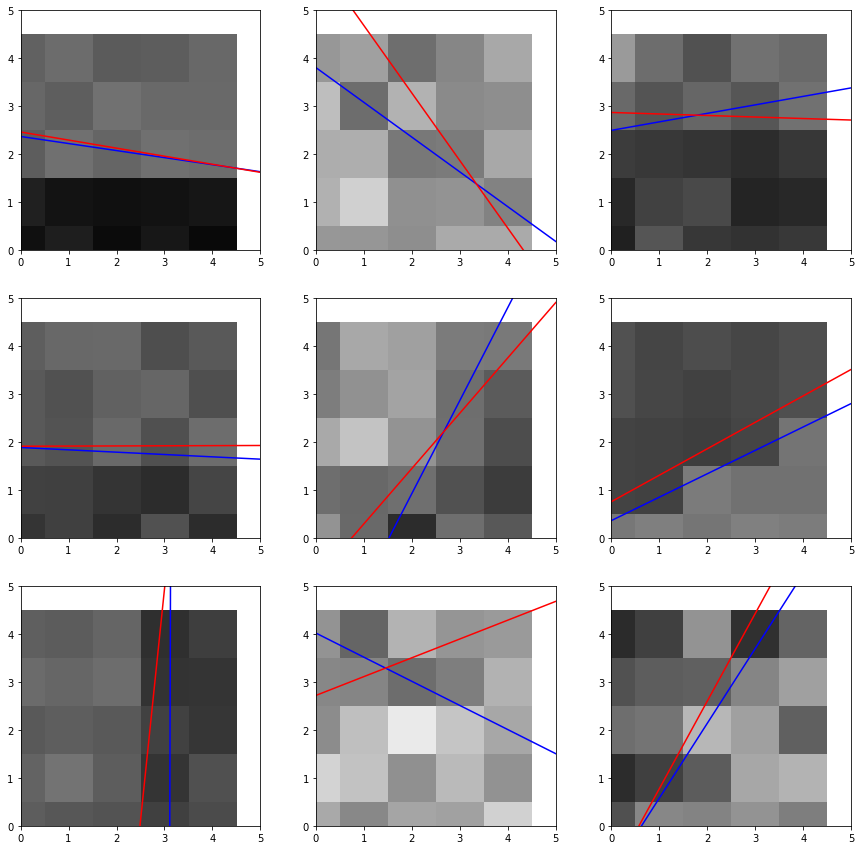

In [22]:
# Plot the Results

model.eval();

ang_loss_all = []

for batch_i, data in enumerate(test_loader):
    # get the input images and their corresponding labels
    inputs, output_gt, _, _ = data
    inputs, output_gt = inputs.to(dev), output_gt.to(dev)
    

    # forward pass to get outputs
    outputs = model(inputs).squeeze().detach().cpu()
    
    gt = output_gt.cpu().squeeze()
    
    c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
    angle_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0]),c),axis=1).detach().cpu()
  
    # Calculate angular loss
    ang_loss = torch.mean(torch.abs(torch.rad2deg(torch.atan2(-angle_params[:,0]*outputs[:,1] + angle_params[:,1]*outputs[:,0]
                                         ,angle_params[:,1]*outputs[:,1]+angle_params[:,0]*outputs[:,0]).cpu())))

    ang_loss_all.append(ang_loss)

    
print(ang_loss_all)

plt.figure(figsize=[15, 15])

for ii in range(9):
    
    plt.subplot(3,3,ii+1)
    plt.imshow(inputs[ii].cpu().squeeze(),cmap='gray', vmin=0, vmax=1)
    
    # Plot the ground truth lines
    x_sample = torch.linspace(-1,1,inputs.shape[-1])
    y_sample = -angle_params[ii,0]/angle_params[ii,1]*x_sample - angle_params[ii,2]/angle_params[ii,1]
    
    plt.plot(x_sample*W/2+W/2,y_sample*W/2+W/2,'b')
    plt.xlim([0,W])
    plt.ylim(([0,W]))
    
    # Plot the estimated lines
    y_est = -outputs[ii,0]/outputs[ii,1]*x_sample - outputs[ii,2]/outputs[ii,1]
    plt.plot(x_sample*W/2+W/2,y_est*W/2+W/2,'r')







# 3x3

50000


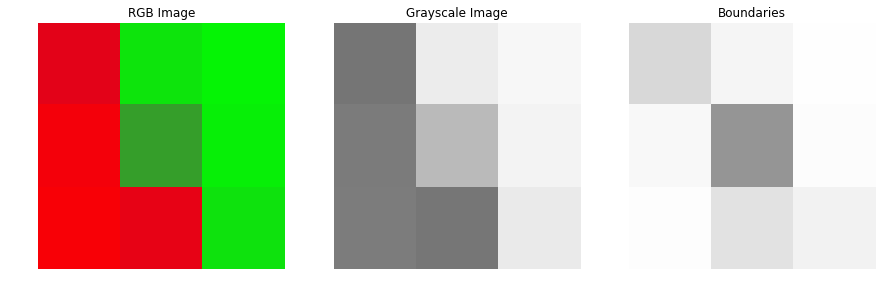

In [166]:
# Load dataset 

data_folder = 'foj_data/grayscale_lines/'

with open(data_folder + 'line_data_3_50000_grey_bicolor_noiseless_uncentered.pkl','rb') as f:
    data = pickle.load(f)

# wedges = data['wedges']
wedges_grey = data['wedges_grey']
params = data['params']
boundaries = data['boundaries']
wedges = data['wedges']


line_data = LineDataset(wedges_grey, params, boundaries, wedges)#, transform=trainTransform)
data_size = len(line_data)

print(data_size)

train_proportion = .85
# Split dataset into training and testing
train_dataset, test_dataset = torch.utils.data.random_split(line_data, [int(data_size*train_proportion), int(data_size*(1-train_proportion))], generator=torch.Generator().manual_seed(42))

# Create loaders for the training and testing data
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1000, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=500, shuffle=False) #len(test_dataset)


W,H = 3,3

img_show = 1
plt.figure(figsize=[15, 15])
plt.subplot(131)
plt.imshow(wedges[img_show,:,:].squeeze().permute(1,2,0).cpu())
plt.title('RGB Image')
plt.axis('off');
plt.subplot(132)
plt.imshow(wedges_grey[img_show,:,:].squeeze().cpu(),cmap='gray', vmin=0, vmax=1)
plt.title('Grayscale Image')
plt.axis('off');
plt.subplot(133)
plt.imshow(boundaries[img_show,:,:].squeeze().cpu(),cmap='gray', vmin=0, vmax=1)
plt.title('Boundaries')
plt.axis('off');


In [171]:
class offCenterLineNet(nn.Module):

    def __init__(self):
        super().__init__()
                
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3) #64 is good
#         self.conv2 = nn.Conv2d(32, 32, kernel_size=3)
#         self.conv3 = nn.Conv2d(128, 8, kernel_size=3)
        self.fc = nn.LazyLinear(3)
#         self.fc2 = nn.LazyLinear(32)
        self.maxpool = nn.MaxPool1d(2)
#         self.avgpool = nn.AvgPool2d(2)
        self.activate = nn.ReLU()
#         self.batchnorm = nn.BatchNorm2d(128)
    
    def forward(self, x):

        x = self.conv1(x)
        x = F.relu(x)
#         x = self.activate(x)
#         x = self.maxpool(x)
#         x = self.batchnorm(x)
#         x = self.conv2(x)
#         x = self.activate(x)
#         x = F.relu(x)
#         x = self.batchnorm(x)
#         x = self.conv3(x)

#         x = self.avgpool(x)
        x = x.view(x.shape[0],-1)
#         x = self.fc2(x)
#         x = self.maxpool(x)
        x = self.fc(x)
         
        # We're defining
        # a = - sin(theta)
        # b = cos(theta)
        # c = -cy*cos(theta)+cx*sin(theta)
        # Hence, we want to normalize the vector by 1/sqrt(a^2 + b^2)
        norm_factor = (torch.norm(x[:,:2],p=2,dim=1)).unsqueeze(1)       
        out = x/(norm_factor)#+eps)
#         print('Output shape=',x.shape)

#         out = x
        
        return out
    
model = offCenterLineNet()
model = model.to(dev)
summary(model, input_size=(1, H, W))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 16, 1, 1]             160
            Linear-2                    [-1, 3]              51
Total params: 211
Trainable params: 211
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


Epoch: 1, Avg. Train Loss: 0.6946289705675702, Avg. Test Loss: 0.6561244130134583
Epoch: 2, Avg. Train Loss: 0.5556854619536289, Avg. Test Loss: 0.2968456745147705
Epoch: 3, Avg. Train Loss: 0.24297720956247906, Avg. Test Loss: 0.13609765470027924
Epoch: 4, Avg. Train Loss: 0.07730438499603161, Avg. Test Loss: 0.03503692150115967
Epoch: 5, Avg. Train Loss: 0.024698651677300763, Avg. Test Loss: 0.0188535638153553
Epoch: 6, Avg. Train Loss: 0.017501207913250424, Avg. Test Loss: 0.015794113278388977
Epoch: 7, Avg. Train Loss: 0.014819080075032489, Avg. Test Loss: 0.013207240030169487
Epoch: 8, Avg. Train Loss: 0.012175352659163087, Avg. Test Loss: 0.010666919872164726
Epoch: 9, Avg. Train Loss: 0.009640213708544886, Avg. Test Loss: 0.008305150084197521
Epoch: 10, Avg. Train Loss: 0.007755632328172756, Avg. Test Loss: 0.00691048800945282
Epoch: 11, Avg. Train Loss: 0.00679008049760447, Avg. Test Loss: 0.006411120295524597
Epoch: 12, Avg. Train Loss: 0.006420815320209015, Avg. Test Loss: 0.

Epoch: 96, Avg. Train Loss: 0.004841267217903636, Avg. Test Loss: 0.004729293752461672
Epoch: 97, Avg. Train Loss: 0.0048586429898128955, Avg. Test Loss: 0.004752685781568289
Epoch: 98, Avg. Train Loss: 0.004843827412831922, Avg. Test Loss: 0.0047727059572935104
Epoch: 99, Avg. Train Loss: 0.004834066275074039, Avg. Test Loss: 0.004717978648841381
Epoch: 100, Avg. Train Loss: 0.004828475653951944, Avg. Test Loss: 0.00473083695396781
Epoch: 101, Avg. Train Loss: 0.004820217638341493, Avg. Test Loss: 0.004734464921057224
Epoch: 102, Avg. Train Loss: 0.004834024766243474, Avg. Test Loss: 0.004728785250335932
Epoch: 103, Avg. Train Loss: 0.00484351213848175, Avg. Test Loss: 0.004753440152853727
Epoch: 104, Avg. Train Loss: 0.0048390799093731614, Avg. Test Loss: 0.004725950304418802
Epoch: 105, Avg. Train Loss: 0.0048243804986393725, Avg. Test Loss: 0.004732129629701376
Epoch: 106, Avg. Train Loss: 0.0048285919284924515, Avg. Test Loss: 0.004730836488306522
Epoch: 107, Avg. Train Loss: 0.00

Epoch: 190, Avg. Train Loss: 0.004796946540388257, Avg. Test Loss: 0.004683453589677811
Epoch: 191, Avg. Train Loss: 0.004791648527823909, Avg. Test Loss: 0.004693989176303148
Epoch: 192, Avg. Train Loss: 0.004797939752596755, Avg. Test Loss: 0.004699797369539738
Epoch: 193, Avg. Train Loss: 0.0047965363036234715, Avg. Test Loss: 0.004718336742371321
Epoch: 194, Avg. Train Loss: 0.004788167460626641, Avg. Test Loss: 0.004710289649665356
Epoch: 195, Avg. Train Loss: 0.004798805048732564, Avg. Test Loss: 0.004732468631118536
Epoch: 196, Avg. Train Loss: 0.004792374255525512, Avg. Test Loss: 0.004679928999394178
Epoch: 197, Avg. Train Loss: 0.0047996923609008625, Avg. Test Loss: 0.0047360979951918125
Epoch: 198, Avg. Train Loss: 0.004795410605364068, Avg. Test Loss: 0.004686560481786728
Epoch: 199, Avg. Train Loss: 0.004783271519510552, Avg. Test Loss: 0.004702477715909481
Epoch: 200, Avg. Train Loss: 0.004792285086803658, Avg. Test Loss: 0.004732533358037472
Epoch: 201, Avg. Train Loss: 

Epoch: 284, Avg. Train Loss: 0.004731473902803521, Avg. Test Loss: 0.00463883439078927
Epoch: 285, Avg. Train Loss: 0.004737713222586831, Avg. Test Loss: 0.0046505858190357685
Epoch: 286, Avg. Train Loss: 0.004749660098622012, Avg. Test Loss: 0.004667548928409815
Epoch: 287, Avg. Train Loss: 0.004730436398626067, Avg. Test Loss: 0.004634839948266745
Epoch: 288, Avg. Train Loss: 0.00473141532694531, Avg. Test Loss: 0.004626092035323381
Epoch: 289, Avg. Train Loss: 0.00472781881906612, Avg. Test Loss: 0.004620905499905348
Epoch: 290, Avg. Train Loss: 0.004732980620289265, Avg. Test Loss: 0.004640879575163126
Epoch: 291, Avg. Train Loss: 0.004732711370601211, Avg. Test Loss: 0.0046623037196695805
Epoch: 292, Avg. Train Loss: 0.004724245431811311, Avg. Test Loss: 0.004632582422345877
Epoch: 293, Avg. Train Loss: 0.004729486233013314, Avg. Test Loss: 0.004629478789865971
Epoch: 294, Avg. Train Loss: 0.004748670330141173, Avg. Test Loss: 0.004633899312466383
Epoch: 295, Avg. Train Loss: 0.00

Epoch: 377, Avg. Train Loss: 0.004669777280109567, Avg. Test Loss: 0.004587383475154638
Epoch: 378, Avg. Train Loss: 0.004669100760893766, Avg. Test Loss: 0.0045984769240021706
Epoch: 379, Avg. Train Loss: 0.004656566458559314, Avg. Test Loss: 0.004573761951178312
Epoch: 380, Avg. Train Loss: 0.004655620353946159, Avg. Test Loss: 0.004546681419014931
Epoch: 381, Avg. Train Loss: 0.00465494244857583, Avg. Test Loss: 0.004566809628158808
Epoch: 382, Avg. Train Loss: 0.004659463239963664, Avg. Test Loss: 0.004553096368908882
Epoch: 383, Avg. Train Loss: 0.004646543640816628, Avg. Test Loss: 0.00459141144528985
Epoch: 384, Avg. Train Loss: 0.004660057932744885, Avg. Test Loss: 0.00455568078905344
Epoch: 385, Avg. Train Loss: 0.004657006876673116, Avg. Test Loss: 0.0045978473499417305
Epoch: 386, Avg. Train Loss: 0.004649644587622132, Avg. Test Loss: 0.004575944039970636
Epoch: 387, Avg. Train Loss: 0.004647155303161505, Avg. Test Loss: 0.004557832609862089
Epoch: 388, Avg. Train Loss: 0.00

Epoch: 470, Avg. Train Loss: 0.0045960903665873895, Avg. Test Loss: 0.004507877863943577
Epoch: 471, Avg. Train Loss: 0.004593250818204048, Avg. Test Loss: 0.004526094067841768
Epoch: 472, Avg. Train Loss: 0.004603022991051507, Avg. Test Loss: 0.004496441222727299
Epoch: 473, Avg. Train Loss: 0.004596592490236426, Avg. Test Loss: 0.004511498846113682
Epoch: 474, Avg. Train Loss: 0.004597190626745307, Avg. Test Loss: 0.004484051838517189
Epoch: 475, Avg. Train Loss: 0.004583390429615974, Avg. Test Loss: 0.004545670468360186
Epoch: 476, Avg. Train Loss: 0.004590518090354149, Avg. Test Loss: 0.004501571878790855
Epoch: 477, Avg. Train Loss: 0.004576720817144527, Avg. Test Loss: 0.004482440184801817
Epoch: 478, Avg. Train Loss: 0.004579316250719997, Avg. Test Loss: 0.004491576459258795
Epoch: 479, Avg. Train Loss: 0.004573483453240506, Avg. Test Loss: 0.004484514705836773
Epoch: 480, Avg. Train Loss: 0.0045797833089911665, Avg. Test Loss: 0.004485268145799637
Epoch: 481, Avg. Train Loss: 0

Epoch: 564, Avg. Train Loss: 0.004532039122179497, Avg. Test Loss: 0.004490784835070372
Epoch: 565, Avg. Train Loss: 0.004524165482888388, Avg. Test Loss: 0.004440547898411751
Epoch: 566, Avg. Train Loss: 0.00453029747315964, Avg. Test Loss: 0.00442981394007802
Epoch: 567, Avg. Train Loss: 0.00451993620629574, Avg. Test Loss: 0.004439923912286758
Epoch: 568, Avg. Train Loss: 0.00451366989981643, Avg. Test Loss: 0.004438743926584721
Epoch: 569, Avg. Train Loss: 0.0045257209107106506, Avg. Test Loss: 0.004416755400598049
Epoch: 570, Avg. Train Loss: 0.004519076108239418, Avg. Test Loss: 0.004423196893185377
Epoch: 571, Avg. Train Loss: 0.004510663882937542, Avg. Test Loss: 0.004414383787661791
Epoch: 572, Avg. Train Loss: 0.004513368422035561, Avg. Test Loss: 0.004417310003191233
Epoch: 573, Avg. Train Loss: 0.004512284698268009, Avg. Test Loss: 0.00442184042185545
Epoch: 574, Avg. Train Loss: 0.00451335362916769, Avg. Test Loss: 0.004465857520699501
Epoch: 575, Avg. Train Loss: 0.004535

Epoch: 658, Avg. Train Loss: 0.004463549995751575, Avg. Test Loss: 0.004391007125377655
Epoch: 659, Avg. Train Loss: 0.004480138951695935, Avg. Test Loss: 0.00443349638953805
Epoch: 660, Avg. Train Loss: 0.004459957310626673, Avg. Test Loss: 0.00439649960026145
Epoch: 661, Avg. Train Loss: 0.004451787922271463, Avg. Test Loss: 0.004397593438625336
Epoch: 662, Avg. Train Loss: 0.004458106144569641, Avg. Test Loss: 0.00441667390987277
Epoch: 663, Avg. Train Loss: 0.004449025435416505, Avg. Test Loss: 0.004373465199023485
Epoch: 664, Avg. Train Loss: 0.004469072197152432, Avg. Test Loss: 0.004359458573162556
Epoch: 665, Avg. Train Loss: 0.004473647211006907, Avg. Test Loss: 0.004417655523866415
Epoch: 666, Avg. Train Loss: 0.004457863199329654, Avg. Test Loss: 0.004389042034745216
Epoch: 667, Avg. Train Loss: 0.004480685692193897, Avg. Test Loss: 0.004363937769085169
Epoch: 668, Avg. Train Loss: 0.004452131331226853, Avg. Test Loss: 0.0044304803013801575
Epoch: 669, Avg. Train Loss: 0.004

Epoch: 752, Avg. Train Loss: 0.00441235130609468, Avg. Test Loss: 0.00441744364798069
Epoch: 753, Avg. Train Loss: 0.004416009346239789, Avg. Test Loss: 0.004426189698278904
Epoch: 754, Avg. Train Loss: 0.0044117662297605085, Avg. Test Loss: 0.004350198898464441
Epoch: 755, Avg. Train Loss: 0.004412592648593492, Avg. Test Loss: 0.00435327272862196
Epoch: 756, Avg. Train Loss: 0.004418250292452962, Avg. Test Loss: 0.004383506253361702
Epoch: 757, Avg. Train Loss: 0.004413325025505105, Avg. Test Loss: 0.004390026442706585
Epoch: 758, Avg. Train Loss: 0.004400559495268173, Avg. Test Loss: 0.0043279025703668594
Epoch: 759, Avg. Train Loss: 0.004407590276799923, Avg. Test Loss: 0.004352192860096693
Epoch: 760, Avg. Train Loss: 0.004401659712108762, Avg. Test Loss: 0.004359080456197262
Epoch: 761, Avg. Train Loss: 0.004409609990584296, Avg. Test Loss: 0.004385325592011213
Epoch: 762, Avg. Train Loss: 0.0044003081789543465, Avg. Test Loss: 0.004313688259571791
Epoch: 763, Avg. Train Loss: 0.0

Epoch: 845, Avg. Train Loss: 0.004362740012448888, Avg. Test Loss: 0.004291233606636524
Epoch: 846, Avg. Train Loss: 0.00436327465658271, Avg. Test Loss: 0.004344224464148283
Epoch: 847, Avg. Train Loss: 0.004379987521746824, Avg. Test Loss: 0.004315725993365049
Epoch: 848, Avg. Train Loss: 0.004377610970635054, Avg. Test Loss: 0.004292202182114124
Epoch: 849, Avg. Train Loss: 0.004358235724963421, Avg. Test Loss: 0.004295570310205221
Epoch: 850, Avg. Train Loss: 0.004355200988695372, Avg. Test Loss: 0.004303961060941219
Epoch: 851, Avg. Train Loss: 0.004380747318527726, Avg. Test Loss: 0.004304195754230022
Epoch: 852, Avg. Train Loss: 0.004371305418655623, Avg. Test Loss: 0.004339820239692926
Epoch: 853, Avg. Train Loss: 0.004373113754703555, Avg. Test Loss: 0.004288812633603811
Epoch: 854, Avg. Train Loss: 0.00436381192141494, Avg. Test Loss: 0.004334178753197193
Epoch: 855, Avg. Train Loss: 0.004367153257738019, Avg. Test Loss: 0.004277529660612345
Epoch: 856, Avg. Train Loss: 0.004

Epoch: 938, Avg. Train Loss: 0.004350565081505582, Avg. Test Loss: 0.004340776242315769
Epoch: 939, Avg. Train Loss: 0.004345710974100025, Avg. Test Loss: 0.004279355052858591
Epoch: 940, Avg. Train Loss: 0.0043339550408513046, Avg. Test Loss: 0.00430567329749465
Epoch: 941, Avg. Train Loss: 0.004342459456258735, Avg. Test Loss: 0.004271433688700199
Epoch: 942, Avg. Train Loss: 0.0043298136009726415, Avg. Test Loss: 0.004257781431078911
Epoch: 943, Avg. Train Loss: 0.004324435570472201, Avg. Test Loss: 0.004276021849364042
Epoch: 944, Avg. Train Loss: 0.004352138735094043, Avg. Test Loss: 0.00427241763100028
Epoch: 945, Avg. Train Loss: 0.0043259229575998565, Avg. Test Loss: 0.00424497714266181
Epoch: 946, Avg. Train Loss: 0.0043332556717444294, Avg. Test Loss: 0.004279250744730234
Epoch: 947, Avg. Train Loss: 0.0043376623219702135, Avg. Test Loss: 0.004245045594871044
Epoch: 948, Avg. Train Loss: 0.004344688338595767, Avg. Test Loss: 0.0042811245657503605
Epoch: 949, Avg. Train Loss: 

Epoch: 1031, Avg. Train Loss: 0.004298103583413501, Avg. Test Loss: 0.004220339469611645
Epoch: 1032, Avg. Train Loss: 0.004293441263482321, Avg. Test Loss: 0.004235203377902508
Epoch: 1033, Avg. Train Loss: 0.004285164588932381, Avg. Test Loss: 0.004219162277877331
Epoch: 1034, Avg. Train Loss: 0.004300901937016914, Avg. Test Loss: 0.004266755655407906
Epoch: 1035, Avg. Train Loss: 0.004299225924579903, Avg. Test Loss: 0.0042258938774466515
Epoch: 1036, Avg. Train Loss: 0.004287995993657861, Avg. Test Loss: 0.004225269891321659
Epoch: 1037, Avg. Train Loss: 0.004292169564165348, Avg. Test Loss: 0.004214762710034847
Epoch: 1038, Avg. Train Loss: 0.004293366573577703, Avg. Test Loss: 0.004253235179930925
Epoch: 1039, Avg. Train Loss: 0.004290995772841365, Avg. Test Loss: 0.0042166998609900475
Epoch: 1040, Avg. Train Loss: 0.004306167656512454, Avg. Test Loss: 0.004247575998306274
Epoch: 1041, Avg. Train Loss: 0.004297810487535803, Avg. Test Loss: 0.0042148781940341
Epoch: 1042, Avg. Tra

Epoch: 1123, Avg. Train Loss: 0.004271781364412502, Avg. Test Loss: 0.004197285510599613
Epoch: 1124, Avg. Train Loss: 0.004266586208845987, Avg. Test Loss: 0.00424571568146348
Epoch: 1125, Avg. Train Loss: 0.004276172842743785, Avg. Test Loss: 0.0042252386920154095
Epoch: 1126, Avg. Train Loss: 0.0042933795362884225, Avg. Test Loss: 0.004197397734969854
Epoch: 1127, Avg. Train Loss: 0.004274291246263094, Avg. Test Loss: 0.004230318125337362
Epoch: 1128, Avg. Train Loss: 0.004286622238713641, Avg. Test Loss: 0.004234388004988432
Epoch: 1129, Avg. Train Loss: 0.004285474459445754, Avg. Test Loss: 0.004197308793663979
Epoch: 1130, Avg. Train Loss: 0.004272389095709767, Avg. Test Loss: 0.0042199338786304
Epoch: 1131, Avg. Train Loss: 0.0042872310637734655, Avg. Test Loss: 0.004229107405990362
Epoch: 1132, Avg. Train Loss: 0.004264985925929491, Avg. Test Loss: 0.004217822570353746
Epoch: 1133, Avg. Train Loss: 0.004276037086234536, Avg. Test Loss: 0.004261640831828117
Epoch: 1134, Avg. Tra

Epoch: 1216, Avg. Train Loss: 0.004230684145938518, Avg. Test Loss: 0.004176536574959755
Epoch: 1217, Avg. Train Loss: 0.004260509513145269, Avg. Test Loss: 0.004162495490163565
Epoch: 1218, Avg. Train Loss: 0.004245805965606557, Avg. Test Loss: 0.004178538452833891
Epoch: 1219, Avg. Train Loss: 0.0042383040864627025, Avg. Test Loss: 0.004218478221446276
Epoch: 1220, Avg. Train Loss: 0.004241734450726315, Avg. Test Loss: 0.00416740495711565
Epoch: 1221, Avg. Train Loss: 0.004245009803927915, Avg. Test Loss: 0.0041892798617482185
Epoch: 1222, Avg. Train Loss: 0.004236408162775428, Avg. Test Loss: 0.004168618004769087
Epoch: 1223, Avg. Train Loss: 0.004247164851877578, Avg. Test Loss: 0.004180481191724539
Epoch: 1224, Avg. Train Loss: 0.004239449320837509, Avg. Test Loss: 0.004300934728235006
Epoch: 1225, Avg. Train Loss: 0.00423226124325464, Avg. Test Loss: 0.0042119696736335754
Epoch: 1226, Avg. Train Loss: 0.004257349199940299, Avg. Test Loss: 0.004199828952550888
Epoch: 1227, Avg. Tr

Epoch: 1309, Avg. Train Loss: 0.004194336878352387, Avg. Test Loss: 0.004171110689640045
Epoch: 1310, Avg. Train Loss: 0.004232228008033924, Avg. Test Loss: 0.004126101732254028
Epoch: 1311, Avg. Train Loss: 0.004200695347863921, Avg. Test Loss: 0.004145466722548008
Epoch: 1312, Avg. Train Loss: 0.004193984345684565, Avg. Test Loss: 0.004143440630286932
Epoch: 1313, Avg. Train Loss: 0.004201230982881646, Avg. Test Loss: 0.004129920154809952
Epoch: 1314, Avg. Train Loss: 0.004204484991469356, Avg. Test Loss: 0.004132350906729698
Epoch: 1315, Avg. Train Loss: 0.0041931146149371944, Avg. Test Loss: 0.00418024742975831
Epoch: 1316, Avg. Train Loss: 0.00420404116211589, Avg. Test Loss: 0.004152514971792698
Epoch: 1317, Avg. Train Loss: 0.004204813715850198, Avg. Test Loss: 0.0041175903752446175
Epoch: 1318, Avg. Train Loss: 0.004214250699205454, Avg. Test Loss: 0.0042535909451544285
Epoch: 1319, Avg. Train Loss: 0.004216229250697896, Avg. Test Loss: 0.004159275442361832
Epoch: 1320, Avg. Tr

Epoch: 1401, Avg. Train Loss: 0.004048952838232697, Avg. Test Loss: 0.00398632325232029
Epoch: 1402, Avg. Train Loss: 0.004051032118759183, Avg. Test Loss: 0.0040370998904109
Epoch: 1403, Avg. Train Loss: 0.004073740362168052, Avg. Test Loss: 0.004103043582290411
Epoch: 1404, Avg. Train Loss: 0.004068085891302935, Avg. Test Loss: 0.004023688845336437
Epoch: 1405, Avg. Train Loss: 0.00404369926383329, Avg. Test Loss: 0.004020633175969124
Epoch: 1406, Avg. Train Loss: 0.0040452207958455695, Avg. Test Loss: 0.003972465638071299
Epoch: 1407, Avg. Train Loss: 0.004047528672746794, Avg. Test Loss: 0.003984788432717323
Epoch: 1408, Avg. Train Loss: 0.0040537558257753075, Avg. Test Loss: 0.004030910786241293
Epoch: 1409, Avg. Train Loss: 0.004038171420350324, Avg. Test Loss: 0.003972378093749285
Epoch: 1410, Avg. Train Loss: 0.004036032589325725, Avg. Test Loss: 0.003970677498728037
Epoch: 1411, Avg. Train Loss: 0.004046925982503697, Avg. Test Loss: 0.004071634262800217
Epoch: 1412, Avg. Train

Epoch: 1494, Avg. Train Loss: 0.003964047981859293, Avg. Test Loss: 0.003907025791704655
Epoch: 1495, Avg. Train Loss: 0.0039530245771328375, Avg. Test Loss: 0.003883958561345935
Epoch: 1496, Avg. Train Loss: 0.00395633855856262, Avg. Test Loss: 0.003926047123968601
Epoch: 1497, Avg. Train Loss: 0.00395857451245362, Avg. Test Loss: 0.003943081479519606
Epoch: 1498, Avg. Train Loss: 0.003986798140198686, Avg. Test Loss: 0.00402613403275609
Epoch: 1499, Avg. Train Loss: 0.003958371440815025, Avg. Test Loss: 0.003891075262799859
Epoch: 1500, Avg. Train Loss: 0.003960976279665565, Avg. Test Loss: 0.003895742120221257
Epoch: 1501, Avg. Train Loss: 0.003953935432269476, Avg. Test Loss: 0.0039041077252477407
Epoch: 1502, Avg. Train Loss: 0.0039487455560024394, Avg. Test Loss: 0.003927209880203009
Epoch: 1503, Avg. Train Loss: 0.003962224029914238, Avg. Test Loss: 0.004073488526046276
Epoch: 1504, Avg. Train Loss: 0.003964354592743654, Avg. Test Loss: 0.0039017805829644203
Epoch: 1505, Avg. Tr

Epoch: 1586, Avg. Train Loss: 0.003903944294379894, Avg. Test Loss: 0.003854816546663642
Epoch: 1587, Avg. Train Loss: 0.003894019352142201, Avg. Test Loss: 0.0038250659126788378
Epoch: 1588, Avg. Train Loss: 0.003906250471075953, Avg. Test Loss: 0.003861464327201247
Epoch: 1589, Avg. Train Loss: 0.0039061447551344023, Avg. Test Loss: 0.003824042621999979
Epoch: 1590, Avg. Train Loss: 0.003875932315104576, Avg. Test Loss: 0.003826092230156064
Epoch: 1591, Avg. Train Loss: 0.00388820706000335, Avg. Test Loss: 0.0038518039509654045
Epoch: 1592, Avg. Train Loss: 0.0038877799565535647, Avg. Test Loss: 0.0038121570833027363
Epoch: 1593, Avg. Train Loss: 0.003915710732080909, Avg. Test Loss: 0.0038541790563613176
Epoch: 1594, Avg. Train Loss: 0.0038844123970024113, Avg. Test Loss: 0.00384820019826293
Epoch: 1595, Avg. Train Loss: 0.003893848871379051, Avg. Test Loss: 0.003842491190880537
Epoch: 1596, Avg. Train Loss: 0.0039051275126376125, Avg. Test Loss: 0.0038236980326473713
Epoch: 1597, A

Epoch: 1677, Avg. Train Loss: 0.003844228399874166, Avg. Test Loss: 0.0038248547352850437
Epoch: 1678, Avg. Train Loss: 0.0038429884954767173, Avg. Test Loss: 0.003782459767535329
Epoch: 1679, Avg. Train Loss: 0.0038485218294311402, Avg. Test Loss: 0.003832282265648246
Epoch: 1680, Avg. Train Loss: 0.0038565590945180764, Avg. Test Loss: 0.0038949139416217804
Epoch: 1681, Avg. Train Loss: 0.003830204744888253, Avg. Test Loss: 0.0037920838221907616
Epoch: 1682, Avg. Train Loss: 0.003833678052868954, Avg. Test Loss: 0.00381589587777853
Epoch: 1683, Avg. Train Loss: 0.0038377726342269155, Avg. Test Loss: 0.0038238263223320246
Epoch: 1684, Avg. Train Loss: 0.003844788379230818, Avg. Test Loss: 0.003776423865929246
Epoch: 1685, Avg. Train Loss: 0.003832581821222638, Avg. Test Loss: 0.003774787299335003
Epoch: 1686, Avg. Train Loss: 0.0038267646125669397, Avg. Test Loss: 0.0038416972383856773
Epoch: 1687, Avg. Train Loss: 0.003846606634947103, Avg. Test Loss: 0.0037698792293667793
Epoch: 1688

Epoch: 1844, Avg. Train Loss: 0.0037640232841895764, Avg. Test Loss: 0.0036964318715035915
Epoch: 1845, Avg. Train Loss: 0.003765769086258356, Avg. Test Loss: 0.003781333565711975
Epoch: 1846, Avg. Train Loss: 0.003766479658309457, Avg. Test Loss: 0.0037010405212640762
Epoch: 1847, Avg. Train Loss: 0.0037669100592909164, Avg. Test Loss: 0.003724699607118964
Epoch: 1848, Avg. Train Loss: 0.003764267967537392, Avg. Test Loss: 0.0037363055162131786
Epoch: 1849, Avg. Train Loss: 0.0037726832304669673, Avg. Test Loss: 0.003696753876283765
Epoch: 1850, Avg. Train Loss: 0.003781452330998903, Avg. Test Loss: 0.0038248226046562195
Epoch: 1851, Avg. Train Loss: 0.0037681821755371813, Avg. Test Loss: 0.0037286831066012383
Epoch: 1852, Avg. Train Loss: 0.0037613117872455784, Avg. Test Loss: 0.003782003652304411
Epoch: 1853, Avg. Train Loss: 0.003782961328059088, Avg. Test Loss: 0.0036961694713681936
Epoch: 1854, Avg. Train Loss: 0.003762623863727894, Avg. Test Loss: 0.003721364075317979
Epoch: 185

Epoch: 1936, Avg. Train Loss: 0.0036654536569014537, Avg. Test Loss: 0.0038066282868385315
Epoch: 1937, Avg. Train Loss: 0.003690138518766955, Avg. Test Loss: 0.0036053324583917856
Epoch: 1938, Avg. Train Loss: 0.003669852011858724, Avg. Test Loss: 0.003685900941491127
Epoch: 1939, Avg. Train Loss: 0.0037221301855995905, Avg. Test Loss: 0.0036025741137564182
Epoch: 1940, Avg. Train Loss: 0.00366916413267338, Avg. Test Loss: 0.0036249773111194372
Epoch: 1941, Avg. Train Loss: 0.003656695174529802, Avg. Test Loss: 0.0036797926295548677
Epoch: 1942, Avg. Train Loss: 0.0037009266237620006, Avg. Test Loss: 0.003603036282584071
Epoch: 1943, Avg. Train Loss: 0.0036747108300238156, Avg. Test Loss: 0.0036347468849271536
Epoch: 1944, Avg. Train Loss: 0.0036821600569542064, Avg. Test Loss: 0.0036279528867453337
Epoch: 1945, Avg. Train Loss: 0.0036764892175533744, Avg. Test Loss: 0.003592572407796979
Epoch: 1946, Avg. Train Loss: 0.0036546087304000245, Avg. Test Loss: 0.003632785752415657
Epoch: 1

Epoch: 2027, Avg. Train Loss: 0.0036208096588420313, Avg. Test Loss: 0.003596910974010825
Epoch: 2028, Avg. Train Loss: 0.0036164114175927502, Avg. Test Loss: 0.0036258406471461058
Epoch: 2029, Avg. Train Loss: 0.0036232273397577364, Avg. Test Loss: 0.0035863372031599283
Epoch: 2030, Avg. Train Loss: 0.003608898221796682, Avg. Test Loss: 0.003597106784582138
Epoch: 2031, Avg. Train Loss: 0.0036229815734766945, Avg. Test Loss: 0.0035917661152780056
Epoch: 2032, Avg. Train Loss: 0.0036334328754090294, Avg. Test Loss: 0.003547456581145525
Epoch: 2033, Avg. Train Loss: 0.0035992155100630467, Avg. Test Loss: 0.0035398025065660477
Epoch: 2034, Avg. Train Loss: 0.0036089750883970843, Avg. Test Loss: 0.003543766215443611
Epoch: 2035, Avg. Train Loss: 0.003634900141637339, Avg. Test Loss: 0.003662398084998131
Epoch: 2036, Avg. Train Loss: 0.0036349486137285483, Avg. Test Loss: 0.003568565007299185
Epoch: 2037, Avg. Train Loss: 0.0036046254491909993, Avg. Test Loss: 0.0036515698302537203
Epoch: 

Epoch: 2119, Avg. Train Loss: 0.0035899191239285606, Avg. Test Loss: 0.003500391962006688
Epoch: 2120, Avg. Train Loss: 0.0035764430920311877, Avg. Test Loss: 0.0035383112262934446
Epoch: 2121, Avg. Train Loss: 0.0035931625630879816, Avg. Test Loss: 0.0035981014370918274
Epoch: 2122, Avg. Train Loss: 0.003588971400330233, Avg. Test Loss: 0.0035059608053416014
Epoch: 2123, Avg. Train Loss: 0.003559887030183576, Avg. Test Loss: 0.00354561535641551
Epoch: 2124, Avg. Train Loss: 0.003563913782018908, Avg. Test Loss: 0.0034991735592484474
Epoch: 2125, Avg. Train Loss: 0.0035900769127142984, Avg. Test Loss: 0.0035002969671040773
Epoch: 2126, Avg. Train Loss: 0.0035863985784005286, Avg. Test Loss: 0.00351147772744298
Epoch: 2127, Avg. Train Loss: 0.003601881247663567, Avg. Test Loss: 0.0035440123174339533
Epoch: 2128, Avg. Train Loss: 0.003580092214221178, Avg. Test Loss: 0.0035608436446636915
Epoch: 2129, Avg. Train Loss: 0.0035902672436434863, Avg. Test Loss: 0.003520576748996973
Epoch: 213

Epoch: 2211, Avg. Train Loss: 0.0035295306574986422, Avg. Test Loss: 0.0034769047051668167
Epoch: 2212, Avg. Train Loss: 0.003549409532096497, Avg. Test Loss: 0.003471225965768099
Epoch: 2213, Avg. Train Loss: 0.0035199318785047117, Avg. Test Loss: 0.003461896674707532
Epoch: 2214, Avg. Train Loss: 0.0035425734240561724, Avg. Test Loss: 0.0034751337952911854
Epoch: 2215, Avg. Train Loss: 0.003554057237843788, Avg. Test Loss: 0.003494434291496873
Epoch: 2216, Avg. Train Loss: 0.0035302172967254424, Avg. Test Loss: 0.0034972033463418484
Epoch: 2217, Avg. Train Loss: 0.003536744194841662, Avg. Test Loss: 0.003493618220090866
Epoch: 2218, Avg. Train Loss: 0.0035250584302513404, Avg. Test Loss: 0.0034444911871105433
Epoch: 2219, Avg. Train Loss: 0.0035224989446443183, Avg. Test Loss: 0.003446703776717186
Epoch: 2220, Avg. Train Loss: 0.0035215338507970403, Avg. Test Loss: 0.0034733940847218037
Epoch: 2221, Avg. Train Loss: 0.0035368415992707014, Avg. Test Loss: 0.0034517787862569094
Epoch: 

Epoch: 2302, Avg. Train Loss: 0.003516455424602988, Avg. Test Loss: 0.0034716923255473375
Epoch: 2303, Avg. Train Loss: 0.0034799896841219, Avg. Test Loss: 0.0034083889331668615
Epoch: 2304, Avg. Train Loss: 0.0034787748387993074, Avg. Test Loss: 0.003403801005333662
Epoch: 2305, Avg. Train Loss: 0.0034931758851852526, Avg. Test Loss: 0.0034250004682689905
Epoch: 2306, Avg. Train Loss: 0.00348738691401343, Avg. Test Loss: 0.0034475165884941816
Epoch: 2307, Avg. Train Loss: 0.0034749560101434243, Avg. Test Loss: 0.003496526973322034
Epoch: 2308, Avg. Train Loss: 0.0035012687101613643, Avg. Test Loss: 0.003436030587181449
Epoch: 2309, Avg. Train Loss: 0.003488335168249039, Avg. Test Loss: 0.003499302314594388
Epoch: 2310, Avg. Train Loss: 0.0035079423078270846, Avg. Test Loss: 0.0034604938700795174
Epoch: 2311, Avg. Train Loss: 0.0034789298390319875, Avg. Test Loss: 0.0034101868513971567
Epoch: 2312, Avg. Train Loss: 0.003473938881354623, Avg. Test Loss: 0.003412853926420212
Epoch: 2313,

Epoch: 2394, Avg. Train Loss: 0.0034800738875949105, Avg. Test Loss: 0.003396894782781601
Epoch: 2395, Avg. Train Loss: 0.0034370277954135523, Avg. Test Loss: 0.0033506816253066063
Epoch: 2396, Avg. Train Loss: 0.0034423081182636496, Avg. Test Loss: 0.0033861214760690928
Epoch: 2397, Avg. Train Loss: 0.0034455127992429014, Avg. Test Loss: 0.0033890921622514725
Epoch: 2398, Avg. Train Loss: 0.0034508393741710937, Avg. Test Loss: 0.0033723304513841867
Epoch: 2399, Avg. Train Loss: 0.003458044177657643, Avg. Test Loss: 0.0033789165318012238
Epoch: 2400, Avg. Train Loss: 0.00346693423641629, Avg. Test Loss: 0.0033804597333073616
Finished Training


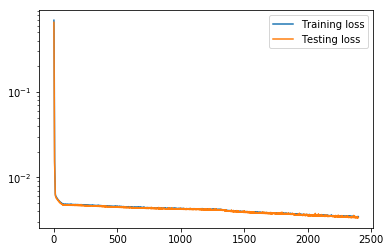

In [172]:
# Now let's train the initial network 

model = offCenterLineNet()
model = model.to(dev)
model.apply(weights_init_uniform)

model.train();

optimizer = torch.optim.Adam(model.parameters(),lr=.01) 
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.1)

n_epochs = 2400

mse_loss = nn.MSELoss()
ce_loss = nn.CrossEntropyLoss()

for epoch in range(0,n_epochs):  # loop over the dataset multiple times
    
    if epoch == 0:
        train_loss_over_time = [] # to track the loss as the network trains
        test_loss_over_time = []
        
    if epoch == 10:
        optimizer = torch.optim.Adam(model.parameters(),lr=.001) 
        
        
    running_loss = 0
    num_batches = 0
    
    for batch_i, data in enumerate(train_loader):
        
        # get the input images and their corresponding labels
        num_batches += 1

        inputs, output_gt, _, _ = data
        inputs, output_gt = inputs.to(dev), output_gt.to(dev)
        
        # zero the parameter (weight) gradients
        optimizer.zero_grad()
        
        # forward pass to get outputs
        output_line_params = model(inputs)
        

        # make the ground truth
        c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
        gt_line_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0]),c),dim=1)
        
        # calculate the loss
#         print(output_line_params[:,:,0,50])
        
        loss = mse_loss(output_line_params,gt_line_params)
        
        # backward pass to calculate the parameter gradients
        loss.backward()

        # update the parameters
        optimizer.step()

        # to convert loss into a scalar and add it to running_loss, we use .item()
        running_loss += loss.item()
      

#     scheduler.step()
    
    # Calculate test data loss after each epoch
    with torch.no_grad():
        test_loss = 0
        num_batches_test = 0
        for batch_i, data in enumerate(test_loader):
            num_batches_test += 1

            # Add code here
            inputs, output_gt, _, _ = data
            inputs, output_gt = inputs.to(dev), output_gt.to(dev)


            # zero the parameter (weight) gradients
            optimizer.zero_grad()

            # forward pass to get outputs
            output_line_params = model(inputs)

            # make the ground truth
            c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
            gt_line_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0]),c),dim=1)
    

            # calculate the loss
    #         print(output_line_params[:,:,0,50])

            loss = mse_loss(output_line_params,gt_line_params)
            
            test_loss += loss
                    
        test_loss_over_time.append(test_loss/num_batches_test)

    # Calculate model loss:
    avg_loss = running_loss/num_batches
    train_loss_over_time.append(avg_loss)
    
#     print('Epoch: {}, Avg. Train Loss: {},'.format(epoch + 1, train_loss_over_time[-1]))


    print('Epoch: {}, Avg. Train Loss: {}, Avg. Test Loss: {}'.format(epoch + 1, train_loss_over_time[-1], test_loss_over_time[-1]))
    
print('Finished Training')

plt.figure()
plt.semilogy(np.arange(0,n_epochs),train_loss_over_time[0:])
plt.semilogy(np.arange(0,n_epochs),test_loss_over_time[0:])
plt.legend(['Training loss', 'Testing loss'])

[tensor(3.6651), tensor(3.6877), tensor(3.6083), tensor(3.4280), tensor(3.6389), tensor(3.4745), tensor(3.4947), tensor(3.5486), tensor(3.7855), tensor(3.6254), tensor(3.9051), tensor(3.6045), tensor(3.5799), tensor(3.6642), tensor(3.9461)]


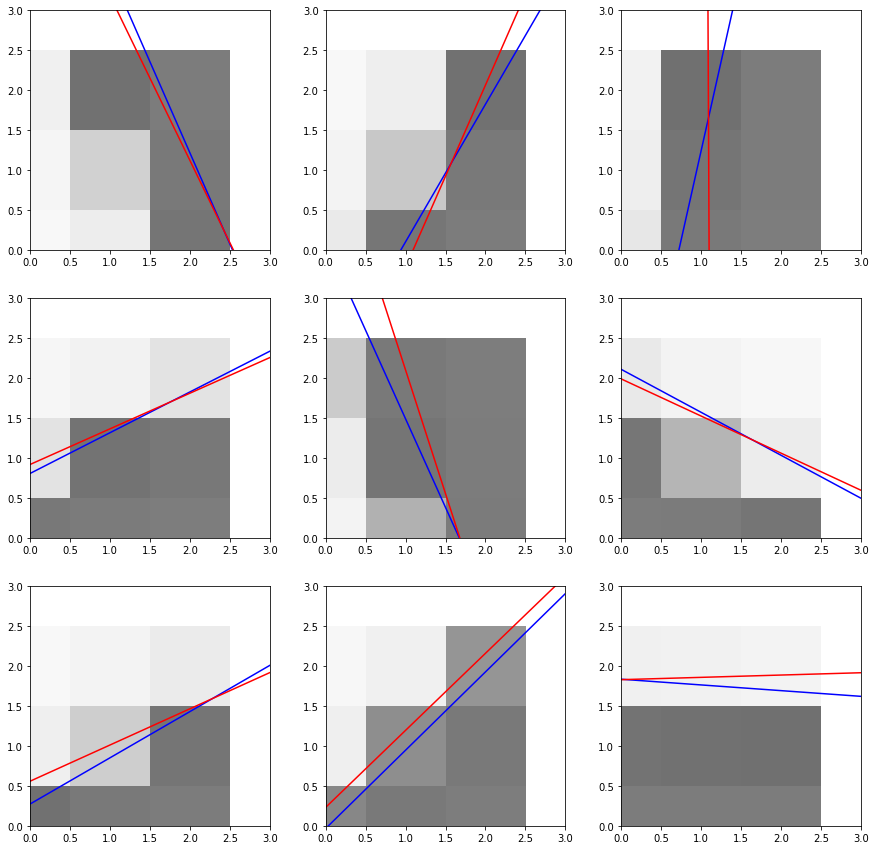

In [173]:
# Plot the Results

model.eval();

ang_loss_all = []

for batch_i, data in enumerate(test_loader):
    # get the input images and their corresponding labels
    inputs, output_gt, _, _ = data
    inputs, output_gt = inputs.to(dev), output_gt.to(dev)
    

    # forward pass to get outputs
    outputs = model(inputs).squeeze().detach().cpu()
    
    gt = output_gt.cpu().squeeze()
    
    c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
    angle_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0]),c),axis=1).detach().cpu()
  
    # Calculate angular loss
    ang_loss = torch.mean(torch.abs(torch.rad2deg(torch.atan2(-angle_params[:,0]*outputs[:,1] + angle_params[:,1]*outputs[:,0]
                                         ,angle_params[:,1]*outputs[:,1]+angle_params[:,0]*outputs[:,0]).cpu())))

    ang_loss_all.append(ang_loss)

    
print(ang_loss_all)

plt.figure(figsize=[15, 15])

for ii in range(9):
    
    plt.subplot(3,3,ii+1)
    plt.imshow(inputs[ii].cpu().squeeze(),cmap='gray', vmin=0, vmax=1)
    
    # Plot the ground truth lines
    x_sample = torch.linspace(-1,1,inputs.shape[-1])
    y_sample = -angle_params[ii,0]/angle_params[ii,1]*x_sample - angle_params[ii,2]/angle_params[ii,1]
    
    plt.plot(x_sample*W/2+W/2,y_sample*W/2+W/2,'b')
    plt.xlim([0,W])
    plt.ylim(([0,W]))
    
    # Plot the estimated lines
    y_est = -outputs[ii,0]/outputs[ii,1]*x_sample - outputs[ii,2]/outputs[ii,1]
    plt.plot(x_sample*W/2+W/2,y_est*W/2+W/2,'r')






# 5x5

50000


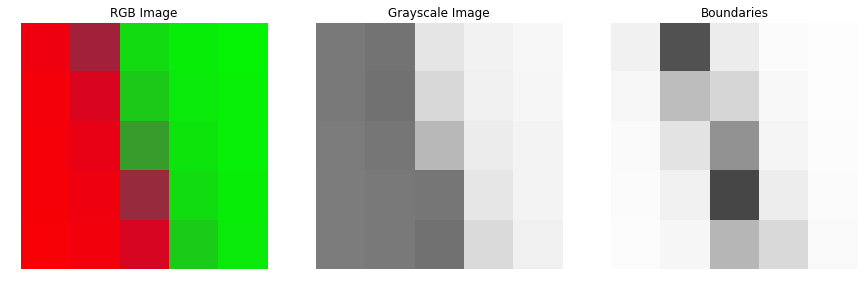

In [176]:
# Load dataset 

data_folder = 'foj_data/grayscale_lines/'

with open(data_folder + 'line_data_5_50000_grey_bicolor_noiseless_uncentered.pkl','rb') as f:
    data = pickle.load(f)

# wedges = data['wedges']
wedges_grey = data['wedges_grey']
params = data['params']
boundaries = data['boundaries']
wedges = data['wedges']


line_data = LineDataset(wedges_grey, params, boundaries, wedges)#, transform=trainTransform)
data_size = len(line_data)

print(data_size)

train_proportion = .85
# Split dataset into training and testing
train_dataset, test_dataset = torch.utils.data.random_split(line_data, [int(data_size*train_proportion), int(data_size*(1-train_proportion))], generator=torch.Generator().manual_seed(42))

# Create loaders for the training and testing data
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1000, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=500, shuffle=False) #len(test_dataset)


W,H = 5,5

img_show = 1
plt.figure(figsize=[15, 15])
plt.subplot(131)
plt.imshow(wedges[img_show,:,:].squeeze().permute(1,2,0).cpu())
plt.title('RGB Image')
plt.axis('off');
plt.subplot(132)
plt.imshow(wedges_grey[img_show,:,:].squeeze().cpu(),cmap='gray', vmin=0, vmax=1)
plt.title('Grayscale Image')
plt.axis('off');
plt.subplot(133)
plt.imshow(boundaries[img_show,:,:].squeeze().cpu(),cmap='gray', vmin=0, vmax=1)
plt.title('Boundaries')
plt.axis('off');


In [193]:
class offCenterLineNet(nn.Module):

    def __init__(self):
        super().__init__()
                
        self.conv1 = nn.Conv2d(1, 2, kernel_size=3) #64 is good
#         self.conv2 = nn.Conv2d(1, 8, kernel_size=3)
#         self.conv3 = nn.Conv2d(128, 8, kernel_size=3)
        self.fc = nn.LazyLinear(3)
#         self.fc2 = nn.LazyLinear(32)
        self.maxpool = nn.MaxPool1d(1)
#         self.avgpool = nn.AvgPool2d(2)
        self.activate = nn.ReLU()
#         self.batchnorm = nn.BatchNorm2d(128)
    
    def forward(self, x):

        x = self.conv1(x)
#         x = F.relu(x)
        x = self.activate(x)
#         x = self.maxpool(x)
#         x = self.batchnorm(x)
#         x = self.conv2(x)
#         x = self.activate(x)
#         x = F.relu(x)
#         x = self.batchnorm(x)
#         x = self.conv3(x)

#         x = self.avgpool(x)
        x = x.view(x.shape[0],-1)
#         x = self.fc2(x)
#         x = self.maxpool(x)
        x = self.fc(x)
         
        # We're defining
        # a = - sin(theta)
        # b = cos(theta)
        # c = -cy*cos(theta)+cx*sin(theta)
        # Hence, we want to normalize the vector by 1/sqrt(a^2 + b^2)
        norm_factor = (torch.norm(x[:,:2],p=2,dim=1)).unsqueeze(1)       
        out = x/(norm_factor)#+eps)
#         print('Output shape=',x.shape)

#         out = x
        
        return out
    
model = offCenterLineNet()
model = model.to(dev)
summary(model, input_size=(1, H, W))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1              [-1, 2, 3, 3]              20
              ReLU-2              [-1, 2, 3, 3]               0
            Linear-3                    [-1, 3]              57
Total params: 77
Trainable params: 77
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


Epoch: 1, Avg. Train Loss: 0.5691371497719787, Avg. Test Loss: 0.4738861918449402
Epoch: 2, Avg. Train Loss: 0.42374646039896235, Avg. Test Loss: 0.3095325827598572
Epoch: 3, Avg. Train Loss: 0.4331767264493676, Avg. Test Loss: 0.4821835458278656
Epoch: 4, Avg. Train Loss: 0.42934983899427015, Avg. Test Loss: 0.3648873269557953
Epoch: 5, Avg. Train Loss: 0.304233715631241, Avg. Test Loss: 0.42176106572151184
Epoch: 6, Avg. Train Loss: 0.404740747324256, Avg. Test Loss: 0.421425998210907
Epoch: 7, Avg. Train Loss: 0.39754962782527126, Avg. Test Loss: 0.36875879764556885
Epoch: 8, Avg. Train Loss: 0.33950644384982975, Avg. Test Loss: 0.30512550473213196
Epoch: 9, Avg. Train Loss: 0.2677428916443226, Avg. Test Loss: 0.22458013892173767
Epoch: 10, Avg. Train Loss: 0.18897357305815055, Avg. Test Loss: 0.21376310288906097
Epoch: 11, Avg. Train Loss: 0.1993591750777045, Avg. Test Loss: 0.18776904046535492
Epoch: 12, Avg. Train Loss: 0.19035639388616696, Avg. Test Loss: 0.18638110160827637
Epo

Epoch: 99, Avg. Train Loss: 0.09909411034611769, Avg. Test Loss: 0.09872257709503174
Epoch: 100, Avg. Train Loss: 0.09778685365305391, Avg. Test Loss: 0.09730557352304459
Epoch: 101, Avg. Train Loss: 0.09630575204311415, Avg. Test Loss: 0.09589368104934692
Epoch: 102, Avg. Train Loss: 0.09485447822615158, Avg. Test Loss: 0.09447738528251648
Epoch: 103, Avg. Train Loss: 0.09366274659716806, Avg. Test Loss: 0.09308353811502457
Epoch: 104, Avg. Train Loss: 0.09200715602830399, Avg. Test Loss: 0.09168058633804321
Epoch: 105, Avg. Train Loss: 0.09064536836258201, Avg. Test Loss: 0.09029829502105713
Epoch: 106, Avg. Train Loss: 0.08929582009481829, Avg. Test Loss: 0.08891608566045761
Epoch: 107, Avg. Train Loss: 0.08794339590294417, Avg. Test Loss: 0.08754045516252518
Epoch: 108, Avg. Train Loss: 0.08666375643292139, Avg. Test Loss: 0.08617030084133148
Epoch: 109, Avg. Train Loss: 0.08527016778324925, Avg. Test Loss: 0.08480887860059738
Epoch: 110, Avg. Train Loss: 0.08391137213207954, Avg. 

Epoch: 194, Avg. Train Loss: 0.013400235299973987, Avg. Test Loss: 0.012995987199246883
Epoch: 195, Avg. Train Loss: 0.013021849204114703, Avg. Test Loss: 0.012643600814044476
Epoch: 196, Avg. Train Loss: 0.012674865940975588, Avg. Test Loss: 0.012300273403525352
Epoch: 197, Avg. Train Loss: 0.012325146517088248, Avg. Test Loss: 0.011964837089180946
Epoch: 198, Avg. Train Loss: 0.011985410026512867, Avg. Test Loss: 0.01163992565125227
Epoch: 199, Avg. Train Loss: 0.011659979820251465, Avg. Test Loss: 0.011323296464979649
Epoch: 200, Avg. Train Loss: 0.011334605536661869, Avg. Test Loss: 0.011015314608812332
Epoch: 201, Avg. Train Loss: 0.011034215908757476, Avg. Test Loss: 0.01071541104465723
Epoch: 202, Avg. Train Loss: 0.010731981005952802, Avg. Test Loss: 0.010424472391605377
Epoch: 203, Avg. Train Loss: 0.01043581124395132, Avg. Test Loss: 0.010140936821699142
Epoch: 204, Avg. Train Loss: 0.010159499661693739, Avg. Test Loss: 0.009865697473287582
Epoch: 205, Avg. Train Loss: 0.0098

Epoch: 287, Avg. Train Loss: 0.0017809068085625768, Avg. Test Loss: 0.001811327296309173
Epoch: 288, Avg. Train Loss: 0.0017595848794160194, Avg. Test Loss: 0.0017913366900756955
Epoch: 289, Avg. Train Loss: 0.0017383016082783078, Avg. Test Loss: 0.0017733138520270586
Epoch: 290, Avg. Train Loss: 0.0017253022429771548, Avg. Test Loss: 0.0017554013757035136
Epoch: 291, Avg. Train Loss: 0.001706183384454181, Avg. Test Loss: 0.001738899271003902
Epoch: 292, Avg. Train Loss: 0.0016899101224966174, Avg. Test Loss: 0.0017226337222382426
Epoch: 293, Avg. Train Loss: 0.0016728487423469508, Avg. Test Loss: 0.00170534395147115
Epoch: 294, Avg. Train Loss: 0.0016577646358285187, Avg. Test Loss: 0.0016898715402930975
Epoch: 295, Avg. Train Loss: 0.001643682358959733, Avg. Test Loss: 0.0016744548920542002
Epoch: 296, Avg. Train Loss: 0.0016267428764813515, Avg. Test Loss: 0.0016601551324129105
Epoch: 297, Avg. Train Loss: 0.0016123418923640667, Avg. Test Loss: 0.0016448087990283966
Epoch: 298, Avg.

Epoch: 379, Avg. Train Loss: 0.0009638089091018882, Avg. Test Loss: 0.000992300221696496
Epoch: 380, Avg. Train Loss: 0.0009587979997334958, Avg. Test Loss: 0.0009825819870457053
Epoch: 381, Avg. Train Loss: 0.0009512614504824025, Avg. Test Loss: 0.0009807719616219401
Epoch: 382, Avg. Train Loss: 0.0009463754479859977, Avg. Test Loss: 0.0009710693266242743
Epoch: 383, Avg. Train Loss: 0.0009399307593919857, Avg. Test Loss: 0.0009647971019148827
Epoch: 384, Avg. Train Loss: 0.0009346495038656474, Avg. Test Loss: 0.0009597417083568871
Epoch: 385, Avg. Train Loss: 0.0009281601226173861, Avg. Test Loss: 0.0009544985368847847
Epoch: 386, Avg. Train Loss: 0.0009245689143426716, Avg. Test Loss: 0.0009485606569796801
Epoch: 387, Avg. Train Loss: 0.0009158544951703313, Avg. Test Loss: 0.0009411536739207804
Epoch: 388, Avg. Train Loss: 0.0009112931912505003, Avg. Test Loss: 0.000936292577534914
Epoch: 389, Avg. Train Loss: 0.0009060837951120595, Avg. Test Loss: 0.0009319255477748811
Epoch: 390, 

Epoch: 471, Avg. Train Loss: 0.0005413477957454445, Avg. Test Loss: 0.0005609704530797899
Epoch: 472, Avg. Train Loss: 0.0005388871677284844, Avg. Test Loss: 0.0005590744549408555
Epoch: 473, Avg. Train Loss: 0.0005359924493119294, Avg. Test Loss: 0.0005567939369939268
Epoch: 474, Avg. Train Loss: 0.0005340160393199428, Avg. Test Loss: 0.0005545204039663076
Epoch: 475, Avg. Train Loss: 0.0005326128015186378, Avg. Test Loss: 0.0005534025258384645
Epoch: 476, Avg. Train Loss: 0.0005307684795995958, Avg. Test Loss: 0.0005503245047293603
Epoch: 477, Avg. Train Loss: 0.0005279818555166901, Avg. Test Loss: 0.0005484120338223875
Epoch: 478, Avg. Train Loss: 0.0005261655923975415, Avg. Test Loss: 0.0005489806644618511
Epoch: 479, Avg. Train Loss: 0.0005260925201244305, Avg. Test Loss: 0.0005445986753329635
Epoch: 480, Avg. Train Loss: 0.000522856448971948, Avg. Test Loss: 0.0005426177522167563
Epoch: 481, Avg. Train Loss: 0.0005218480154601207, Avg. Test Loss: 0.0005431512254290283
Epoch: 482,

Epoch: 562, Avg. Train Loss: 0.00045744774844172563, Avg. Test Loss: 0.00047194925718940794
Epoch: 563, Avg. Train Loss: 0.00045932466055937976, Avg. Test Loss: 0.0004717414849437773
Epoch: 564, Avg. Train Loss: 0.00045756253665638004, Avg. Test Loss: 0.00047163479030132294
Epoch: 565, Avg. Train Loss: 0.00045766843737341293, Avg. Test Loss: 0.0004729311622213572
Epoch: 566, Avg. Train Loss: 0.0004577876629069621, Avg. Test Loss: 0.00047157815424725413
Epoch: 567, Avg. Train Loss: 0.00045591402260131787, Avg. Test Loss: 0.00047126031131483614
Epoch: 568, Avg. Train Loss: 0.0004572965357680047, Avg. Test Loss: 0.0004708192136604339
Epoch: 569, Avg. Train Loss: 0.0004559880322885028, Avg. Test Loss: 0.00046999097685329616
Epoch: 570, Avg. Train Loss: 0.00045574508501801554, Avg. Test Loss: 0.0004686130560003221
Epoch: 571, Avg. Train Loss: 0.0004559222007776762, Avg. Test Loss: 0.0004723567981272936
Epoch: 572, Avg. Train Loss: 0.00045486652701118486, Avg. Test Loss: 0.000470208178739994

Epoch: 652, Avg. Train Loss: 0.0004402932421260968, Avg. Test Loss: 0.00045424854033626616
Epoch: 653, Avg. Train Loss: 0.0004416896384967448, Avg. Test Loss: 0.00045536342076957226
Epoch: 654, Avg. Train Loss: 0.0004411604936332117, Avg. Test Loss: 0.0004578126536216587
Epoch: 655, Avg. Train Loss: 0.00044259687392907436, Avg. Test Loss: 0.0004537251079455018
Epoch: 656, Avg. Train Loss: 0.0004406537066029688, Avg. Test Loss: 0.00045863163541071117
Epoch: 657, Avg. Train Loss: 0.0004413375024532163, Avg. Test Loss: 0.00045251118717715144
Epoch: 658, Avg. Train Loss: 0.00044056952884962216, Avg. Test Loss: 0.0004518204659689218
Epoch: 659, Avg. Train Loss: 0.000439599116446537, Avg. Test Loss: 0.0004532747552730143
Epoch: 660, Avg. Train Loss: 0.00044009040737914487, Avg. Test Loss: 0.00045185236376710236
Epoch: 661, Avg. Train Loss: 0.0004389968911878938, Avg. Test Loss: 0.00045455372310243547
Epoch: 662, Avg. Train Loss: 0.00043985805931760996, Avg. Test Loss: 0.0004511172301135957
E

Epoch: 743, Avg. Train Loss: 0.0004328363094489675, Avg. Test Loss: 0.0004442546924110502
Epoch: 744, Avg. Train Loss: 0.0004327623363107789, Avg. Test Loss: 0.0004455205053091049
Epoch: 745, Avg. Train Loss: 0.0004315928922868659, Avg. Test Loss: 0.0004466130631044507
Epoch: 746, Avg. Train Loss: 0.00043392112494857854, Avg. Test Loss: 0.0004477675538510084
Epoch: 747, Avg. Train Loss: 0.00043269885611871994, Avg. Test Loss: 0.0004446303064469248
Epoch: 748, Avg. Train Loss: 0.00043137403283549777, Avg. Test Loss: 0.00044450981658883393
Epoch: 749, Avg. Train Loss: 0.0004316842688388343, Avg. Test Loss: 0.000444375560618937
Epoch: 750, Avg. Train Loss: 0.0004326454411141661, Avg. Test Loss: 0.000446115096565336
Epoch: 751, Avg. Train Loss: 0.00043169571273570315, Avg. Test Loss: 0.00044410739792510867
Epoch: 752, Avg. Train Loss: 0.00043117429053974015, Avg. Test Loss: 0.0004425194929353893
Epoch: 753, Avg. Train Loss: 0.000431421565482133, Avg. Test Loss: 0.0004485609824769199
Epoch:

Epoch: 834, Avg. Train Loss: 0.00042203477405141607, Avg. Test Loss: 0.00043735982035286725
Epoch: 835, Avg. Train Loss: 0.0004216150413159021, Avg. Test Loss: 0.00043352972716093063
Epoch: 836, Avg. Train Loss: 0.0004234697776684148, Avg. Test Loss: 0.00043287983862683177
Epoch: 837, Avg. Train Loss: 0.00042124423008888613, Avg. Test Loss: 0.0004349669616203755
Epoch: 838, Avg. Train Loss: 0.0004206260667604849, Avg. Test Loss: 0.0004336766432970762
Epoch: 839, Avg. Train Loss: 0.00042171282274107083, Avg. Test Loss: 0.00043200646177865565
Epoch: 840, Avg. Train Loss: 0.0004221009737595396, Avg. Test Loss: 0.00043513556011021137
Epoch: 841, Avg. Train Loss: 0.0004218212588755197, Avg. Test Loss: 0.0004332124372012913
Epoch: 842, Avg. Train Loss: 0.0004196322298348816, Avg. Test Loss: 0.0004330635129008442
Epoch: 843, Avg. Train Loss: 0.0004208588202451464, Avg. Test Loss: 0.0004341796156950295
Epoch: 844, Avg. Train Loss: 0.00042265537804057603, Avg. Test Loss: 0.0004361892642918974
E

Epoch: 925, Avg. Train Loss: 0.0004162149947829718, Avg. Test Loss: 0.00043214394827373326
Epoch: 926, Avg. Train Loss: 0.0004175538765699711, Avg. Test Loss: 0.0004297918058000505
Epoch: 927, Avg. Train Loss: 0.0004168675419181412, Avg. Test Loss: 0.0004299658176023513
Epoch: 928, Avg. Train Loss: 0.0004174657420493489, Avg. Test Loss: 0.0004351501411292702
Epoch: 929, Avg. Train Loss: 0.00041905058842953727, Avg. Test Loss: 0.0004309848591219634
Epoch: 930, Avg. Train Loss: 0.00041675309279695324, Avg. Test Loss: 0.00042862887494266033
Epoch: 931, Avg. Train Loss: 0.0004168329361100616, Avg. Test Loss: 0.00042844045674428344
Epoch: 932, Avg. Train Loss: 0.00041788704977587383, Avg. Test Loss: 0.00042960798600688577
Epoch: 933, Avg. Train Loss: 0.0004173042509856439, Avg. Test Loss: 0.00042898234096355736
Epoch: 934, Avg. Train Loss: 0.00041857932093228366, Avg. Test Loss: 0.0004316361155360937
Epoch: 935, Avg. Train Loss: 0.0004171521868556738, Avg. Test Loss: 0.00043103910866193473


Epoch: 1015, Avg. Train Loss: 0.0004144126811974444, Avg. Test Loss: 0.0004260750429239124
Epoch: 1016, Avg. Train Loss: 0.00041429354229855327, Avg. Test Loss: 0.00042651593685150146
Epoch: 1017, Avg. Train Loss: 0.0004135605041208395, Avg. Test Loss: 0.00042950251372531056
Epoch: 1018, Avg. Train Loss: 0.00041545509647707954, Avg. Test Loss: 0.0004275238316040486
Epoch: 1019, Avg. Train Loss: 0.0004139117961532848, Avg. Test Loss: 0.0004276412073522806
Epoch: 1020, Avg. Train Loss: 0.0004141970394114249, Avg. Test Loss: 0.0004299420688766986
Epoch: 1021, Avg. Train Loss: 0.00041347909461555266, Avg. Test Loss: 0.0004328830982558429
Epoch: 1022, Avg. Train Loss: 0.0004138623433306727, Avg. Test Loss: 0.00042748445412144065
Epoch: 1023, Avg. Train Loss: 0.0004141130755373905, Avg. Test Loss: 0.00042544209281913936
Epoch: 1024, Avg. Train Loss: 0.00041456943172095125, Avg. Test Loss: 0.00042587690404616296
Epoch: 1025, Avg. Train Loss: 0.0004144129059060888, Avg. Test Loss: 0.0004286601

Epoch: 1105, Avg. Train Loss: 0.00041330482087877774, Avg. Test Loss: 0.0004259580164216459
Epoch: 1106, Avg. Train Loss: 0.00041204828330380623, Avg. Test Loss: 0.0004284977912902832
Epoch: 1107, Avg. Train Loss: 0.0004107219960302288, Avg. Test Loss: 0.0004257952095940709
Epoch: 1108, Avg. Train Loss: 0.0004118638205190384, Avg. Test Loss: 0.0004275264509487897
Epoch: 1109, Avg. Train Loss: 0.00041203929428119474, Avg. Test Loss: 0.00042542870505712926
Epoch: 1110, Avg. Train Loss: 0.0004126103073737562, Avg. Test Loss: 0.0004295306862331927
Epoch: 1111, Avg. Train Loss: 0.0004136479997108582, Avg. Test Loss: 0.00042424723505973816
Epoch: 1112, Avg. Train Loss: 0.00041180149094353235, Avg. Test Loss: 0.00042511013452894986
Epoch: 1113, Avg. Train Loss: 0.00041108881935563894, Avg. Test Loss: 0.00042352580931037664
Epoch: 1114, Avg. Train Loss: 0.00041155774162562436, Avg. Test Loss: 0.00043026305502280593
Epoch: 1115, Avg. Train Loss: 0.00041203854570360203, Avg. Test Loss: 0.0004257

Epoch: 1195, Avg. Train Loss: 0.000408112637963969, Avg. Test Loss: 0.00042168167419731617
Epoch: 1196, Avg. Train Loss: 0.00040916992123996796, Avg. Test Loss: 0.00042395907803438604
Epoch: 1197, Avg. Train Loss: 0.00040953649616756933, Avg. Test Loss: 0.00042577245039865375
Epoch: 1198, Avg. Train Loss: 0.0004097966268810249, Avg. Test Loss: 0.0004230277263559401
Epoch: 1199, Avg. Train Loss: 0.0004087903050889889, Avg. Test Loss: 0.0004227290628477931
Epoch: 1200, Avg. Train Loss: 0.0004088748361493006, Avg. Test Loss: 0.00042493335786275566
Epoch: 1201, Avg. Train Loss: 0.00040911351395554323, Avg. Test Loss: 0.0004240259004291147
Epoch: 1202, Avg. Train Loss: 0.00040890848626880797, Avg. Test Loss: 0.0004223474534228444
Epoch: 1203, Avg. Train Loss: 0.0004082450387338826, Avg. Test Loss: 0.0004273125668987632
Epoch: 1204, Avg. Train Loss: 0.00040881510019887153, Avg. Test Loss: 0.0004219881375320256
Epoch: 1205, Avg. Train Loss: 0.00040981632679007777, Avg. Test Loss: 0.0004264794

Epoch: 1285, Avg. Train Loss: 0.00040601465856483163, Avg. Test Loss: 0.00042000546818599105
Epoch: 1286, Avg. Train Loss: 0.0004067644030180608, Avg. Test Loss: 0.0004257034743204713
Epoch: 1287, Avg. Train Loss: 0.000407642179959302, Avg. Test Loss: 0.0004204052675049752
Epoch: 1288, Avg. Train Loss: 0.00040631252679389056, Avg. Test Loss: 0.0004196251684334129
Epoch: 1289, Avg. Train Loss: 0.0004068885247634594, Avg. Test Loss: 0.00042184069752693176
Epoch: 1290, Avg. Train Loss: 0.00040716211092225167, Avg. Test Loss: 0.0004212773928884417
Epoch: 1291, Avg. Train Loss: 0.0004059978088006637, Avg. Test Loss: 0.00042194509296678007
Epoch: 1292, Avg. Train Loss: 0.0004056346011185629, Avg. Test Loss: 0.0004214716318529099
Epoch: 1293, Avg. Train Loss: 0.00040885976171879055, Avg. Test Loss: 0.00042504406883381307
Epoch: 1294, Avg. Train Loss: 0.0004069550094183881, Avg. Test Loss: 0.00041968151344917715
Epoch: 1295, Avg. Train Loss: 0.00040613508073959585, Avg. Test Loss: 0.0004232247

Epoch: 1375, Avg. Train Loss: 0.00040534677235734497, Avg. Test Loss: 0.0004236761014908552
Epoch: 1376, Avg. Train Loss: 0.0004021931855213763, Avg. Test Loss: 0.00041810391121543944
Epoch: 1377, Avg. Train Loss: 0.00040238688098873164, Avg. Test Loss: 0.0004238672845531255
Epoch: 1378, Avg. Train Loss: 0.0004019983780169643, Avg. Test Loss: 0.0004165402497164905
Epoch: 1379, Avg. Train Loss: 0.0004022568545499167, Avg. Test Loss: 0.0004179336247034371
Epoch: 1380, Avg. Train Loss: 0.00040193749821831496, Avg. Test Loss: 0.0004161484830547124
Epoch: 1381, Avg. Train Loss: 0.0004029160522487621, Avg. Test Loss: 0.0004161676042713225
Epoch: 1382, Avg. Train Loss: 0.000402450179112642, Avg. Test Loss: 0.00041800629696808755
Epoch: 1383, Avg. Train Loss: 0.00040057679938780533, Avg. Test Loss: 0.0004169938911218196
Epoch: 1384, Avg. Train Loss: 0.00040222252285931, Avg. Test Loss: 0.0004166175494901836
Epoch: 1385, Avg. Train Loss: 0.0004029884558106058, Avg. Test Loss: 0.0004167517763562

Epoch: 1465, Avg. Train Loss: 0.00039903885822981425, Avg. Test Loss: 0.00041589440661482513
Epoch: 1466, Avg. Train Loss: 0.0003994327163063856, Avg. Test Loss: 0.00041459506610408425
Epoch: 1467, Avg. Train Loss: 0.000398236328226969, Avg. Test Loss: 0.0004210273618809879
Epoch: 1468, Avg. Train Loss: 0.0003999917575721304, Avg. Test Loss: 0.0004149273154325783
Epoch: 1469, Avg. Train Loss: 0.0003997070808234343, Avg. Test Loss: 0.0004142917459830642
Epoch: 1470, Avg. Train Loss: 0.00040002095818974425, Avg. Test Loss: 0.0004211042250972241
Epoch: 1471, Avg. Train Loss: 0.00040125896677721377, Avg. Test Loss: 0.0004182544944342226
Epoch: 1472, Avg. Train Loss: 0.0003999898658231507, Avg. Test Loss: 0.0004159582022111863
Epoch: 1473, Avg. Train Loss: 0.0004005257499155177, Avg. Test Loss: 0.00042520754504948854
Epoch: 1474, Avg. Train Loss: 0.0004002935507573014, Avg. Test Loss: 0.00041426660027354956
Epoch: 1475, Avg. Train Loss: 0.0003994571411884715, Avg. Test Loss: 0.0004167034931

Epoch: 1555, Avg. Train Loss: 0.0003972666698161426, Avg. Test Loss: 0.0004156919603701681
Epoch: 1556, Avg. Train Loss: 0.0003964037852372628, Avg. Test Loss: 0.0004109771107323468
Epoch: 1557, Avg. Train Loss: 0.0003978046446464696, Avg. Test Loss: 0.00041169775067828596
Epoch: 1558, Avg. Train Loss: 0.0003975647634306793, Avg. Test Loss: 0.00041610447806306183
Epoch: 1559, Avg. Train Loss: 0.0003954343156629177, Avg. Test Loss: 0.00041157600935548544
Epoch: 1560, Avg. Train Loss: 0.0003956601938752587, Avg. Test Loss: 0.00041233704541809857
Epoch: 1561, Avg. Train Loss: 0.0003962138556702019, Avg. Test Loss: 0.00041090924059972167
Epoch: 1562, Avg. Train Loss: 0.0003970397648477364, Avg. Test Loss: 0.00041410556877963245
Epoch: 1563, Avg. Train Loss: 0.00039766206836522837, Avg. Test Loss: 0.00041077969945035875
Epoch: 1564, Avg. Train Loss: 0.0003964574317187937, Avg. Test Loss: 0.00041658972622826695
Epoch: 1565, Avg. Train Loss: 0.00039680541268289954, Avg. Test Loss: 0.000410595

Epoch: 1645, Avg. Train Loss: 0.0003940538113373657, Avg. Test Loss: 0.0004090914153493941
Epoch: 1646, Avg. Train Loss: 0.0003945865725210413, Avg. Test Loss: 0.0004127880383748561
Epoch: 1647, Avg. Train Loss: 0.000394721983845324, Avg. Test Loss: 0.00040701933903619647
Epoch: 1648, Avg. Train Loss: 0.000393138068110877, Avg. Test Loss: 0.00040867680218070745
Epoch: 1649, Avg. Train Loss: 0.00039242817356987576, Avg. Test Loss: 0.00041075347689911723
Epoch: 1650, Avg. Train Loss: 0.0003933463236154599, Avg. Test Loss: 0.000407739746151492
Epoch: 1651, Avg. Train Loss: 0.00039365752004520146, Avg. Test Loss: 0.0004069376736879349
Epoch: 1652, Avg. Train Loss: 0.0003934007795895775, Avg. Test Loss: 0.0004070661962032318
Epoch: 1653, Avg. Train Loss: 0.0003926224903701696, Avg. Test Loss: 0.0004083043895661831
Epoch: 1654, Avg. Train Loss: 0.00039280935117520045, Avg. Test Loss: 0.0004124258121009916
Epoch: 1655, Avg. Train Loss: 0.0003926247212126158, Avg. Test Loss: 0.0004098608915228

Epoch: 1735, Avg. Train Loss: 0.0003894638983521957, Avg. Test Loss: 0.00040634366450831294
Epoch: 1736, Avg. Train Loss: 0.00038869310167704733, Avg. Test Loss: 0.00040692745824344456
Epoch: 1737, Avg. Train Loss: 0.000389342540117024, Avg. Test Loss: 0.0004070582799613476
Epoch: 1738, Avg. Train Loss: 0.0003911934604835805, Avg. Test Loss: 0.00040226761484518647
Epoch: 1739, Avg. Train Loss: 0.00038880813625901073, Avg. Test Loss: 0.0004025604866910726
Epoch: 1740, Avg. Train Loss: 0.0003884903034790917, Avg. Test Loss: 0.0004029145638924092
Epoch: 1741, Avg. Train Loss: 0.00038930201878619575, Avg. Test Loss: 0.00040217392961494625
Epoch: 1742, Avg. Train Loss: 0.0003880860411215487, Avg. Test Loss: 0.00040292597259394825
Epoch: 1743, Avg. Train Loss: 0.0003878027877532119, Avg. Test Loss: 0.00040285021532326937
Epoch: 1744, Avg. Train Loss: 0.00038885481406523043, Avg. Test Loss: 0.00040937247104011476
Epoch: 1745, Avg. Train Loss: 0.00039137874426710054, Avg. Test Loss: 0.00040665

Epoch: 1825, Avg. Train Loss: 0.0003849577096420838, Avg. Test Loss: 0.0003983905480708927
Epoch: 1826, Avg. Train Loss: 0.00038508274443555885, Avg. Test Loss: 0.000396332994569093
Epoch: 1827, Avg. Train Loss: 0.0003832492559097794, Avg. Test Loss: 0.0003963619819842279
Epoch: 1828, Avg. Train Loss: 0.0003843200156129463, Avg. Test Loss: 0.00039804770494811237
Epoch: 1829, Avg. Train Loss: 0.0003849397133223626, Avg. Test Loss: 0.0003988771350122988
Epoch: 1830, Avg. Train Loss: 0.000385319838451958, Avg. Test Loss: 0.0003992599085904658
Epoch: 1831, Avg. Train Loss: 0.0003827726495517201, Avg. Test Loss: 0.0003993240534327924
Epoch: 1832, Avg. Train Loss: 0.00038368358929251686, Avg. Test Loss: 0.00039693203871138394
Epoch: 1833, Avg. Train Loss: 0.00038326432221829027, Avg. Test Loss: 0.0003992697747889906
Epoch: 1834, Avg. Train Loss: 0.0003839033103526332, Avg. Test Loss: 0.00040175809408538043
Epoch: 1835, Avg. Train Loss: 0.00038433213498941513, Avg. Test Loss: 0.00039977621054

Epoch: 1915, Avg. Train Loss: 0.0003791139434026771, Avg. Test Loss: 0.00039221299812197685
Epoch: 1916, Avg. Train Loss: 0.00037907755143160737, Avg. Test Loss: 0.00039170897798612714
Epoch: 1917, Avg. Train Loss: 0.00037932352143946256, Avg. Test Loss: 0.0003896659763995558
Epoch: 1918, Avg. Train Loss: 0.0003776504681174925, Avg. Test Loss: 0.0003888600040227175
Epoch: 1919, Avg. Train Loss: 0.00037744619848401566, Avg. Test Loss: 0.00038888573180884123
Epoch: 1920, Avg. Train Loss: 0.0003775746885113158, Avg. Test Loss: 0.0003907394129782915
Epoch: 1921, Avg. Train Loss: 0.00037845928116355006, Avg. Test Loss: 0.00039007121813483536
Epoch: 1922, Avg. Train Loss: 0.000379095099010873, Avg. Test Loss: 0.00038854748709127307
Epoch: 1923, Avg. Train Loss: 0.0003776163983613599, Avg. Test Loss: 0.0003915869165211916
Epoch: 1924, Avg. Train Loss: 0.0003787728850892203, Avg. Test Loss: 0.0003931152168661356
Epoch: 1925, Avg. Train Loss: 0.00037775029222545926, Avg. Test Loss: 0.0003904206

Epoch: 2005, Avg. Train Loss: 0.0003738178692888035, Avg. Test Loss: 0.00038877304177731276
Epoch: 2006, Avg. Train Loss: 0.00037393586569314086, Avg. Test Loss: 0.00038625815068371594
Epoch: 2007, Avg. Train Loss: 0.0003738105500138603, Avg. Test Loss: 0.0003866905753966421
Epoch: 2008, Avg. Train Loss: 0.0003742519468285663, Avg. Test Loss: 0.0003891638480126858
Epoch: 2009, Avg. Train Loss: 0.00037548316407104047, Avg. Test Loss: 0.00038448639679700136
Epoch: 2010, Avg. Train Loss: 0.0003742169667316904, Avg. Test Loss: 0.00038320125895552337
Epoch: 2011, Avg. Train Loss: 0.00037296683470675247, Avg. Test Loss: 0.0003889866638928652
Epoch: 2012, Avg. Train Loss: 0.0003740985222637307, Avg. Test Loss: 0.0003847831685561687
Epoch: 2013, Avg. Train Loss: 0.00037248300383040724, Avg. Test Loss: 0.00038642107392661273
Epoch: 2014, Avg. Train Loss: 0.0003755621830012303, Avg. Test Loss: 0.00038578876410610974
Epoch: 2015, Avg. Train Loss: 0.0003756837693292128, Avg. Test Loss: 0.000383588

Epoch: 2095, Avg. Train Loss: 0.0003701021250467314, Avg. Test Loss: 0.0003867075720336288
Epoch: 2096, Avg. Train Loss: 0.0003722629497683239, Avg. Test Loss: 0.00038374587893486023
Epoch: 2097, Avg. Train Loss: 0.00036979806717745095, Avg. Test Loss: 0.00038359497557394207
Epoch: 2098, Avg. Train Loss: 0.00036966958324165017, Avg. Test Loss: 0.00038075027987360954
Epoch: 2099, Avg. Train Loss: 0.0003691976964419578, Avg. Test Loss: 0.00037997931940481067
Epoch: 2100, Avg. Train Loss: 0.00037075022335684055, Avg. Test Loss: 0.0003819945268332958
Epoch: 2101, Avg. Train Loss: 0.00037116862679181925, Avg. Test Loss: 0.0003807587781921029
Epoch: 2102, Avg. Train Loss: 0.0003691103057610954, Avg. Test Loss: 0.00038401797064580023
Epoch: 2103, Avg. Train Loss: 0.0003707384092321749, Avg. Test Loss: 0.0003839832788798958
Epoch: 2104, Avg. Train Loss: 0.00036997085255787294, Avg. Test Loss: 0.00038130010943859816
Epoch: 2105, Avg. Train Loss: 0.00036940692590961105, Avg. Test Loss: 0.0003829

Epoch: 2185, Avg. Train Loss: 0.00036281472285884585, Avg. Test Loss: 0.0003705320705194026
Epoch: 2186, Avg. Train Loss: 0.0003629714138210253, Avg. Test Loss: 0.00037036105641163886
Epoch: 2187, Avg. Train Loss: 0.00036134344842393213, Avg. Test Loss: 0.0003690374724101275
Epoch: 2188, Avg. Train Loss: 0.00036088219332118884, Avg. Test Loss: 0.00036972181987948716
Epoch: 2189, Avg. Train Loss: 0.0003628616368798756, Avg. Test Loss: 0.00037293211789801717
Epoch: 2190, Avg. Train Loss: 0.00036092539152758586, Avg. Test Loss: 0.000370252673747018
Epoch: 2191, Avg. Train Loss: 0.0003625212872108488, Avg. Test Loss: 0.00037259404780343175
Epoch: 2192, Avg. Train Loss: 0.000361036132279307, Avg. Test Loss: 0.00036850603646598756
Epoch: 2193, Avg. Train Loss: 0.0003602370344979559, Avg. Test Loss: 0.00037276005605235696
Epoch: 2194, Avg. Train Loss: 0.00036143326419838814, Avg. Test Loss: 0.0003683208196889609
Epoch: 2195, Avg. Train Loss: 0.00035885798739442644, Avg. Test Loss: 0.000373639

Epoch: 2275, Avg. Train Loss: 0.0003538913131409953, Avg. Test Loss: 0.0003625427489168942
Epoch: 2276, Avg. Train Loss: 0.0003525248023432268, Avg. Test Loss: 0.0003612021973822266
Epoch: 2277, Avg. Train Loss: 0.0003521962234815366, Avg. Test Loss: 0.0003656101180240512
Epoch: 2278, Avg. Train Loss: 0.0003530296177581646, Avg. Test Loss: 0.00036367247230373323
Epoch: 2279, Avg. Train Loss: 0.00035287147431179534, Avg. Test Loss: 0.0003615451860241592
Epoch: 2280, Avg. Train Loss: 0.0003531907013682432, Avg. Test Loss: 0.0003670839359983802
Epoch: 2281, Avg. Train Loss: 0.00035371992339076864, Avg. Test Loss: 0.0003618716436903924
Epoch: 2282, Avg. Train Loss: 0.00035217111702835145, Avg. Test Loss: 0.0003637251502368599
Epoch: 2283, Avg. Train Loss: 0.000352494285961743, Avg. Test Loss: 0.0003620471397880465
Epoch: 2284, Avg. Train Loss: 0.0003529613814587423, Avg. Test Loss: 0.000363681378075853
Epoch: 2285, Avg. Train Loss: 0.0003532042481860709, Avg. Test Loss: 0.00036256772000342

Epoch: 2365, Avg. Train Loss: 0.00035070560379820163, Avg. Test Loss: 0.0003614422457758337
Epoch: 2366, Avg. Train Loss: 0.00035034101131523765, Avg. Test Loss: 0.00036476398236118257
Epoch: 2367, Avg. Train Loss: 0.00035274028913442825, Avg. Test Loss: 0.00036305285175330937
Epoch: 2368, Avg. Train Loss: 0.0003504266902847692, Avg. Test Loss: 0.0003592024149838835
Epoch: 2369, Avg. Train Loss: 0.00035004658410650526, Avg. Test Loss: 0.0003660929505713284
Epoch: 2370, Avg. Train Loss: 0.00035005811531486555, Avg. Test Loss: 0.00036017625825479627
Epoch: 2371, Avg. Train Loss: 0.00035071240326519623, Avg. Test Loss: 0.0003617141046561301
Epoch: 2372, Avg. Train Loss: 0.00035093351454084173, Avg. Test Loss: 0.00035870802821591496
Epoch: 2373, Avg. Train Loss: 0.0003497328759485119, Avg. Test Loss: 0.0003588729596231133
Epoch: 2374, Avg. Train Loss: 0.00034989132600035086, Avg. Test Loss: 0.0003598952025640756
Epoch: 2375, Avg. Train Loss: 0.0003495440367598433, Avg. Test Loss: 0.0003620

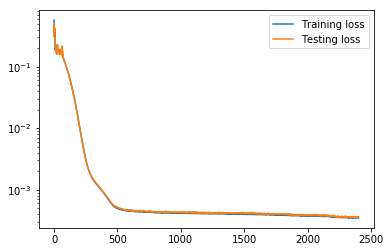

In [194]:
# Now let's train the initial network 

model = offCenterLineNet()
model = model.to(dev)
model.apply(weights_init_uniform)

model.train();

optimizer = torch.optim.Adam(model.parameters(),lr=.01) 
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.1)

n_epochs = 2400

mse_loss = nn.MSELoss()
ce_loss = nn.CrossEntropyLoss()

for epoch in range(0,n_epochs):  # loop over the dataset multiple times
    
    if epoch == 0:
        train_loss_over_time = [] # to track the loss as the network trains
        test_loss_over_time = []
        
    if epoch == 10:
        optimizer = torch.optim.Adam(model.parameters(),lr=.001) 
        
        
    running_loss = 0
    num_batches = 0
    
    for batch_i, data in enumerate(train_loader):
        
        # get the input images and their corresponding labels
        num_batches += 1

        inputs, output_gt, _, _ = data
        inputs, output_gt = inputs.to(dev), output_gt.to(dev)
        
        # zero the parameter (weight) gradients
        optimizer.zero_grad()
        
        # forward pass to get outputs
        output_line_params = model(inputs)
        

        # make the ground truth
        c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
        gt_line_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0]),c),dim=1)
        
        # calculate the loss
#         print(output_line_params[:,:,0,50])
        
        loss = mse_loss(output_line_params,gt_line_params)
        
        # backward pass to calculate the parameter gradients
        loss.backward()

        # update the parameters
        optimizer.step()

        # to convert loss into a scalar and add it to running_loss, we use .item()
        running_loss += loss.item()
      

#     scheduler.step()
    
    # Calculate test data loss after each epoch
    with torch.no_grad():
        test_loss = 0
        num_batches_test = 0
        for batch_i, data in enumerate(test_loader):
            num_batches_test += 1

            # Add code here
            inputs, output_gt, _, _ = data
            inputs, output_gt = inputs.to(dev), output_gt.to(dev)


            # zero the parameter (weight) gradients
            optimizer.zero_grad()

            # forward pass to get outputs
            output_line_params = model(inputs)

            # make the ground truth
            c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
            gt_line_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0]),c),dim=1)
    

            # calculate the loss
    #         print(output_line_params[:,:,0,50])

            loss = mse_loss(output_line_params,gt_line_params)
            
            test_loss += loss
                    
        test_loss_over_time.append(test_loss/num_batches_test)

    # Calculate model loss:
    avg_loss = running_loss/num_batches
    train_loss_over_time.append(avg_loss)
    
#     print('Epoch: {}, Avg. Train Loss: {},'.format(epoch + 1, train_loss_over_time[-1]))


    print('Epoch: {}, Avg. Train Loss: {}, Avg. Test Loss: {}'.format(epoch + 1, train_loss_over_time[-1], test_loss_over_time[-1]))
    
print('Finished Training')

plt.figure()
plt.semilogy(np.arange(0,n_epochs),train_loss_over_time[0:])
plt.semilogy(np.arange(0,n_epochs),test_loss_over_time[0:])
plt.legend(['Training loss', 'Testing loss'])

[tensor(1.1741), tensor(1.1577), tensor(1.0646), tensor(1.1119), tensor(1.0726), tensor(1.1662), tensor(1.1699), tensor(1.1647), tensor(1.1409), tensor(1.1444), tensor(1.1469), tensor(1.1610), tensor(1.0430), tensor(1.2330), tensor(1.1172)]


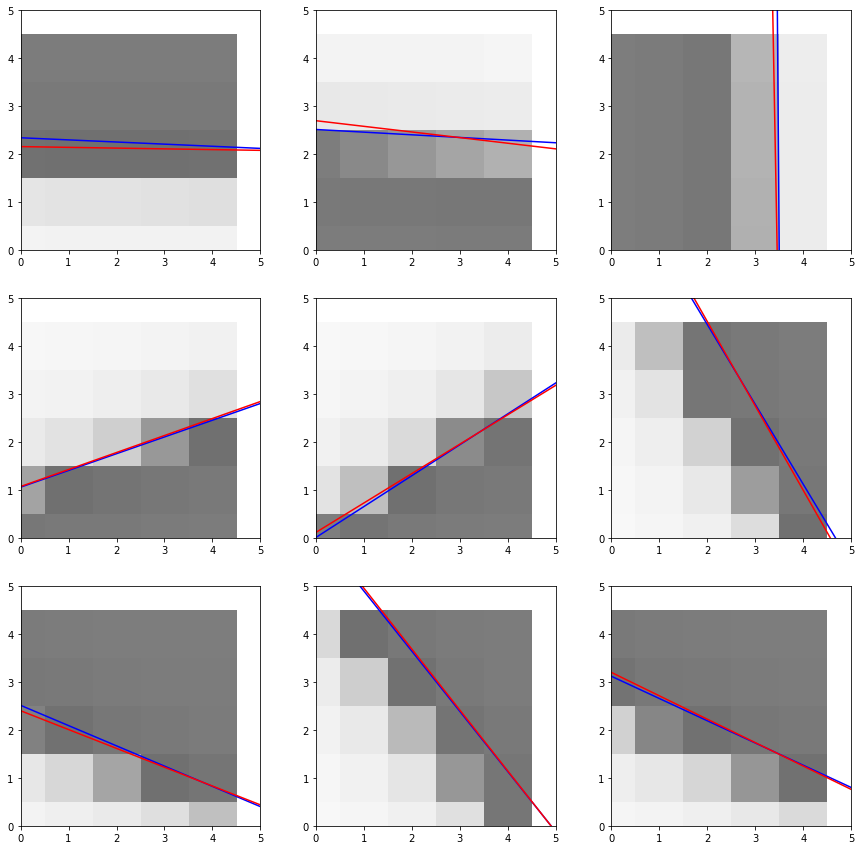

In [195]:
# Plot the Results

model.eval();

ang_loss_all = []

for batch_i, data in enumerate(test_loader):
    # get the input images and their corresponding labels
    inputs, output_gt, _, _ = data
    inputs, output_gt = inputs.to(dev), output_gt.to(dev)
    

    # forward pass to get outputs
    outputs = model(inputs).squeeze().detach().cpu()
    
    gt = output_gt.cpu().squeeze()
    
    c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
    angle_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0]),c),axis=1).detach().cpu()
  
    # Calculate angular loss
    ang_loss = torch.mean(torch.abs(torch.rad2deg(torch.atan2(-angle_params[:,0]*outputs[:,1] + angle_params[:,1]*outputs[:,0]
                                         ,angle_params[:,1]*outputs[:,1]+angle_params[:,0]*outputs[:,0]).cpu())))

    ang_loss_all.append(ang_loss)

    
print(ang_loss_all)

plt.figure(figsize=[15, 15])

for ii in range(9):
    
    plt.subplot(3,3,ii+1)
    plt.imshow(inputs[ii].cpu().squeeze(),cmap='gray', vmin=0, vmax=1)
    
    # Plot the ground truth lines
    x_sample = torch.linspace(-1,1,inputs.shape[-1])
    y_sample = -angle_params[ii,0]/angle_params[ii,1]*x_sample - angle_params[ii,2]/angle_params[ii,1]
    
    plt.plot(x_sample*W/2+W/2,y_sample*W/2+W/2,'b')
    plt.xlim([0,W])
    plt.ylim(([0,W]))
    
    # Plot the estimated lines
    y_est = -outputs[ii,0]/outputs[ii,1]*x_sample - outputs[ii,2]/outputs[ii,1]
    plt.plot(x_sample*W/2+W/2,y_est*W/2+W/2,'r')




